In [1]:
import os
import gc
import re
import time
import random
import numpy as np
import csv
import copy
import glob
import math
import joblib
import torch
import torch.nn as nn
from torch.optim import AdamW
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1 import make_axes_locatable
from transformers import BertTokenizer, VisualBertForQuestionAnswering, VisualBertConfig
import scipy
from scipy.stats import mannwhitneyu
from scipy.signal import savgol_filter
from scipy.ndimage import gaussian_filter
from scipy.interpolate import CubicSpline, interp1d
from sklearn.model_selection import KFold
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve, classification_report, top_k_accuracy_score, coverage_error
import warnings
warnings.filterwarnings("ignore")

def scherrer_fwhm(crystal_size, theta, wavelength=1.5406, shape_factor=0.9):
    theta_rad = np.deg2rad(theta/2)
    fwhm = (shape_factor*wavelength)/(crystal_size*np.cos(theta_rad))
    return fwhm

def load_plt_setting():
    plt.style.use('seaborn-white')
    mpl.rcParams['font.sans-serif'] = "Arial"
    mpl.rcParams['font.family'] = "sans-serif"
    mpl.rcParams['axes.linewidth'] = 2
    font = {'size': 32}
    mpl.rc('font', **font)
    mpl.rcParams['xtick.major.pad']='8'
    mpl.rcParams['ytick.major.pad']='8'
    plt.rcParams["font.weight"] = "normal"
    plt.rcParams["axes.labelweight"] = "normal"
    plt.rcParams['svg.fonttype'] = 'none'
    mpl.rcParams['axes.linewidth'] = 2

translate_dic = {'alpha':r'$\alpha$','beta':r'$\beta$','delta':r'$\delta$','gamma':r'$\gamma$','Pnma':r'orthorhombic','tetragonal':r'$\beta$'}    

tokenizer = BertTokenizer.from_pretrained("google-bert/bert-base-uncased")
_ = tokenizer.add_tokens('pb')

# 1 Dataloader

In [2]:
class DataLoader():
    '''
    [Input]
    dataset_path:      Path to dataset generated from preprocess.py
                       dataset: 'formula', 'element_list', 'space_group', 'xrd_list'
                                'xrd_list': list of (X,Y), len(xrd_list) depends on the strain setting
    
    batch_size:        Batch size n.
    n_mix:             List of n compounds coexisting in one XRD.
    
    [Output]
    Xs:                Array of intensity in (n,Y,1), n = batch_size
    Ys:                Array of classification labels in (n, len(dataset))
    element_list:      List of elements for each sample, n = len(element_list) 
    formula_list:      Human labels, n = len(formula_list)
    '''
    def __init__(self, dataset_path):
        
        try:
            with open(dataset_path, 'rb') as handle:
                self.dataset = joblib.load(handle)
                print('Loading dataset successful.')
        except:
            print("Missing dataset.")
        
        self.sample_list, self.sample_formula_list, self.combination_list = [], [], []
        self.multiphase = {}
        self.len = len(self.dataset)
        
        for sample, self.data in self.dataset.items():
            self.sample_list.append(sample)
            formula = self.data['formula']
            if '-' in formula:
                formula = formula.split('-')
                formula = formula[-1] + '-' + formula[0]
            self.sample_formula_list.append(re.findall(r'\D+', formula) + re.findall(r'\d+', formula))
            
        self.sample_list = [x for _, x in sorted(zip(self.sample_formula_list, self.sample_list))]
        for i,sample in enumerate(self.sample_list):
            self.elements = self.dataset[sample]['element_list']
            self.multiphase[''.join(set(self.elements))] = {'elements':self.elements,'samples':[]}
            print(i,self.dataset[sample]['formula'],self.elements)
            
        for sample in self.sample_list:
            self.elements = self.dataset[sample]['element_list']
            for combination in self.multiphase.keys():
                if set(self.elements).issubset(set(self.multiphase[combination]['elements'])):
                    self.multiphase[combination]['samples'].append(sample)    
        
        self.multiphase = {k: v for k, v in self.multiphase.items() if len(v.get('samples', [])) >= 2}
        print('\n{} chemical spaces created:'.format(len(self.multiphase)))
        print(self.multiphase)
        
    def load_data(self, batch_size=10, twotheta=np.arange(5.00, 60.01, 0.01), 
                  n_mix=[1,2,3], resonable_mixing=False, min_mixing_ratio=0.05, 
                  high_orientation_probability=0.2, crystal_size_range=(5, 20), intensity_variation_range=(0.2, 1), 
                  noise_sigma_list=np.logspace(-4,-2,num=101)):
        
        self.n_mix_list = np.random.choice(n_mix, batch_size, replace=True)
        
        self.Xs = np.zeros((batch_size,len(twotheta),1))
        self.Ys = np.zeros((batch_size,self.len))
        self.element_list, self.formula_list = [], []
        
        i = 0
        while i < batch_size:
            if resonable_mixing and self.n_mix_list[i]!=1:
                self.sample_idxs = []
                samples = []
                while len(samples) < self.n_mix_list[i]:
                    samples = self.multiphase[np.random.choice(list(self.multiphase.keys()))]['samples']
                self.n_mix_list[i] = min(self.n_mix_list[i],len(samples))
                samples = np.random.choice(samples, self.n_mix_list[i], replace=False)
                for sample in samples:
                    self.sample_idxs.append(self.sample_list.index(sample))
            else:
                self.sample_idxs = np.random.choice(self.len, size=self.n_mix_list[i], replace=False)
            self.formulas, self.elements = [], []
            
            self.mixing_ratio = np.random.uniform(min_mixing_ratio,1,len(self.sample_idxs))
            self.mixing_ratio = self.mixing_ratio/np.sum(self.mixing_ratio)
            
            for j, sample_idx in enumerate(self.sample_idxs):
                self.data = self.dataset[self.sample_list[sample_idx]]
                self.formulas.append(self.data['formula'])
                for element in self.data['element_list']:
                    if element not in self.elements:
                        self.elements.append(element)
                self.Ys[i, sample_idx] += 1
                
                self.twotheta_short, self.X_short = self.data['xrd_list'][np.random.randint(0,len(self.data['xrd_list']))]
                if np.random.binomial(1, high_orientation_probability) == 1:
                    high_orientation_peak_index = np.random.choice(np.argpartition(dataloader.X_short,-3)[-3:],1)[0]
                    self.X_short = np.array([self.X_short[high_orientation_peak_index]])
                    self.twotheta_short = np.array([self.twotheta_short[high_orientation_peak_index]])
                
                self.X = np.zeros(twotheta.shape)
                self.X[np.searchsorted(twotheta,self.twotheta_short)] = self.X_short
                
                # Intensity variation
                self.X = self.X * np.random.uniform(*intensity_variation_range, self.X.shape[0])
                # Crystal size broadening
                fwhm = scherrer_fwhm(np.random.uniform(*crystal_size_range), twotheta)
                sigma = np.mean(fwhm)/(2*np.sqrt(2*np.log(2)))
                self.X = gaussian_filter(self.X, sigma=sigma*100)
                
                self.Xs[i,:,0] += self.X/np.max(self.X)*self.mixing_ratio[j]
            
            if np.max(self.Xs[i,:,0]) == 0:
                self.Ys[i, :] = np.zeros(self.Ys[i, :].shape)
                pass
            else:
                self.Xs[i,:,0] = self.Xs[i,:,0]/np.max(self.Xs[i,:,0]) + np.random.normal(0, np.random.choice(noise_sigma_list), len(twotheta))
                self.Xs[i,:,0] = (self.Xs[i,:,0]-np.min(self.Xs[i,:,0]))/(np.max(self.Xs[i,:,0])-np.min(self.Xs[i,:,0]))
                self.formula_list.append(self.formulas)
                self.element_list.append(list(set(np.array(self.elements).flatten())))
                i += 1
            
        return self.Xs, self.Ys, self.element_list, self.formula_list, self.n_mix_list
    
    def load_ref(self, sample_idx=0, twotheta=np.arange(5.00, 60.01, 0.01),):
        
        self.data = self.dataset[self.sample_list[sample_idx]]
        self.twotheta_short, self.X_short = self.data['xrd_list'][int(len(dataloader.data['xrd_list'])/2+0.5)]
        self.X = np.zeros(twotheta.shape)
        self.X[np.searchsorted(twotheta,self.twotheta_short)] = self.X_short
        self.X = self.X/np.max(self.X)
        return self.X

In [3]:
folder = os.getcwd()
cif_folder = os.path.join(folder, 'cif')
dataloader = DataLoader(os.path.join(cif_folder, 'dataset.npy'))

Loading dataset successful.
0 Cs0.2FA0.8PbBr3 ['Cs', 'FA', 'Pb', 'Br']
1 Cs0.4FA0.6PbBr3 ['Cs', 'FA', 'Pb', 'Br']
2 Cs0.6FA0.4PbBr3 ['Cs', 'FA', 'Pb', 'Br']
3 Cs0.8FA0.2PbBr3 ['Cs', 'FA', 'Pb', 'Br']
4 Cs0.2FA0.8PbI3 ['Cs', 'FA', 'Pb', 'I']
5 Cs0.4FA0.6PbI3 ['Cs', 'FA', 'Pb', 'I']
6 Cs0.6FA0.4PbI3 ['Cs', 'FA', 'Pb', 'I']
7 Cs0.8FA0.2PbI3 ['Cs', 'FA', 'Pb', 'I']
8 Cs0.2MA0.8PbBr3 ['Cs', 'MA', 'Pb', 'Br']
9 Cs0.4MA0.6PbBr3 ['Cs', 'MA', 'Pb', 'Br']
10 Cs0.6MA0.4PbBr3 ['Cs', 'MA', 'Pb', 'Br']
11 Cs0.8MA0.2PbBr3 ['Cs', 'MA', 'Pb', 'Br']
12 Cs0.2MA0.8PbI3 ['Cs', 'MA', 'Pb', 'I']
13 Cs0.4MA0.6PbI3 ['Cs', 'MA', 'Pb', 'I']
14 Cs0.6MA0.4PbI3 ['Cs', 'MA', 'Pb', 'I']
15 Cs0.8MA0.2PbI3 ['Cs', 'MA', 'Pb', 'I']
16 Cs4PbBr6 ['Cs', 'Pb', 'Br']
17 CsBr ['Cs', 'Br']
18 CsI ['Cs', 'I']
19 CsPb2Br5 ['Cs', 'Pb', 'Br']
20 CsPb(Cl0.2Br0.8)3 ['Cs', 'Pb', 'Br', 'Cl']
21 CsPb(Cl0.4Br0.6)3 ['Cs', 'Pb', 'Br', 'Cl']
22 CsPb(Cl0.6Br0.4)3 ['Cs', 'Pb', 'Br', 'Cl']
23 CsPb(Cl0.8Br0.2)3 ['Cs', 'Pb', 'Br', 'Cl']
24 CsPb(

# 2 Single phase classification

## 2.1 Early fusion (precursor label)

In [4]:
cif_folder = os.path.join(folder, 'cif')
sample_size = 3e7
try:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'model', 'single_phase','{}'.format(int(sample_size)))).to('cuda')
    print('Loading trained model.')
except:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'pretrained_model', 'single_phase_early_fusion')).to('cuda')
    print('Loading pretrained model from repository.')

Loading pretrained model from repository.


['Cl Pb I Cs'] ['CsPb(I0.2Cl0.8)3'] 28 28
['Pb Br Cs'] ['orthorhombic-CsPbBr3'] 33 33
['Br Cs Pb Cl'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Cs Br Pb Cl'] ['CsPb(Cl0.4Br0.6)3'] 21 21
['Cl I Pb Cs'] ['CsPb(I0.2Cl0.8)3'] 28 28
['Pb FA I'] ['alpha-FAPbI3'] 44 44
['I Cs Cl Pb'] ['CsPb(I0.6Cl0.4)3'] 30 30
['I Cs Pb Br'] ['CsPb(I0.6Br0.4)3'] 26 26
['I MA Pb FA'] ['MA0.6FA0.4PbI3'] 53 53
['Br MA FA Pb'] ['MA0.4FA0.6PbBr3'] 48 48
['MA FA Br Pb'] ['MA0.2FA0.8PbBr3'] 47 47
['Pb MA I'] ['tetragonal-MAPbI3'] 63 63
['I Cs Pb Br'] ['CsPb(I0.6Br0.4)3'] 26 26
['I Cl Pb Cs'] ['CsPb(I0.8Cl0.2)3'] 31 31
['Pb I FA Cs'] ['Cs0.2FA0.8PbI3'] 4 5
['FA I Pb MA'] ['MA0.6FA0.4PbI3'] 53 53
['Pb Br FA Cs'] ['Cs0.6FA0.4PbBr3'] 2 2
['Cs FA Br Pb'] ['Cs0.2FA0.8PbBr3'] 0 0
['Pb MA Br Cs'] ['Cs0.6MA0.4PbBr3'] 10 10
['Br Cs FA Pb'] ['Cs0.2FA0.8PbBr3'] 0 0
['Br Pb Cs'] ['orthorhombic-CsPbBr3'] 33 33
['I Cs Pb MA'] ['Cs0.6MA0.4PbI3'] 14 14
['FA MA Br Pb'] ['MA0.8FA0.2PbBr3'] 50 50
['MA FA Pb Br'] ['MA0.2FA0.8PbBr3'] 47 47
['MA Pb C

['Br MA Pb'] ['cubic-MAPbBr3'] 59 59
['Cs Cl Pb'] ['cubic-CsPbCl3'] 35 35
['I Cs Cl Pb'] ['CsPb(I0.2Cl0.8)3'] 28 28
['Cl Pb Br Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 23
['Cs Br FA Pb'] ['Cs0.8FA0.2PbBr3'] 3 3
['MA Pb I'] ['alpha-MAPbI3'] 62 62
['FA Pb I'] ['alpha-FAPbI3'] 44 44
['FA Pb I MA'] ['MA0.2FA0.8PbI3'] 51 51
['FA Cs Pb Br'] ['Cs0.4FA0.6PbBr3'] 1 1
['Br Cs FA Pb'] ['Cs0.8FA0.2PbBr3'] 3 3
['Pb I Cs MA'] ['Cs0.6MA0.4PbI3'] 14 12
['Br Pb Cs'] ['Cs4PbBr6'] 16 16
['Pb I Cs'] ['gamma-CsPbI3'] 38 38
['Pb Br Cs Cl'] ['CsPb(Cl0.2Br0.8)3'] 20 20
['MA I Pb'] ['tetragonal-MAPbI3'] 63 63
['Br Pb Cs'] ['CsPb2Br5'] 19 19
['Cs Pb I'] ['gamma-CsPbI3'] 38 38
['FA Pb Br'] ['cubic-FAPbBr3'] 43 43
['FA Pb Br MA'] ['MA0.2FA0.8PbBr3'] 47 47
['FA I Pb MA'] ['MA0.4FA0.6PbI3'] 52 52
['Cs Br MA Pb'] ['Cs0.8MA0.2PbBr3'] 11 11
['Cs Br Pb MA'] ['Cs0.6MA0.4PbBr3'] 10 10
['I MA Pb Cs'] ['Cs0.2MA0.8PbI3'] 12 12
['FA Cs Pb I'] ['Cs0.8FA0.2PbI3'] 7 7
['I Br Pb Cs'] ['CsPb(I0.8Br0.2)3'] 27 27
['Pb Cl Cs'] ['cubic-CsPbCl3'

['MA I FA Pb'] ['MA0.2FA0.8PbI3'] 51 51
['Br I FA Pb'] ['FAPb(Br0.2I0.8)3'] 39 39
['I Cs MA Pb'] ['Cs0.2MA0.8PbI3'] 12 12
['Br Pb MA FA'] ['MA0.2FA0.8PbBr3'] 47 47
['Br MA Pb FA'] ['MA0.4FA0.6PbBr3'] 48 48
['Br I Pb Cs'] ['CsPb(I0.2Br0.8)3'] 24 24
['Br FA Cs Pb'] ['Cs0.2FA0.8PbBr3'] 0 0
['FA Br Pb Cs'] ['Cs0.2FA0.8PbBr3'] 0 0
['Pb FA I Cs'] ['Cs0.8FA0.2PbI3'] 7 7
['Br Pb MA Cs'] ['Cs0.4MA0.6PbBr3'] 9 9
['Br I Pb FA'] ['FAPb(Br0.8I0.2)3'] 42 42
['Cs Br Pb'] ['Cs4PbBr6'] 16 16
['MA I Pb'] ['tetragonal-MAPbI3'] 63 63
['Cs Br Pb MA'] ['Cs0.6MA0.4PbBr3'] 10 10
['Pb Cs FA Br'] ['Cs0.4FA0.6PbBr3'] 1 1
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 32
['Cs Pb I MA'] ['Cs0.8MA0.2PbI3'] 15 15
['Br Cs Pb'] ['Cs4PbBr6'] 16 16
['I MA Pb'] ['alpha-MAPbI3'] 62 62
['MA Cs Pb Br'] ['Cs0.2MA0.8PbBr3'] 8 8
['Pb MA I'] ['tetragonal-MAPbI3'] 63 63
['I Pb FA Cs'] ['Cs0.6FA0.4PbI3'] 6 6
['MA Pb I FA'] ['MA0.2FA0.8PbI3'] 51 51
['FA MA I Pb'] ['MA0.8FA0.2PbI3'] 54 52
['Br Pb I FA'] ['FAPb(Br0.6I0.4)3'] 41 41
['I Pb FA'] ['

['Br Cs I Pb'] ['CsPb(I0.6Br0.4)3'] 26 26
['Cs Br Pb'] ['CsPb2Br5'] 19 19
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 32
['Pb Br FA Cs'] ['Cs0.6FA0.4PbBr3'] 2 2
['Br Pb Cs FA'] ['Cs0.4FA0.6PbBr3'] 1 1
['MA Pb Br Cs'] ['Cs0.2MA0.8PbBr3'] 8 8
['Br Pb Cs I'] ['CsPb(I0.2Br0.8)3'] 24 24
['Pb Br I FA'] ['FAPb(Br0.6I0.4)3'] 41 41
['FA Pb Br Cs'] ['Cs0.4FA0.6PbBr3'] 1 1
['Pb I FA Cs'] ['Cs0.6FA0.4PbI3'] 6 6
['Br Cs I Pb'] ['CsPb(I0.2Br0.8)3'] 24 24
['I Cl Cs Pb'] ['CsPb(I0.4Cl0.6)3'] 29 29
['I Cs Cl Pb'] ['CsPb(I0.4Cl0.6)3'] 29 29
['Cs Br Cl Pb'] ['CsPb(Cl0.8Br0.2)3'] 23 23
['I Cs Pb MA'] ['Cs0.4MA0.6PbI3'] 13 15
['Pb I Cs FA'] ['Cs0.2FA0.8PbI3'] 4 4
['Pb Br'] ['PbBr2'] 64 64
['Br Pb Cs MA'] ['Cs0.2MA0.8PbBr3'] 8 8
['Pb I MA Cs'] ['Cs0.8MA0.2PbI3'] 15 15
['MA Cs Pb Br'] ['Cs0.4MA0.6PbBr3'] 9 8
['I Cs Pb Cl'] ['CsPb(I0.2Cl0.8)3'] 28 28
['FA I Pb'] ['alpha-FAPbI3'] 44 44
['Cl Br Cs Pb'] ['CsPb(Cl0.4Br0.6)3'] 21 21
['I Cs Cl Pb'] ['CsPb(I0.2Cl0.8)3'] 28 28
['Cs Pb I FA'] ['Cs0.2FA0.8PbI3'] 4 7
['Cs Pb Cl']

['MA Pb Br FA'] ['MA0.4FA0.6PbBr3'] 48 48
['MA Pb Cs Br'] ['Cs0.6MA0.4PbBr3'] 10 10
['I MA Cs Pb'] ['Cs0.6MA0.4PbI3'] 14 14
['I MA Cs Pb'] ['Cs0.2MA0.8PbI3'] 12 12
['Cs Pb I Cl'] ['CsPb(I0.8Cl0.2)3'] 31 31
['Pb I'] ['PbI2'] 65 65
['Pb MA I'] ['alpha-MAPbI3'] 62 62
['Pb Br Cs'] ['cubic-CsPbBr3'] 32 32
['Pb I Cl Cs'] ['CsPb(I0.8Cl0.2)3'] 31 31
['Pb Cl Cs'] ['Pnma-CsPbCl3'] 34 34
['MA FA Pb I'] ['MA0.2FA0.8PbI3'] 51 51
['FA Cs Pb I'] ['Cs0.6FA0.4PbI3'] 6 6
['Cl Cs Pb'] ['cubic-CsPbCl3'] 35 35
['Pb MA I Cs'] ['Cs0.6MA0.4PbI3'] 14 14
['Pb I FA Cs'] ['Cs0.4FA0.6PbI3'] 5 5
['FA I Br Pb'] ['FAPb(Br0.2I0.8)3'] 39 39
['FA I Br Pb'] ['FAPb(Br0.4I0.6)3'] 40 40
['Br MA Pb'] ['tetragonal-MAPbBr3'] 60 60
['Pb MA FA I'] ['MA0.2FA0.8PbI3'] 51 51
['MA Cs I Pb'] ['Cs0.8MA0.2PbI3'] 15 15
['Cl Cs Pb'] ['Pnma-CsPbCl3'] 34 34
['Br Pb Cs'] ['cubic-CsPbBr3'] 32 32
['Pb FA Br I'] ['FAPb(Br0.4I0.6)3'] 40 40
['Br FA Cs Pb'] ['Cs0.2FA0.8PbBr3'] 0 0
['I FA Pb'] ['alpha-FAPbI3'] 44 44
['I Pb MA'] ['alpha-MAPbI3'] 62

['Cs Pb FA Br'] ['Cs0.2FA0.8PbBr3'] 0 3
['Br Pb MA'] ['cubic-MAPbBr3'] 59 59
['I Pb Cs'] ['delta-CsPbI3'] 37 37
['MA Cs Pb I'] ['Cs0.6MA0.4PbI3'] 14 15
['I Pb Cs'] ['alpha-CsPbI3'] 36 36
['Cs Pb Br MA'] ['Cs0.4MA0.6PbBr3'] 9 9
['Pb FA MA Br'] ['MA0.6FA0.4PbBr3'] 49 50
['Cl MA Pb'] ['Pnma-MAPbCl3'] 61 61
['I MA FA Pb'] ['MA0.6FA0.4PbI3'] 53 53
['Pb Br I Cs'] ['CsPb(I0.2Br0.8)3'] 24 24
['I Cs Pb MA'] ['Cs0.8MA0.2PbI3'] 15 15
['MA Cs Br Pb'] ['Cs0.8MA0.2PbBr3'] 11 11
['Br MA Pb'] ['tetragonal-MAPbBr3'] 60 60
['I Pb MA FA'] ['MA0.8FA0.2PbI3'] 54 54
['Br Cs Pb'] ['orthorhombic-CsPbBr3'] 33 33
['Pb Br'] ['PbBr2'] 64 64
['Br Pb I FA'] ['FAPb(Br0.2I0.8)3'] 39 39
['Br FA MA Pb'] ['MA0.6FA0.4PbBr3'] 49 50
['Br Cs Pb'] ['Cs4PbBr6'] 16 16
['Cs MA Pb I'] ['Cs0.2MA0.8PbI3'] 12 12
['MA I Pb Br'] ['MAPb(Br0.8I0.2)3'] 58 58
['I FA Pb Br'] ['FAPb(Br0.6I0.4)3'] 41 41
['Br Pb MA'] ['tetragonal-MAPbBr3'] 60 60
['Cs Pb Br'] ['cubic-CsPbBr3'] 32 32
['MA Cs Pb Br'] ['Cs0.4MA0.6PbBr3'] 9 9
['Br Cs Pb'] ['CsPb2

['Cl Br Cs Pb'] ['CsPb(Cl0.2Br0.8)3'] 20 20
['FA Pb I Br'] ['FAPb(Br0.4I0.6)3'] 40 40
['I Cl Pb Cs'] ['CsPb(I0.8Cl0.2)3'] 31 31
['I Br MA Pb'] ['MAPb(Br0.8I0.2)3'] 58 55
['Br Pb Cs'] ['CsPb2Br5'] 19 19
['FA I Pb MA'] ['MA0.8FA0.2PbI3'] 54 54
['I Pb MA Cs'] ['Cs0.6MA0.4PbI3'] 14 14
['Pb I FA Cs'] ['Cs0.2FA0.8PbI3'] 4 7
['FA Pb Cs Br'] ['Cs0.4FA0.6PbBr3'] 1 1
['FA Br Pb MA'] ['MA0.8FA0.2PbBr3'] 50 50
['FA Pb Cs I'] ['Cs0.2FA0.8PbI3'] 4 4
['Cs Br'] ['CsBr'] 17 17
['Cl Br Pb Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Cs Br Pb'] ['CsPb2Br5'] 19 19
['Pb MA I Cs'] ['Cs0.4MA0.6PbI3'] 13 14
['MA Br I Pb'] ['MAPb(Br0.8I0.2)3'] 58 58
['Br Pb'] ['PbBr2'] 64 64
['Br Cs Pb'] ['CsPb2Br5'] 19 19
['FA Pb Br Cs'] ['Cs0.2FA0.8PbBr3'] 0 0
['Pb Cs Br'] ['orthorhombic-CsPbBr3'] 33 33
['Br Cs Pb MA'] ['Cs0.2MA0.8PbBr3'] 8 8
['MA FA Pb Br'] ['MA0.4FA0.6PbBr3'] 48 48
['Cl Pb Cs I'] ['CsPb(I0.8Cl0.2)3'] 31 31
['Pb I FA Br'] ['FAPb(Br0.2I0.8)3'] 39 39
['Cs Cl I Pb'] ['CsPb(I0.8Cl0.2)3'] 31 31
['FA Br Pb Cs'] ['Cs0.2FA0.

['Cs Br Pb'] ['cubic-CsPbBr3'] 32 32
['Cl Br Pb Cs'] ['CsPb(Cl0.8Br0.2)3'] 23 23
['FA Pb I'] ['beta-FAPbI3'] 45 45
['Br I MA Pb'] ['MAPb(Br0.8I0.2)3'] 58 58
['Br Pb Cs I'] ['CsPb(I0.8Br0.2)3'] 27 27
['Pb Br Cs'] ['orthorhombic-CsPbBr3'] 33 33
['Cs Pb Cl'] ['cubic-CsPbCl3'] 35 35
['Pb I MA'] ['alpha-MAPbI3'] 62 62
['I Pb MA'] ['alpha-MAPbI3'] 62 62
['MA FA Br Pb'] ['MA0.8FA0.2PbBr3'] 50 50
['Pb I FA'] ['alpha-FAPbI3'] 44 44
['Pb I MA'] ['alpha-MAPbI3'] 62 62
['I Pb'] ['PbI2'] 65 65
['I Cl Cs Pb'] ['CsPb(I0.8Cl0.2)3'] 31 31
['FA Pb MA I'] ['MA0.4FA0.6PbI3'] 52 52
['Pb FA Br Cs'] ['Cs0.2FA0.8PbBr3'] 0 0
['Br I MA Pb'] ['MAPb(Br0.2I0.8)3'] 55 55
['Cs Br Pb FA'] ['Cs0.6FA0.4PbBr3'] 2 2
['Br Pb I MA'] ['MAPb(Br0.8I0.2)3'] 58 58
['Pb Cs Cl Br'] ['CsPb(Cl0.2Br0.8)3'] 20 20
['Pb Cs Br'] ['Cs4PbBr6'] 16 16
['MA Br FA Pb'] ['MA0.6FA0.4PbBr3'] 49 49
['Pb Cs Br'] ['Cs4PbBr6'] 16 16
['Pb I Cs'] ['delta-CsPbI3'] 37 36
['I Pb Cs'] ['alpha-CsPbI3'] 36 36
['I MA FA Pb'] ['MA0.8FA0.2PbI3'] 54 54
['Cs I M

['I FA Pb'] ['alpha-FAPbI3'] 44 44
['Pb MA Br Cs'] ['Cs0.2MA0.8PbBr3'] 8 8
['Pb I Cs'] ['delta-CsPbI3'] 37 37
['I Pb'] ['PbI2'] 65 65
['Br Cs Pb FA'] ['Cs0.8FA0.2PbBr3'] 3 3
['Cs Cl Pb'] ['cubic-CsPbCl3'] 35 35
['I Pb FA'] ['beta-FAPbI3'] 45 45
['I FA Br Pb'] ['FAPb(Br0.6I0.4)3'] 41 41
['Cs Pb MA I'] ['Cs0.2MA0.8PbI3'] 12 12
['FA I Pb'] ['beta-FAPbI3'] 45 45
['Br Pb'] ['PbBr2'] 64 64
['Cs Pb Br I'] ['CsPb(I0.4Br0.6)3'] 25 25
['Pb I FA'] ['beta-FAPbI3'] 45 45
['Cs I Br Pb'] ['CsPb(I0.2Br0.8)3'] 24 24
['Br Cs'] ['CsBr'] 17 17
['FA MA I Pb'] ['MA0.2FA0.8PbI3'] 51 51
['Pb Cs Br Cl'] ['CsPb(Cl0.4Br0.6)3'] 21 21
['Pb FA I Br'] ['FAPb(Br0.8I0.2)3'] 42 42
['I Cs MA Pb'] ['Cs0.6MA0.4PbI3'] 14 14
['FA Br Pb Cs'] ['Cs0.6FA0.4PbBr3'] 2 2
['MA Pb Br'] ['tetragonal-MAPbBr3'] 60 60
['Cs I Pb MA'] ['Cs0.8MA0.2PbI3'] 15 15
['Pb Br FA'] ['cubic-FAPbBr3'] 43 43
['Pb Cs I'] ['alpha-CsPbI3'] 36 36
['Br Cs Pb'] ['CsPb2Br5'] 19 19
['Cs Cl Pb I'] ['CsPb(I0.6Cl0.4)3'] 30 30
['FA Pb MA Br'] ['MA0.2FA0.8PbBr3'] 

['Cs Br MA Pb'] ['Cs0.4MA0.6PbBr3'] 9 9
['Pb MA Br'] ['cubic-MAPbBr3'] 59 59
['Cl Cs Pb'] ['cubic-CsPbCl3'] 35 35
['Br Pb'] ['PbBr2'] 64 64
['Pb Cs Br'] ['Cs4PbBr6'] 16 16
['Br Pb Cs MA'] ['Cs0.8MA0.2PbBr3'] 11 11
['I Br Pb FA'] ['FAPb(Br0.6I0.4)3'] 41 41
['Br FA Pb MA'] ['MA0.2FA0.8PbBr3'] 47 47
['Cl Cs Pb I'] ['CsPb(I0.4Cl0.6)3'] 29 29
['Cs Pb Cl I'] ['CsPb(I0.8Cl0.2)3'] 31 31
['Br Pb MA Cs'] ['Cs0.4MA0.6PbBr3'] 9 9
['Pb Cs Br I'] ['CsPb(I0.2Br0.8)3'] 24 24
['Br MA I Pb'] ['MAPb(Br0.8I0.2)3'] 58 58
['Cs Pb I Br'] ['CsPb(I0.4Br0.6)3'] 25 25
['Cl Pb Cs I'] ['CsPb(I0.8Cl0.2)3'] 31 31
['Cl MA Pb'] ['Pnma-MAPbCl3'] 61 61
['I Pb Br FA'] ['FAPb(Br0.2I0.8)3'] 39 39
['FA I Pb'] ['beta-FAPbI3'] 45 45
['I Pb MA FA'] ['MA0.6FA0.4PbI3'] 53 53
['Cs Cl Pb'] ['Pnma-CsPbCl3'] 34 34
['FA Pb Cs I'] ['Cs0.8FA0.2PbI3'] 7 7
['Br Cl Pb Cs'] ['CsPb(Cl0.6Br0.4)3'] 22 22
['Cs MA Pb Br'] ['Cs0.4MA0.6PbBr3'] 9 9
['MA Pb FA I'] ['MA0.2FA0.8PbI3'] 51 51
['Pb I MA'] ['tetragonal-MAPbI3'] 63 63
['I Pb'] ['PbI2'] 65

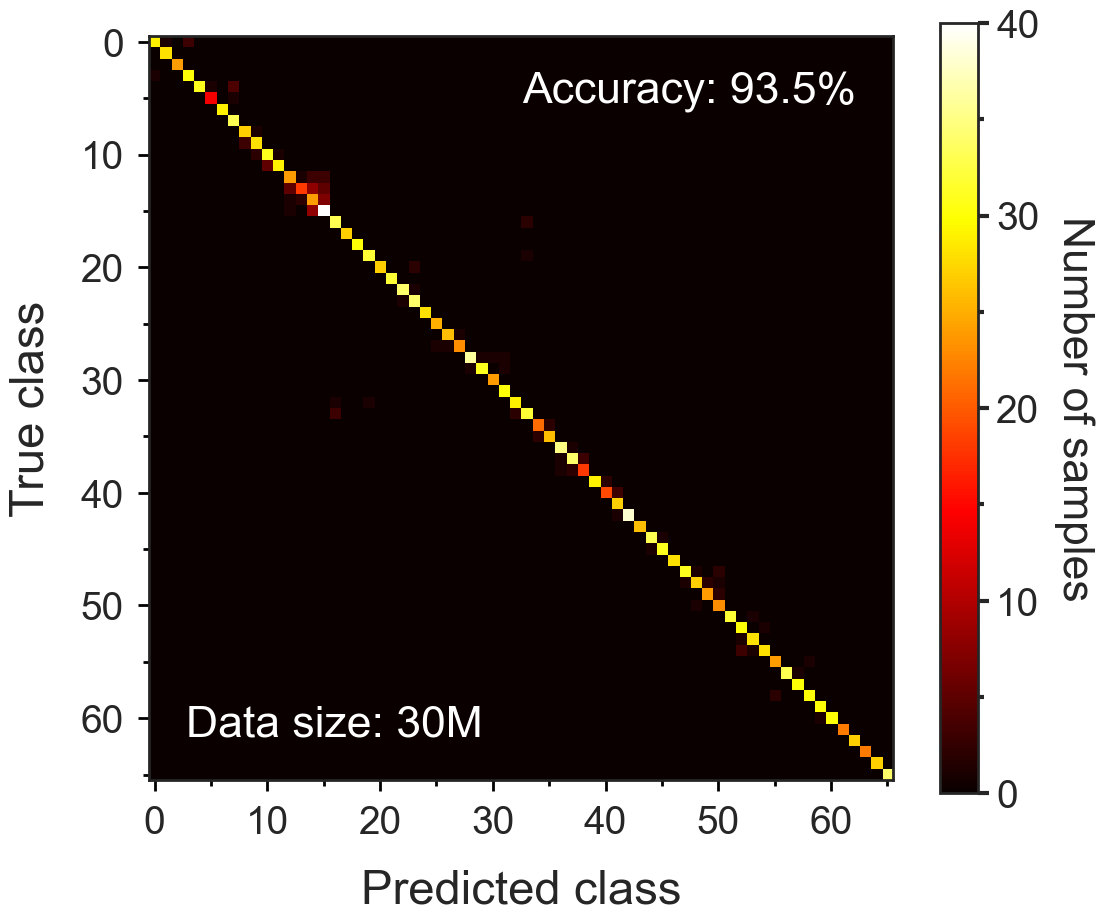

In [5]:
visual_embedding_dim = 50
prompt_type_list = ['full']

with open(os.path.join(cif_folder, 'test_dataset_1phase_orientation.npy'), 'rb') as handle:
    test_dataset = joblib.load(handle)
    
Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
Ys_int = [np.where(x==1)[0][0] for x in Ys]

for prompt_type in prompt_type_list:

    y_true, y_pred, y_formula, y_pred_full = [], [], [], []

    for i in range(len(element_list)):

        Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
        X_prompts = []
        random.shuffle(element_list[i])
        if prompt_type == None:
            X_prompts.append('')
        elif prompt_type == 'eds':
            X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
        elif prompt_type == 'full':
            X_prompts.append(' '.join(element_list[i]))

        visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

        inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
        inputs.update(
            {
                "visual_embeds": visual_embeds,
                "visual_token_type_ids": visual_token_type_ids,
                "visual_attention_mask": visual_attention_mask,
            }
        )

        labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

        outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))
        logits = outputs.logits
        y_true.append(np.array(labels).argmax(-1)[0])
        y_pred.append(np.array(logits.argmax(-1).detach().cpu())[0])
        y_pred_full.append(np.array(logits.detach().cpu()[0]))
        y_formula.append(formula_list[i])

        print(X_prompts,y_formula[-1],y_true[-1],y_pred[-1])

    y_pred_full = np.array(y_pred_full)

    report = classification_report(y_true, y_pred, target_names=dataloader.sample_list, output_dict=True)
    matrix = confusion_matrix(y_true, y_pred)

    load_plt_setting()
    fig, ax = plt.subplots(figsize=(12, 10))

    mat = ax.matshow(matrix, cmap='hot')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
    ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)

    cbar = plt.colorbar(mat)
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=28)
    cbar.ax.set_ylabel('Number of samples',labelpad=40, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

    ax.set_xlabel(r'Predicted class', labelpad=20, fontsize=34)
    ax.set_ylabel(r'True class', labelpad=20, fontsize=34)

    plt.text(0.95, 0.91, 'Accuracy: {:.1f}%'.format(report['accuracy']*100), fontsize=32, 
             transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
    if sample_size%1000000 == 0:
        data_size = str(int(sample_size//1000000))+'M'
    elif sample_size%1000 == 0:
        data_size = str(int(sample_size//1000))+'k'
    else:
        data_size = int(sample_size)
    plt.text(0.05, 0.06, 'Data size: {}'.format(data_size), fontsize=32, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='left')

## 2.2  Late fusion

Here we need to use Chem-XRD without any elemental inputs. To train the model, go to train.py Section 2.1, set  prompt_type_list = [None], change the model_folder to another name such as 'single_phase_no_elemental', and run the training. Or use the pretrained model we provided.

In [6]:
cif_folder = os.path.join(folder, 'cif')
sample_size = 3e7
try:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'model', 'single_phase_no_elemental','{}'.format(int(sample_size)))).to('cuda')
    print('Loading trained model.')
except:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'pretrained_model', 'single_phase_no_fusion')).to('cuda')
    print('Loading pretrained model from repository.')

Loading pretrained model from repository.


In [7]:
Chem_elements = []
Chem_samples = []

for i, sample in enumerate(dataloader.sample_list):
    elements = set(dataloader.dataset[sample]['element_list'])
    for j, Chem_element in enumerate(Chem_elements):
        if elements.issubset(Chem_element):
            Chem_samples[j][i] += 1
    if elements not in Chem_elements:
        Chem_elements.append(elements)
        Chem_samples_onehot = np.zeros((66))
        Chem_samples_onehot[i] += 1
        Chem_samples.append(Chem_samples_onehot)

for i, (x,y) in enumerate(zip(Chem_elements,Chem_samples)):
    print(x,y)

Chem_prob = []
for element in element_list:
    Chem_prob.append(Chem_samples[Chem_elements.index(set(element))])

Chem_prob = np.array(Chem_prob)

{'FA', 'Pb', 'Cs', 'Br'} [1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
{'FA', 'I', 'Pb', 'Cs'} [0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 1. 1. 1. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
{'Br', 'Pb', 'Cs', 'MA'} [0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 0. 0. 1. 0.]
{'I', 'Pb', 'Cs', 'MA'} [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 0. 0. 1. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1.]
{'Pb', 'Cs', 'Br'} [0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 1. 0. 1. 0. 0. 0. 0.
 0

[''] ['CsPb(I0.2Cl0.8)3'] 28 28
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['CsPb(I0.2Cl0.8)3'] 28 28
[''] ['alpha-FAPbI3'] 44 44
[''] ['CsPb(I0.6Cl0.4)3'] 30 30
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['tetragonal-MAPbI3'] 63 63
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['Cs0.2FA0.8PbI3'] 4 36
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['Cs0.6FA0.4PbBr3'] 2 2
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['Cs0.6MA0.4PbBr3'] 10 11
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['Cs0.6MA0.4PbI3'] 14 14
[''] ['MA0.8FA0.2PbBr3'] 50 50
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['Pnma-MAPbCl3'] 61 61
[''] ['Cs0.4MA0.6PbBr3'] 9 9
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['Cs0.6FA0.4PbI3'] 6 6
[''] ['Cs0.6MA0.4PbBr3'] 10 9
[''] ['Cs0.2MA0.8PbI3'] 12 13
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['MAPb(Br0.8I0.2)3'] 58 58
[''] ['delta

[''] ['CsPb(I0.8Br0.2)3'] 27 27
[''] ['Cs0.6FA0.4PbI3'] 6 6
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['CsPb(I0.2Cl0.8)3'] 28 28
[''] ['CsPb2Br5'] 19 19
[''] ['tetragonal-MAPbBr3'] 60 60
[''] ['CsPb(I0.2Br0.8)3'] 24 24
[''] ['PbBr2'] 64 64
[''] ['FAPb(Br0.8I0.2)3'] 42 65
[''] ['CsI'] 18 18
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['CsPb(Cl0.2Br0.8)3'] 20 20
[''] ['CsBr'] 17 17
[''] ['gamma-CsPbI3'] 38 38
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['CsI'] 18 18
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['MA0.8FA0.2PbI3'] 54 54
[''] ['Cs0.2MA0.8PbI3'] 12 12
[''] ['Cs0.4MA0.6PbI3'] 13 13
[''] ['Cs4PbBr6'] 16 16
[''] ['cubic-CsPbBr3'] 32 16
[''] ['Cs0.8MA0.2PbI3'] 15 15
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['beta-FAPbI3'] 45 45
[''] ['MAPb(Br0.8I0.2)3'] 58 58
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['Cs4PbBr6'] 16 16
[''] ['cubic-MAPbBr3'] 59 59
[''] ['PbBr2'] 64 64
[''] ['Cs4PbBr6'] 16 

[''] ['Cs0.2FA0.8PbI3'] 4 4
[''] ['CsPb2Br5'] 19 19
[''] ['CsBr'] 17 17
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Cs0.2MA0.8PbBr3'] 8 8
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Cs0.4MA0.6PbI3'] 13 15
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['FAPb(Br0.2I0.8)3'] 39 43
[''] ['alpha-FAPbI3'] 44 44
[''] ['cubic-CsPbCl3'] 35 35
[''] ['Cs0.8MA0.2PbI3'] 15 15
[''] ['CsPb(I0.6Cl0.4)3'] 30 30
[''] ['FAPb(Br0.6I0.4)3'] 41 41
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['CsBr'] 17 17
[''] ['MA0.2FA0.8PbBr3'] 47 50
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['CsPb(Cl0.8Br0.2)3'] 23 23
[''] ['Cs0.4MA0.6PbI3'] 13 13
[''] ['cubic-MAPbBr3'] 59 59
[''] ['Cs0.2FA0.8PbBr3'] 0 32
[''] ['alpha-CsPbI3'] 36 36
[''] ['Cs0.4MA0.6PbI3'] 13 13
[''] ['cubic-FAPbBr3'] 43 43
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] ['delta-FAPbI3'] 46 46
[''] ['cubic-MAPbBr3'] 59 59
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['MAPb(Br0.6I0.4)3'] 57 57
[''] ['Cs0.6MA0.4PbBr3'] 10 10
[''] ['Cs0.8FA0.2PbI3'] 7 7
['']

[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['MA0.6FA0.4PbBr3'] 49 49
[''] ['CsPb(Cl0.8Br0.2)3'] 23 23
[''] ['PbI2'] 65 65
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['cubic-MAPbBr3'] 59 59
[''] ['Cs0.2MA0.8PbBr3'] 8 8
[''] ['alpha-CsPbI3'] 36 36
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['Cs0.6MA0.4PbBr3'] 10 10
[''] ['Cs0.6MA0.4PbI3'] 14 14
[''] ['Cs0.2MA0.8PbI3'] 12 65
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['PbI2'] 65 65
[''] ['alpha-MAPbI3'] 62 62
[''] ['cubic-CsPbBr3'] 32 32
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['Pnma-CsPbCl3'] 34 34
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] ['Cs0.6FA0.4PbI3'] 6 5
[''] ['cubic-CsPbCl3'] 35 35
[''] ['Cs0.6MA0.4PbI3'] 14 14
[''] ['Cs0.4FA0.6PbI3'] 5 5
[''] ['FAPb(Br0.2I0.8)3'] 39 39
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['tetragonal-MAPbBr3'] 60 60
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] ['Cs0.8MA0.2PbI3'] 15 62
[''] ['Pnma-CsPbCl3'] 34 34
[''] ['cubic-CsPbBr3'] 32 32
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['alpha-FAPbI3'] 44 

[''] ['Cs0.2FA0.8PbBr3'] 0 1
[''] ['FAPb(Br0.6I0.4)3'] 41 41
[''] ['Cs0.8FA0.2PbI3'] 7 7
[''] ['MA0.2FA0.8PbI3'] 51 63
[''] ['Pnma-CsPbCl3'] 34 34
[''] ['CsPb(I0.2Br0.8)3'] 24 36
[''] ['MAPb(Br0.6I0.4)3'] 57 57
[''] ['CsBr'] 17 17
[''] ['CsPb(I0.4Cl0.6)3'] 29 29
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['PbI2'] 65 65
[''] ['Pnma-MAPbCl3'] 61 61
[''] ['alpha-FAPbI3'] 44 44
[''] ['MA0.8FA0.2PbBr3'] 50 50
[''] ['CsPb2Br5'] 19 19
[''] ['CsI'] 18 18
[''] ['Cs0.8FA0.2PbI3'] 7 7
[''] ['Cs0.2FA0.8PbI3'] 4 4
[''] ['cubic-MAPbBr3'] 59 59
[''] ['Cs0.8FA0.2PbBr3'] 3 3
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['beta-FAPbI3'] 45 45
[''] ['delta-FAPbI3'] 46 46
[''] ['cubic-FAPbBr3'] 43 43
[''] ['CsPb(I0.6Cl0.4)3'] 30 30
[''] ['CsPb(I0.4Cl0.6)3'] 29 29
[''] ['cubic-MAPbBr3'] 59 59
[''] ['alpha-CsPbI3'] 36 36
[''] ['MA0.6FA0.4PbBr3'] 49 49
[''] ['Pnma-CsPbCl3'] 34 34
[''] ['CsPb2Br5'] 19 19
[''] ['CsI'] 18 18
[''] ['Cs0.4FA0.6PbI3'] 5 5
[''] ['delta-CsPbI3'] 37 37
[''] ['Cs0.8MA0.2PbI

[''] ['Cs0.8FA0.2PbI3'] 7 7
[''] ['CsPb(I0.6Cl0.4)3'] 30 30
[''] ['Cs0.6MA0.4PbBr3'] 10 10
[''] ['cubic-MAPbBr3'] 59 59
[''] ['Cs4PbBr6'] 16 16
[''] ['alpha-CsPbI3'] 36 36
[''] ['Cs0.6FA0.4PbBr3'] 2 2
[''] ['PbBr2'] 64 64
[''] ['PbI2'] 65 65
[''] ['cubic-CsPbCl3'] 35 35
[''] ['CsPb(Cl0.2Br0.8)3'] 20 20
[''] ['gamma-CsPbI3'] 38 38
[''] ['CsBr'] 17 17
[''] ['Cs0.4MA0.6PbBr3'] 9 9
[''] ['Cs4PbBr6'] 16 16
[''] ['MAPb(Br0.2I0.8)3'] 55 55
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['cubic-CsPbBr3'] 32 32
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['Cs0.8FA0.2PbI3'] 7 7
[''] ['Cs0.4MA0.6PbBr3'] 9 9
[''] ['Cs0.6MA0.4PbBr3'] 10 10
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['MAPb(Br0.4I0.6)3'] 56 56
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['tetragonal-MAPbI3'] 63 63
[''] ['CsPb(I0.2Br0.8)3'] 24 24
[''] ['FAPb(Br0.4I0.6)3'] 40 43
[''] ['CsPb(Cl0.8Br0.2)3'] 23 23
[''] ['CsPb(I0.4Cl0.6)3'] 29 29
[''] ['Cs0.2MA0.8PbI3'] 12 15
[''] ['Cs0.2FA0.8PbBr3'] 0 1
[''] ['o

[''] ['Pnma-MAPbCl3'] 61 61
[''] ['cubic-CsPbCl3'] 35 34
[''] ['Cs4PbBr6'] 16 16
[''] ['Cs0.6FA0.4PbBr3'] 2 2
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['CsPb(I0.4Cl0.6)3'] 29 29
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['MA0.6FA0.4PbI3'] 53 51
[''] ['Cs0.6FA0.4PbBr3'] 2 2
[''] ['FAPb(Br0.8I0.2)3'] 42 42
[''] ['Cs0.8MA0.2PbI3'] 15 12
[''] ['MAPb(Br0.6I0.4)3'] 57 57
[''] ['MAPb(Br0.4I0.6)3'] 56 56
[''] ['CsI'] 18 18
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['cubic-CsPbBr3'] 32 32
[''] ['cubic-CsPbCl3'] 35 35
[''] ['Cs0.8MA0.2PbI3'] 15 15
[''] ['FAPb(Br0.6I0.4)3'] 41 45
[''] ['FAPb(Br0.2I0.8)3'] 39 39
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['Cs0.8FA0.2PbBr3'] 3 3
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['MAPb(Br0.4I0.6)3'] 56 56
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['MA0.8FA0.2PbBr3'] 50 50
[''] ['CsI'] 18 18
[''] ['CsPb(I0.6Cl0.4)3'] 30 30
[''] ['MAPb(Br0.8I0.2)3'] 58 58
[''] ['alpha-FAPbI3'] 44 44
[''] ['Cs0.2MA0.8PbBr3'] 8 8
[''] ['delta-CsPbI3'] 37 37
[''] ['PbI2'] 65 65
[''] ['Cs0.8FA0.2PbBr3'] 3 3
['']

[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['MA0.8FA0.2PbI3'] 54 54
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['MA0.8FA0.2PbI3'] 54 65
[''] ['Cs0.6FA0.4PbBr3'] 2 2
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['FAPb(Br0.2I0.8)3'] 39 39
[''] ['cubic-CsPbCl3'] 35 35
[''] ['Cs0.6MA0.4PbI3'] 14 14
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['FAPb(Br0.8I0.2)3'] 42 42
[''] ['Cs0.8FA0.2PbI3'] 7 7


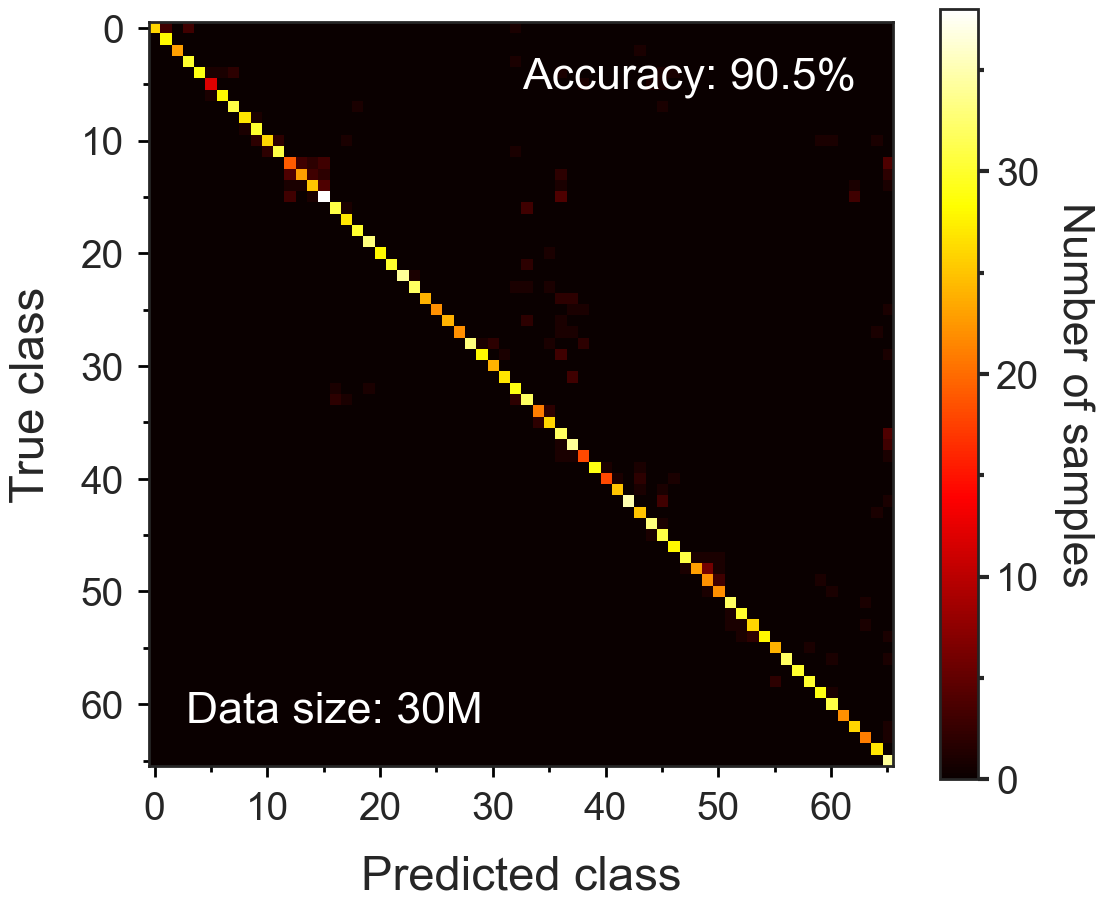

In [8]:
prompt_type_list = [None]

for prompt_type in prompt_type_list:

    y_true, y_pred, y_formula, y_pred_full = [], [], [], []

    for i in range(len(element_list)):

        Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
        X_prompts = []
        random.shuffle(element_list[i])
        if prompt_type == None:
            X_prompts.append('')
        elif prompt_type == 'eds':
            X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
        elif prompt_type == 'full':
            X_prompts.append(' '.join(element_list[i]))

        visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

        inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
        inputs.update(
            {
                "visual_embeds": visual_embeds,
                "visual_token_type_ids": visual_token_type_ids,
                "visual_attention_mask": visual_attention_mask,
            }
        )

        labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

        outputs = model(**inputs.to('cuda'), output_attentions=False, labels=labels.to('cuda'))
        logits = outputs.logits

        try:
            Ys_pred_full = np.array(logits.detach().cpu())*Chem_prob[i:i+1]
            Ys_pred_full[Ys_pred_full == 0] = 'nan'
            Ys_pred = np.nanargmax(Ys_pred_full,axis=1)
        except:
            Ys_pred_full = np.array(logits.detach().cpu()+0.000001)*Chem_prob[i:i+1]
            Ys_pred_full[Ys_pred_full == 0] = 'nan'
            Ys_pred = np.nanargmax(Ys_pred_full,axis=1)

        y_true.append(np.array(labels).argmax(-1)[0])
        y_pred.append(Ys_pred)
        y_pred_full.append(Ys_pred_full)
        y_formula.append(formula_list[i])

        print(X_prompts,y_formula[-1],y_true[-1],y_pred[-1][0])

    y_pred_full = np.array(y_pred_full)

    report = classification_report(y_true, y_pred, target_names=dataloader.sample_list, output_dict=True)
    matrix = confusion_matrix(y_true, y_pred)

    load_plt_setting()
    fig, ax = plt.subplots(figsize=(12, 10))

    mat = ax.matshow(matrix, cmap='hot')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
    ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)

    cbar = plt.colorbar(mat)
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=28)
    cbar.ax.set_ylabel('Number of samples',labelpad=40, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

    ax.set_xlabel(r'Predicted class', labelpad=20, fontsize=34)
    ax.set_ylabel(r'True class', labelpad=20, fontsize=34)

    plt.text(0.95, 0.91, 'Accuracy: {:.1f}%'.format(report['accuracy']*100), fontsize=32, 
             transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
    if sample_size%1000000 == 0:
        data_size = str(int(sample_size//1000000))+'M'
    elif sample_size%1000 == 0:
        data_size = str(int(sample_size//1000))+'k'
    else:
        data_size = int(sample_size)
    plt.text(0.05, 0.06, 'Data size: {}'.format(data_size), fontsize=32, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='left')

## 2.3 No fusion

In [9]:
cif_folder = os.path.join(folder, 'cif')
sample_size = 3e7
try:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'model', 'single_phase_no_elemental','{}'.format(int(sample_size)))).to('cuda')
    print('Loading trained model.')
except:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'pretrained_model', 'single_phase_no_fusion')).to('cuda')
    print('Loading pretrained model from repository.')

Loading pretrained model from repository.


[''] ['CsPb(I0.2Cl0.8)3'] 28 28
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['CsPb(I0.2Cl0.8)3'] 28 28
[''] ['alpha-FAPbI3'] 44 44
[''] ['CsPb(I0.6Cl0.4)3'] 30 30
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['tetragonal-MAPbI3'] 63 63
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['CsPb(I0.8Cl0.2)3'] 31 32
[''] ['Cs0.2FA0.8PbI3'] 4 53
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['Cs0.6FA0.4PbBr3'] 2 2
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['Cs0.6MA0.4PbBr3'] 10 11
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['Cs0.6MA0.4PbI3'] 14 43
[''] ['MA0.8FA0.2PbBr3'] 50 50
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['Pnma-MAPbCl3'] 61 61
[''] ['Cs0.4MA0.6PbBr3'] 9 9
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['Cs0.6FA0.4PbI3'] 6 6
[''] ['Cs0.6MA0.4PbBr3'] 10 9
[''] ['Cs0.2MA0.8PbI3'] 12 13
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['MAPb(Br0.8I0.2)3'] 58 58
[''] ['delta

[''] ['CsBr'] 17 17
[''] ['alpha-CsPbI3'] 36 36
[''] ['Cs0.6FA0.4PbBr3'] 2 9
[''] ['PbBr2'] 64 64
[''] ['Cs0.8FA0.2PbI3'] 7 7
[''] ['PbI2'] 65 65
[''] ['alpha-MAPbI3'] 62 62
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['CsPb(I0.8Br0.2)3'] 27 27
[''] ['Cs0.6FA0.4PbI3'] 6 6
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['CsPb(I0.2Cl0.8)3'] 28 47
[''] ['CsPb2Br5'] 19 19
[''] ['tetragonal-MAPbBr3'] 60 60
[''] ['CsPb(I0.2Br0.8)3'] 24 24
[''] ['PbBr2'] 64 64
[''] ['FAPb(Br0.8I0.2)3'] 42 50
[''] ['CsI'] 18 18
[''] ['CsPb(I0.6Br0.4)3'] 26 58
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['CsPb(Cl0.2Br0.8)3'] 20 26
[''] ['CsBr'] 17 17
[''] ['gamma-CsPbI3'] 38 1
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['CsI'] 18 30
[''] ['FAPb(Br0.4I0.6)3'] 40 40
[''] ['MA0.8FA0.2PbI3'] 54 54
[''] ['Cs0.2MA0.8PbI3'] 12 12
[''] ['Cs0.4MA0.6PbI3'] 13 13
[''] ['Cs4PbBr6'] 16 16
[''] ['cubic-CsPbBr3'] 32 14
[''] ['Cs0.8MA0.2PbI3'] 15 56
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['beta-FAPbI3'] 45 45
[''] ['MAPb(Br0.8I0.2)3'] 58 58
[''] ['Cs0.4FA0.6PbBr3'

[''] ['MA0.6FA0.4PbBr3'] 49 49
[''] ['CsPb(Cl0.2Br0.8)3'] 20 20
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['gamma-CsPbI3'] 38 38
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['tetragonal-MAPbBr3'] 60 60
[''] ['Cs0.6MA0.4PbI3'] 14 14
[''] ['tetragonal-MAPbI3'] 63 2
[''] ['Cs0.6FA0.4PbI3'] 6 6
[''] ['Cs0.2MA0.8PbBr3'] 8 2
[''] ['Cs0.2FA0.8PbI3'] 4 4
[''] ['CsPb2Br5'] 19 19
[''] ['CsBr'] 17 17
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Cs0.2MA0.8PbBr3'] 8 8
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Cs0.4MA0.6PbI3'] 13 59
[''] ['MA0.2FA0.8PbBr3'] 47 47
[''] ['FAPb(Br0.2I0.8)3'] 39 14
[''] ['alpha-FAPbI3'] 44 44
[''] ['cubic-CsPbCl3'] 35 35
[''] ['Cs0.8MA0.2PbI3'] 15 56
[''] ['CsPb(I0.6Cl0.4)3'] 30 30
[''] ['FAPb(Br0.6I0.4)3'] 41 41
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['CsBr'] 17 17
[''] ['MA0.2FA0.8PbBr3'] 47 50
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['CsPb(Cl0.8Br0.2)3'] 23 23
[''] ['Cs0.4MA0.6PbI3'] 13 13
[''] ['cubic-MAPbBr3'] 59 51
[''] ['Cs0.2FA0.8PbBr3'] 0 59
[''] ['alpha-CsPbI3'] 3

[''] ['Cs0.8MA0.2PbI3'] 15 12
[''] ['beta-FAPbI3'] 45 45
[''] ['CsPb(I0.4Cl0.6)3'] 29 29
[''] ['delta-CsPbI3'] 37 37
[''] ['MAPb(Br0.2I0.8)3'] 55 55
[''] ['MA0.6FA0.4PbBr3'] 49 49
[''] ['gamma-CsPbI3'] 38 38
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['orthorhombic-CsPbBr3'] 33 47
[''] ['MAPb(Br0.6I0.4)3'] 57 57
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['MA0.6FA0.4PbBr3'] 49 49
[''] ['CsPb(Cl0.8Br0.2)3'] 23 23
[''] ['PbI2'] 65 65
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['cubic-MAPbBr3'] 59 59
[''] ['Cs0.2MA0.8PbBr3'] 8 2
[''] ['alpha-CsPbI3'] 36 36
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['Cs0.6MA0.4PbBr3'] 10 10
[''] ['Cs0.6MA0.4PbI3'] 14 56
[''] ['Cs0.2MA0.8PbI3'] 12 50
[''] ['CsPb(I0.8Cl0.2)3'] 31 32
[''] ['PbI2'] 65 65
[''] ['alpha-MAPbI3'] 62 62
[''] ['cubic-CsPbBr3'] 32 32
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['Pnma-CsPbCl3'] 34 34
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] ['Cs0.6FA0.4PbI3'] 6 30
[''] ['cubic

[''] ['Cs0.6FA0.4PbI3'] 6 6
[''] ['delta-FAPbI3'] 46 46
[''] ['CsI'] 18 18
[''] ['orthorhombic-CsPbBr3'] 33 33
[''] ['delta-FAPbI3'] 46 46
[''] ['Cs0.4MA0.6PbI3'] 13 13
[''] ['alpha-CsPbI3'] 36 36
[''] ['CsPb(Cl0.4Br0.6)3'] 21 47
[''] ['CsPb(Cl0.2Br0.8)3'] 20 20
[''] ['cubic-FAPbBr3'] 43 43
[''] ['PbI2'] 65 65
[''] ['CsPb(Cl0.2Br0.8)3'] 20 20
[''] ['CsPb(Cl0.2Br0.8)3'] 20 20
[''] ['Cs0.2FA0.8PbBr3'] 0 1
[''] ['FAPb(Br0.6I0.4)3'] 41 41
[''] ['Cs0.8FA0.2PbI3'] 7 7
[''] ['MA0.2FA0.8PbI3'] 51 1
[''] ['Pnma-CsPbCl3'] 34 34
[''] ['CsPb(I0.2Br0.8)3'] 24 36
[''] ['MAPb(Br0.6I0.4)3'] 57 57
[''] ['CsBr'] 17 17
[''] ['CsPb(I0.4Cl0.6)3'] 29 29
[''] ['MA0.2FA0.8PbBr3'] 47 36
[''] ['PbI2'] 65 65
[''] ['Pnma-MAPbCl3'] 61 61
[''] ['alpha-FAPbI3'] 44 51
[''] ['MA0.8FA0.2PbBr3'] 50 50
[''] ['CsPb2Br5'] 19 19
[''] ['CsI'] 18 37
[''] ['Cs0.8FA0.2PbI3'] 7 7
[''] ['Cs0.2FA0.8PbI3'] 4 4
[''] ['cubic-MAPbBr3'] 59 59
[''] ['Cs0.8FA0.2PbBr3'] 3 10
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] 

[''] ['cubic-FAPbBr3'] 43 43
[''] ['Cs0.2FA0.8PbI3'] 4 4
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['alpha-CsPbI3'] 36 36
[''] ['CsBr'] 17 17
[''] ['cubic-CsPbCl3'] 35 56
[''] ['CsPb(I0.4Br0.6)3'] 25 25
[''] ['Cs0.4MA0.6PbI3'] 13 13
[''] ['tetragonal-MAPbBr3'] 60 60
[''] ['FAPb(Br0.2I0.8)3'] 39 39
[''] ['Cs0.2FA0.8PbI3'] 4 4
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['Cs0.8FA0.2PbI3'] 7 7
[''] ['CsPb(I0.6Cl0.4)3'] 30 2
[''] ['Cs0.6MA0.4PbBr3'] 10 10
[''] ['cubic-MAPbBr3'] 59 59
[''] ['Cs4PbBr6'] 16 16
[''] ['alpha-CsPbI3'] 36 36
[''] ['Cs0.6FA0.4PbBr3'] 2 2
[''] ['PbBr2'] 64 64
[''] ['PbI2'] 65 65
[''] ['cubic-CsPbCl3'] 35 35
[''] ['CsPb(Cl0.2Br0.8)3'] 20 20
[''] ['gamma-CsPbI3'] 38 38
[''] ['CsBr'] 17 17
[''] ['Cs0.4MA0.6PbBr3'] 9 9
[''] ['Cs4PbBr6'] 16 47
[''] ['MAPb(Br0.2I0.8)3'] 55 55
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['cubic-CsPbBr3'] 32 32
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['Cs0.4FA0.6PbBr3'] 1 1
[''] ['Cs0.8FA0.2PbI3'] 7 30
[''] ['Cs0.4MA0.6PbBr3'] 9 9
[''] 

[''] ['MAPb(Br0.4I0.6)3'] 56 56
[''] ['delta-FAPbI3'] 46 46
[''] ['CsPb(I0.8Br0.2)3'] 27 27
[''] ['CsI'] 18 18
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['CsPb2Br5'] 19 19
[''] ['MAPb(Br0.8I0.2)3'] 58 58
[''] ['FAPb(Br0.8I0.2)3'] 42 42
[''] ['CsPb(I0.2Cl0.8)3'] 28 28
[''] ['Cs0.6MA0.4PbBr3'] 10 53
[''] ['cubic-CsPbBr3'] 32 32
[''] ['CsPb2Br5'] 19 7
[''] ['MAPb(Br0.2I0.8)3'] 55 55
[''] ['Cs0.8MA0.2PbBr3'] 11 11
[''] ['Cs0.8FA0.2PbI3'] 7 7
[''] ['tetragonal-MAPbBr3'] 60 46
[''] ['CsBr'] 17 17
[''] ['cubic-MAPbBr3'] 59 1
[''] ['CsPb2Br5'] 19 19
[''] ['Cs0.2FA0.8PbI3'] 4 4
[''] ['Cs0.4MA0.6PbI3'] 13 59
[''] ['CsI'] 18 58
[''] ['CsPb(Cl0.4Br0.6)3'] 21 21
[''] ['Pnma-MAPbCl3'] 61 61
[''] ['cubic-CsPbCl3'] 35 36
[''] ['Cs4PbBr6'] 16 16
[''] ['Cs0.6FA0.4PbBr3'] 2 2
[''] ['CsPb(Cl0.6Br0.4)3'] 22 22
[''] ['CsPb(I0.4Cl0.6)3'] 29 29
[''] ['MA0.6FA0.4PbI3'] 53 53
[''] ['MA0.6FA0.4PbI3'] 53 43
[''] ['Cs0.6FA0.4PbBr3'] 2 58
[''] ['FAPb(Br0.8I0.2)3'] 42 42
[''] ['Cs0.8MA0.2PbI3'] 15 12
[''] ['MAPb(Br0.6I0.

[''] ['Cs0.4MA0.6PbBr3'] 9 9
[''] ['MA0.2FA0.8PbI3'] 51 51
[''] ['tetragonal-MAPbI3'] 63 63
[''] ['PbI2'] 65 65
[''] ['alpha-CsPbI3'] 36 36
[''] ['MA0.6FA0.4PbI3'] 53 48
[''] ['CsPb(Cl0.8Br0.2)3'] 23 23
[''] ['FAPb(Br0.6I0.4)3'] 41 41
[''] ['Cs0.6FA0.4PbBr3'] 2 8
[''] ['Cs0.8FA0.2PbI3'] 7 7
[''] ['Cs0.4FA0.6PbBr3'] 1 30
[''] ['MA0.8FA0.2PbBr3'] 50 50
[''] ['beta-FAPbI3'] 45 45
[''] ['CsPb(I0.4Br0.6)3'] 25 25
[''] ['Cs0.2MA0.8PbBr3'] 8 8
[''] ['MA0.4FA0.6PbBr3'] 48 48
[''] ['MA0.8FA0.2PbI3'] 54 49
[''] ['CsPb(I0.6Br0.4)3'] 26 14
[''] ['Cs0.2FA0.8PbBr3'] 0 0
[''] ['MA0.8FA0.2PbI3'] 54 49
[''] ['Cs0.6FA0.4PbBr3'] 2 2
[''] ['MA0.4FA0.6PbI3'] 52 52
[''] ['FAPb(Br0.2I0.8)3'] 39 39
[''] ['cubic-CsPbCl3'] 35 60
[''] ['Cs0.6MA0.4PbI3'] 14 14
[''] ['CsPb(I0.6Br0.4)3'] 26 26
[''] ['CsPb(I0.8Cl0.2)3'] 31 31
[''] ['FAPb(Br0.8I0.2)3'] 42 42
[''] ['Cs0.8FA0.2PbI3'] 7 7


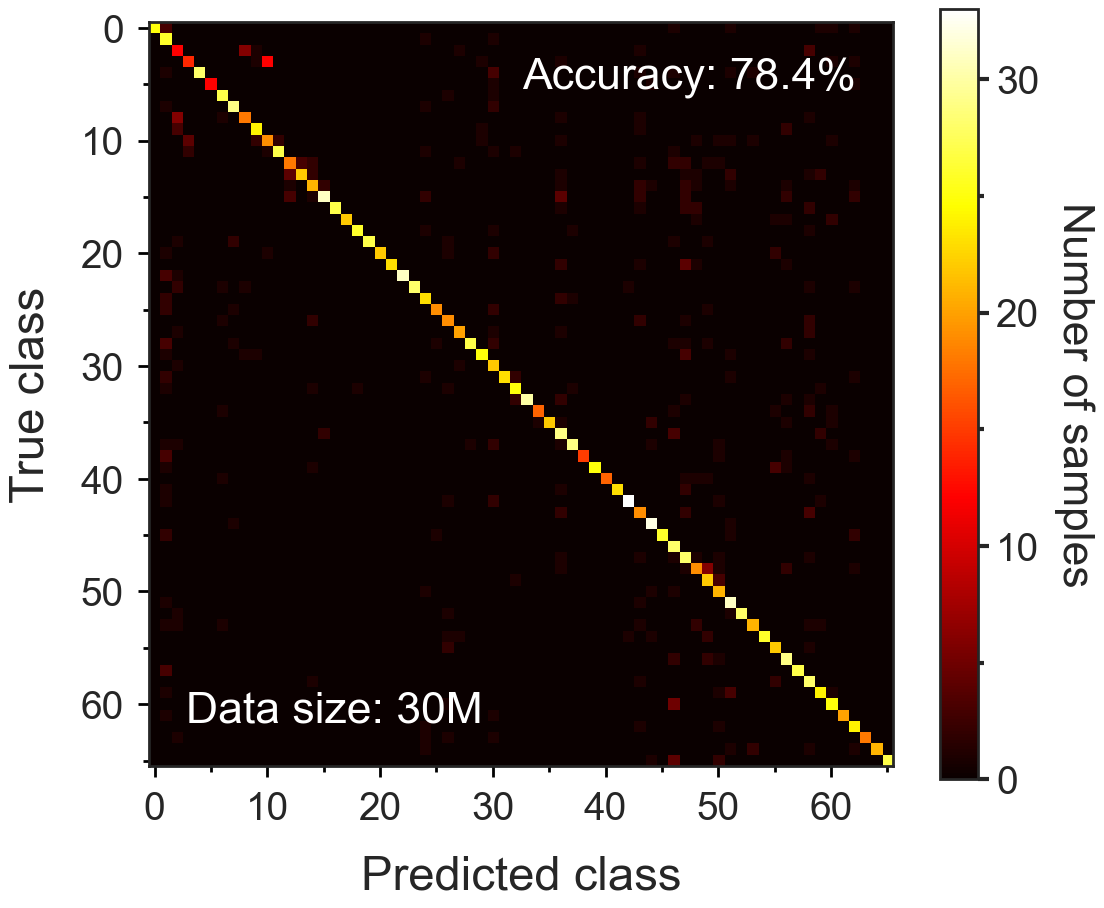

In [10]:
visual_embedding_dim = 50
prompt_type_list = [None]

with open(os.path.join(cif_folder, 'test_dataset_1phase_orientation.npy'), 'rb') as handle:
    test_dataset = joblib.load(handle)
    
Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
Ys_int = [np.where(x==1)[0][0] for x in Ys]

for prompt_type in prompt_type_list:

    y_true, y_pred, y_formula, y_pred_full = [], [], [], []

    for i in range(len(element_list)):

        Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))
        X_prompts = []
        random.shuffle(element_list[i])
        if prompt_type == None:
            X_prompts.append('')
        elif prompt_type == 'eds':
            X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
        elif prompt_type == 'full':
            X_prompts.append(' '.join(element_list[i]))

        visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
        visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
        visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

        inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
        inputs.update(
            {
                "visual_embeds": visual_embeds,
                "visual_token_type_ids": visual_token_type_ids,
                "visual_attention_mask": visual_attention_mask,
            }
        )

        labels = torch.from_numpy(np.array(Ys[i:i+1])).to(dtype=torch.float32)

        outputs = model(**inputs.to('cuda'), output_attentions=True, labels=labels.to('cuda'))
        logits = outputs.logits
        y_true.append(np.array(labels).argmax(-1)[0])
        y_pred.append(np.array(logits.argmax(-1).detach().cpu())[0])
        y_pred_full.append(np.array(logits.detach().cpu()[0]))
        y_formula.append(formula_list[i])

        print(X_prompts,y_formula[-1],y_true[-1],y_pred[-1])

    y_pred_full = np.array(y_pred_full)

    report = classification_report(y_true, y_pred, target_names=dataloader.sample_list, output_dict=True)
    matrix = confusion_matrix(y_true, y_pred)

    load_plt_setting()
    fig, ax = plt.subplots(figsize=(12, 10))

    mat = ax.matshow(matrix, cmap='hot')
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
    ax.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=10, steps=[1, 2, 5, 10]))
    ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28)
    ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28)

    cbar = plt.colorbar(mat)
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=28)
    cbar.ax.set_ylabel('Number of samples',labelpad=40, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=4, integer=True, steps=[1, 2, 5, 10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

    ax.set_xlabel(r'Predicted class', labelpad=20, fontsize=34)
    ax.set_ylabel(r'True class', labelpad=20, fontsize=34)

    plt.text(0.95, 0.91, 'Accuracy: {:.1f}%'.format(report['accuracy']*100), fontsize=32, 
             transform=ax.transAxes, color='#FFFFFF', horizontalalignment='right')
    if sample_size%1000000 == 0:
        data_size = str(int(sample_size//1000000))+'M'
    elif sample_size%1000 == 0:
        data_size = str(int(sample_size//1000))+'k'
    else:
        data_size = int(sample_size)
    plt.text(0.05, 0.06, 'Data size: {}'.format(data_size), fontsize=32, transform=ax.transAxes, color='#FFFFFF', horizontalalignment='left')

# 3 Multi phase classification

In [11]:
cif_folder = os.path.join(folder, 'cif')
sample_size = 3e7
try:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'model', 'multi_phase','{}'.format(int(sample_size)))).to('cuda')
    print('Loading trained model.')
except:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'pretrained_model', 'multi_phase')).to('cuda')
    print('Loading pretrained model from repository.')

Loading pretrained model from repository.


In [12]:
full_result = {}
prompt_type_list = ['none','eds','full']
n_mix = [1,2,3]
random_phase = True

for prompt_type in prompt_type_list:
    full_result[prompt_type] = {}
    if random_phase:
        for n in n_mix:
            full_result[prompt_type]['{}'.format(n)] = {'y_true':[], 'y_pred':[], 'y_acc':[], 'n_true':[], 'n_pred':[], 'n_acc':[]}
    else:
        for n in n_mix:
            full_result[prompt_type]['{}'.format(n)] = {'y_true':[], 'y_pred':[], 'y_acc':[]}

In [13]:
for n in n_mix:
    
    file_name = 'test_dataset_{}phase_orientation.npy'.format(n)
    
    try:
        with open(os.path.join(cif_folder, file_name), 'rb') as handle:
            test_dataset = joblib.load(handle)

        Xs, Ys, element_list, formula_list = test_dataset['Xs'], test_dataset['Ys'], test_dataset['element_list'], test_dataset['formula_list']
        print('test dataset loaded.')

    except:
        Xs, Ys, element_list, formula_list, _ = dataloader.load_data(batch_size=2000, n_mix=[n], resonable_mixing=True,
                                                                  high_orientation_probability=0.2, crystal_size_range=(5, 20), 
                                                                  intensity_variation_range=(0.01, 1))
        test_dataset = {'Xs':Xs, 'Ys':Ys, 'element_list':element_list, 'formula_list':formula_list}

        with open(os.path.join(cif_folder, file_name), 'wb') as handle:
            joblib.dump(test_dataset, handle)
        print('test dataset generated.')

    print(np.sum(Ys,axis=0))

    if random_phase:
        n_mix_list_onehot = np.zeros((Ys.shape[0], len(n_mix)))
        n_mix_list_onehot[np.arange(Ys.shape[0]), n_mix.index(n)] = 1
        Ys = np.concatenate((Ys,n_mix_list_onehot),axis=1)

    for prompt_type in prompt_type_list:

        for i in range(len(element_list)):

            Xs_test = Xs[i:i+1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

            X_prompts = []
            random.shuffle(element_list[i])
            if prompt_type == 'none':
                X_prompts.append('')
            elif prompt_type == 'eds':
                X_prompts.append(' '.join([element for element in element_list[i] if element not in ['FA', 'MA']]))
            elif prompt_type == 'full':
                X_prompts.append(' '.join(element_list[i]))

            visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
            visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
            visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

            inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
            inputs.update(
                {
                    "visual_embeds": visual_embeds,
                    "visual_token_type_ids": visual_token_type_ids,
                    "visual_attention_mask": visual_attention_mask,
                }
            )

            labels = torch.from_numpy(Ys[i:i+1]).to(dtype=torch.float32)
            outputs = model(**inputs.to('cuda'), output_attentions=True)
            
            if random_phase:
                y_true = np.array(Ys[i:i+1])[0,:-len(n_mix)]
                y_pred = np.array(outputs.logits.detach().cpu())[0,:-len(n_mix)]
                n_true = np.array(Ys[i:i+1])[0,-len(n_mix):]
                n_pred = np.array(outputs.logits.detach().cpu())[0,-len(n_mix):]
                n_true_idx = np.where(n_true!=0)[0]
                n_pred_idx = np.argpartition(n_pred,-1)[-1:]
                
                if set(list(n_true_idx)) == set(list(n_pred_idx)):
                    full_result[prompt_type]['{}'.format(n)]['n_acc'].append(0)
                else:
                    full_result[prompt_type]['{}'.format(n)]['n_acc'].append(1)
                    
                full_result[prompt_type]['{}'.format(n)]['n_true'].append(n_true)
                full_result[prompt_type]['{}'.format(n)]['n_pred'].append(n_pred)
            else:
                y_true = np.array(Ys[i:i+1])[0]
                y_pred = np.array(outputs.logits.detach().cpu())[0]
            
            y_true_idx = np.where(y_true!=0)[0]
            y_pred_idx = np.argpartition(y_pred,-n)[-n:]
            
            if set(list(y_true_idx)) == set(list(y_pred_idx)):
                full_result[prompt_type]['{}'.format(n)]['y_acc'].append(0)
            else:
                full_result[prompt_type]['{}'.format(n)]['y_acc'].append(1)
                
            full_result[prompt_type]['{}'.format(n)]['y_true'].append(y_true)
            full_result[prompt_type]['{}'.format(n)]['y_pred'].append(y_pred)
            
            if random_phase:
                print(i,formula_list[i],y_true_idx,y_pred_idx,n_true_idx,n_pred_idx)
            else:
                print(i,formula_list[i],y_true_idx,y_pred_idx)

test dataset loaded.
[33. 28. 24. 31. 36. 15. 29. 33. 28. 31. 34. 34. 31. 36. 34. 49. 35. 27.
 30. 33. 29. 32. 35. 35. 28. 25. 27. 25. 39. 33. 24. 30. 31. 37. 23. 28.
 36. 38. 21. 31. 22. 27. 39. 26. 34. 32. 28. 34. 31. 26. 24. 33. 31. 29.
 32. 25. 34. 30. 32. 30. 31. 22. 27. 22. 27. 34.]
0 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
1 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
2 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
3 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
4 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
5 ['alpha-FAPbI3'] [44] [44] [0] [1]
6 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
7 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [0]
8 ['MA0.6FA0.4PbI3'] [53] [53] [0] [0]
9 ['MA0.4FA0.6PbBr3'] [48] [48] [0] [0]
10 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
11 ['tetragonal-MAPbI3'] [63] [63] [0] [0]
12 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [1]
13 ['CsPb(I0.8Cl0.2)3'] [31] [15] [0] [0]
14 ['Cs0.2FA0.8PbI3'] [4] [15] [0] [0]
15 ['MA0.6FA0.4PbI3'] [53] [53] [0] [0]
16 ['Cs0.6FA0.4PbBr3'] [2] [2] [0] [0]
17 ['Cs0.2FA0.8

200 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
201 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
202 ['cubic-FAPbBr3'] [43] [43] [0] [0]
203 ['CsPb2Br5'] [19] [19] [0] [0]
204 ['Pnma-MAPbCl3'] [61] [61] [0] [0]
205 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
206 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
207 ['Cs0.2FA0.8PbI3'] [4] [46] [0] [0]
208 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [1]
209 ['alpha-FAPbI3'] [44] [20] [0] [0]
210 ['cubic-MAPbBr3'] [59] [59] [0] [0]
211 ['cubic-CsPbCl3'] [35] [35] [0] [0]
212 ['CsPb(I0.2Cl0.8)3'] [28] [56] [0] [0]
213 ['CsPb(Cl0.8Br0.2)3'] [23] [55] [0] [0]
214 ['Cs0.8FA0.2PbBr3'] [3] [11] [0] [0]
215 ['alpha-MAPbI3'] [62] [62] [0] [1]
216 ['alpha-FAPbI3'] [44] [44] [0] [0]
217 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
218 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
219 ['Cs0.8FA0.2PbBr3'] [3] [29] [0] [0]
220 ['Cs0.6MA0.4PbI3'] [14] [13] [0] [0]
221 ['Cs4PbBr6'] [16] [56] [0] [0]
222 ['gamma-CsPbI3'] [38] [38] [0] [0]
223 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
224 ['tetragonal-MAPbI3'] [6

407 ['CsPb(I0.4Br0.6)3'] [25] [25] [0] [0]
408 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
409 ['delta-CsPbI3'] [37] [37] [0] [0]
410 ['Cs4PbBr6'] [16] [16] [0] [0]
411 ['Cs0.8MA0.2PbI3'] [15] [24] [0] [0]
412 ['CsPb(I0.4Br0.6)3'] [25] [25] [0] [0]
413 ['alpha-FAPbI3'] [44] [44] [0] [0]
414 ['Cs0.6FA0.4PbBr3'] [2] [2] [0] [0]
415 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
416 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
417 ['Cs0.4MA0.6PbI3'] [13] [14] [0] [1]
418 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
419 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
420 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
421 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
422 ['FAPb(Br0.6I0.4)3'] [41] [41] [0] [0]
423 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
424 ['MA0.4FA0.6PbBr3'] [48] [50] [0] [0]
425 ['alpha-FAPbI3'] [44] [44] [0] [1]
426 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
427 ['MA0.6FA0.4PbBr3'] [49] [49] [0] [0]
428 ['FAPb(Br0.6I0.4)3'] [41] [41] [0] [0]
429 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
430 ['PbBr2'] [64] [36] [0] [0]
431 ['MA0.2F

616 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
617 ['PbI2'] [65] [65] [0] [1]
618 ['Cs0.6MA0.4PbBr3'] [10] [10] [0] [1]
619 ['orthorhombic-CsPbBr3'] [33] [41] [0] [0]
620 ['PbBr2'] [64] [64] [0] [0]
621 ['Cs0.8FA0.2PbBr3'] [3] [3] [0] [0]
622 ['Cs4PbBr6'] [16] [16] [0] [0]
623 ['cubic-FAPbBr3'] [43] [58] [0] [0]
624 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
625 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
626 ['Cs0.6MA0.4PbI3'] [14] [13] [0] [0]
627 ['cubic-MAPbBr3'] [59] [59] [0] [0]
628 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
629 ['CsPb2Br5'] [19] [19] [0] [0]
630 ['MA0.6FA0.4PbBr3'] [49] [49] [0] [0]
631 ['cubic-MAPbBr3'] [59] [59] [0] [0]
632 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
633 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
634 ['delta-CsPbI3'] [37] [37] [0] [0]
635 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
636 ['Cs0.2MA0.8PbI3'] [12] [12] [0] [1]
637 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [0]
638 ['beta-FAPbI3'] [45] [45] [0] [0]
639 ['MA0.8FA0.2PbI3'] [54] [54] [0] [0]
640 ['MA0.4FA0.6PbBr3'] [48] [40] [0

827 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
828 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
829 ['CsPb(I0.8Br0.2)3'] [27] [58] [0] [0]
830 ['CsPb(I0.4Br0.6)3'] [25] [46] [0] [0]
831 ['MA0.6FA0.4PbBr3'] [49] [49] [0] [0]
832 ['alpha-CsPbI3'] [36] [51] [0] [0]
833 ['alpha-CsPbI3'] [36] [36] [0] [1]
834 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
835 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
836 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
837 ['alpha-MAPbI3'] [62] [62] [0] [1]
838 ['alpha-CsPbI3'] [36] [14] [0] [0]
839 ['Cs0.6MA0.4PbBr3'] [10] [10] [0] [0]
840 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [1]
841 ['gamma-CsPbI3'] [38] [38] [0] [0]
842 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
843 ['Cs0.8MA0.2PbI3'] [15] [13] [0] [0]
844 ['beta-FAPbI3'] [45] [45] [0] [0]
845 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
846 ['delta-CsPbI3'] [37] [37] [0] [0]
847 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
848 ['MA0.6FA0.4PbBr3'] [49] [49] [0] [0]
849 ['gamma-CsPbI3'] [38] [38] [0] [0]
850 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
851 

1037 ['FAPb(Br0.4I0.6)3'] [40] [40] [0] [0]
1038 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
1039 ['Cs0.6FA0.4PbI3'] [6] [6] [0] [0]
1040 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [1]
1041 ['PbI2'] [65] [44] [0] [0]
1042 ['beta-FAPbI3'] [45] [45] [0] [0]
1043 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
1044 ['delta-CsPbI3'] [37] [37] [0] [0]
1045 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
1046 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1047 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
1048 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
1049 ['CsPb(I0.8Cl0.2)3'] [31] [31] [0] [1]
1050 ['Cs0.2FA0.8PbI3'] [4] [4] [0] [0]
1051 ['tetragonal-MAPbI3'] [63] [20] [0] [0]
1052 ['FAPb(Br0.6I0.4)3'] [41] [41] [0] [0]
1053 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
1054 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
1055 ['Pnma-CsPbCl3'] [34] [34] [0] [0]
1056 ['Cs0.2FA0.8PbI3'] [4] [4] [0] [0]
1057 ['Cs4PbBr6'] [16] [43] [0] [0]
1058 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
1059 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
1060 ['Cs0.2FA0.8PbBr3'] [0] [2

1244 ['delta-CsPbI3'] [37] [7] [0] [0]
1245 ['Cs0.2MA0.8PbI3'] [12] [23] [0] [0]
1246 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
1247 ['Cs0.2MA0.8PbI3'] [12] [13] [0] [0]
1248 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1249 ['Cs0.2MA0.8PbI3'] [12] [43] [0] [0]
1250 ['CsI'] [18] [18] [0] [0]
1251 ['PbI2'] [65] [65] [0] [0]
1252 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
1253 ['Cs0.8FA0.2PbBr3'] [3] [3] [0] [0]
1254 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
1255 ['CsPb(I0.6Cl0.4)3'] [30] [23] [0] [0]
1256 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
1257 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
1258 ['FAPb(Br0.2I0.8)3'] [39] [39] [0] [0]
1259 ['alpha-FAPbI3'] [44] [44] [0] [0]
1260 ['cubic-FAPbBr3'] [43] [43] [0] [0]
1261 ['tetragonal-MAPbI3'] [63] [63] [0] [0]
1262 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
1263 ['alpha-CsPbI3'] [36] [36] [0] [1]
1264 ['MA0.4FA0.6PbBr3'] [48] [41] [0] [0]
1265 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
1266 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
1267 ['Cs0.2FA0.8PbI3'] [4] [4] [0] [0]
1268

1444 ['MAPb(Br0.4I0.6)3'] [56] [56] [0] [0]
1445 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
1446 ['tetragonal-MAPbI3'] [63] [63] [0] [0]
1447 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
1448 ['FAPb(Br0.4I0.6)3'] [40] [41] [0] [0]
1449 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
1450 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
1451 ['Cs0.2MA0.8PbI3'] [12] [41] [0] [0]
1452 ['Cs0.2FA0.8PbBr3'] [0] [41] [0] [0]
1453 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
1454 ['FAPb(Br0.2I0.8)3'] [39] [39] [0] [0]
1455 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [1]
1456 ['CsPb(I0.4Br0.6)3'] [25] [7] [0] [0]
1457 ['Cs0.6MA0.4PbBr3'] [10] [29] [0] [0]
1458 ['MAPb(Br0.4I0.6)3'] [56] [46] [0] [0]
1459 ['cubic-CsPbBr3'] [32] [32] [0] [0]
1460 ['Cs0.6MA0.4PbI3'] [14] [13] [0] [0]
1461 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
1462 ['Cs0.8FA0.2PbBr3'] [3] [3] [0] [1]
1463 ['delta-FAPbI3'] [46] [46] [0] [0]
1464 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [0]
1465 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
1466 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
1467 ['MA0.

1651 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
1652 ['tetragonal-MAPbI3'] [63] [20] [0] [0]
1653 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
1654 ['Cs0.2MA0.8PbBr3'] [8] [23] [0] [0]
1655 ['CsBr'] [17] [17] [0] [0]
1656 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
1657 ['alpha-FAPbI3'] [44] [44] [0] [1]
1658 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
1659 ['Cs0.8FA0.2PbBr3'] [3] [56] [0] [0]
1660 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1661 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
1662 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
1663 ['Cs0.6MA0.4PbBr3'] [10] [50] [0] [0]
1664 ['CsPb(I0.4Br0.6)3'] [25] [25] [0] [0]
1665 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
1666 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
1667 ['Cs0.8FA0.2PbBr3'] [3] [3] [0] [0]
1668 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
1669 ['Cs4PbBr6'] [16] [16] [0] [0]
1670 ['Cs0.8FA0.2PbBr3'] [3] [3] [0] [0]
1671 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
1672 ['CsPb(I0.4Br0.6)3'] [25] [25] [0] [0]
1673 ['alpha-CsPbI3'] [36] [36] [0] [1]
1674 ['Cs0.2MA0.8PbBr3'] [

1856 ['Cs0.6MA0.4PbBr3'] [10] [10] [0] [1]
1857 ['Cs4PbBr6'] [16] [16] [0] [0]
1858 ['CsPb(Cl0.6Br0.4)3'] [22] [18] [0] [0]
1859 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
1860 ['gamma-CsPbI3'] [38] [44] [0] [0]
1861 ['Cs0.6MA0.4PbI3'] [14] [14] [0] [0]
1862 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
1863 ['Cs0.6MA0.4PbBr3'] [10] [29] [0] [0]
1864 ['Pnma-CsPbCl3'] [34] [58] [0] [0]
1865 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
1866 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
1867 ['delta-FAPbI3'] [46] [46] [0] [0]
1868 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [1]
1869 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
1870 ['cubic-CsPbCl3'] [35] [35] [0] [0]
1871 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1872 ['Cs0.2MA0.8PbBr3'] [8] [2] [0] [0]
1873 ['Cs0.6FA0.4PbI3'] [6] [6] [0] [0]
1874 ['gamma-CsPbI3'] [38] [38] [0] [0]
1875 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [1]
1876 ['Cs0.8MA0.2PbI3'] [15] [36] [0] [0]
1877 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
1878 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1879 ['gamma-CsPbI3']

61 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
62 ['delta-FAPbI3'] [46] [46] [0] [0]
63 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
64 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
65 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [0]
66 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
67 ['alpha-FAPbI3'] [44] [44] [0] [0]
68 ['beta-FAPbI3'] [45] [62] [0] [0]
69 ['Cs0.6MA0.4PbBr3'] [10] [3] [0] [0]
70 ['Cs4PbBr6'] [16] [16] [0] [0]
71 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
72 ['CsPb2Br5'] [19] [19] [0] [0]
73 ['Cs0.8MA0.2PbI3'] [15] [15] [0] [0]
74 ['delta-CsPbI3'] [37] [37] [0] [0]
75 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
76 ['PbBr2'] [64] [64] [0] [0]
77 ['cubic-FAPbBr3'] [43] [43] [0] [0]
78 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
79 ['delta-CsPbI3'] [37] [37] [0] [0]
80 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
81 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
82 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
83 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
84 ['MA0.6FA0.4PbBr3'] [49] [49] [0] [0]
85 ['Cs0.2MA0.8PbBr3'] [8] [33] [0] [0]
86 ['Cs0.

276 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
277 ['cubic-CsPbBr3'] [32] [32] [0] [0]
278 ['CsBr'] [17] [17] [0] [0]
279 ['alpha-CsPbI3'] [36] [15] [0] [0]
280 ['Cs0.6FA0.4PbBr3'] [2] [9] [0] [0]
281 ['PbBr2'] [64] [64] [0] [0]
282 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
283 ['PbI2'] [65] [65] [0] [0]
284 ['alpha-MAPbI3'] [62] [62] [0] [0]
285 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [0]
286 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
287 ['Cs0.6FA0.4PbI3'] [6] [6] [0] [0]
288 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
289 ['CsPb(I0.2Cl0.8)3'] [28] [29] [0] [0]
290 ['CsPb2Br5'] [19] [19] [0] [0]
291 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
292 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
293 ['PbBr2'] [64] [64] [0] [0]
294 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
295 ['CsI'] [18] [18] [0] [0]
296 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [0]
297 ['MA0.6FA0.4PbI3'] [53] [53] [0] [0]
298 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
299 ['CsBr'] [17] [17] [0] [0]
300 ['gamma-CsPbI3'] [38] [38] [0] [0]
301 ['Cs0.8MA0.2PbBr3'] [11] [1

483 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
484 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
485 ['Cs0.8MA0.2PbBr3'] [11] [32] [0] [0]
486 ['CsI'] [18] [18] [0] [0]
487 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
488 ['Cs0.6MA0.4PbI3'] [14] [36] [0] [0]
489 ['cubic-CsPbBr3'] [32] [32] [0] [0]
490 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [0]
491 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
492 ['delta-CsPbI3'] [37] [37] [0] [0]
493 ['beta-FAPbI3'] [45] [62] [0] [0]
494 ['delta-FAPbI3'] [46] [46] [0] [0]
495 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
496 ['gamma-CsPbI3'] [38] [38] [0] [0]
497 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [1]
498 ['CsPb(I0.2Br0.8)3'] [24] [25] [0] [0]
499 ['Cs0.2MA0.8PbBr3'] [8] [8] [0] [0]
500 ['CsI'] [18] [18] [0] [0]
501 ['PbBr2'] [64] [64] [0] [0]
502 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
503 ['FAPb(Br0.4I0.6)3'] [40] [40] [0] [0]
504 ['CsI'] [18] [18] [0] [0]
505 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [0]
506 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [0]
507 ['CsPb(I0.8Br0.2)3'] [27] [26] [0] [0]
508 ['FA

685 ['alpha-MAPbI3'] [62] [62] [0] [0]
686 ['Cs0.6FA0.4PbBr3'] [2] [8] [0] [0]
687 ['CsPb(Cl0.2Br0.8)3'] [20] [23] [0] [0]
688 ['FAPb(Br0.6I0.4)3'] [41] [41] [0] [0]
689 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [0]
690 ['Cs0.6FA0.4PbBr3'] [2] [2] [0] [0]
691 ['MA0.4FA0.6PbBr3'] [48] [47] [0] [0]
692 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [1]
693 ['alpha-FAPbI3'] [44] [44] [0] [0]
694 ['cubic-FAPbBr3'] [43] [43] [0] [0]
695 ['alpha-CsPbI3'] [36] [36] [0] [0]
696 ['MA0.4FA0.6PbI3'] [52] [44] [0] [0]
697 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
698 ['gamma-CsPbI3'] [38] [38] [0] [0]
699 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
700 ['MA0.8FA0.2PbI3'] [54] [54] [0] [0]
701 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
702 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
703 ['Cs0.6FA0.4PbI3'] [6] [6] [0] [0]
704 ['Pnma-CsPbCl3'] [34] [34] [0] [0]
705 ['FAPb(Br0.4I0.6)3'] [40] [40] [0] [0]
706 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
707 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
708 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
709 ['MA0.8

892 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
893 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
894 ['Cs0.6MA0.4PbI3'] [14] [38] [0] [0]
895 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
896 ['Cs0.2MA0.8PbI3'] [12] [12] [0] [1]
897 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
898 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
899 ['CsBr'] [17] [17] [0] [0]
900 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
901 ['cubic-FAPbBr3'] [43] [47] [0] [0]
902 ['CsI'] [18] [18] [0] [0]
903 ['CsI'] [18] [18] [0] [0]
904 ['alpha-FAPbI3'] [44] [44] [0] [0]
905 ['CsI'] [18] [18] [0] [0]
906 ['alpha-FAPbI3'] [44] [44] [0] [0]
907 ['CsBr'] [17] [17] [0] [0]
908 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
909 ['FAPb(Br0.4I0.6)3'] [40] [41] [0] [0]
910 ['FAPb(Br0.6I0.4)3'] [41] [41] [0] [0]
911 ['Cs0.4MA0.6PbI3'] [13] [15] [0] [0]
912 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
913 ['alpha-MAPbI3'] [62] [62] [0] [0]
914 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
915 ['Pnma-CsPbCl3'] [34] [34] [0] [0]
916 ['MAPb(Br0.4I0.6)3'] [56] [56] [0] [0]
917 ['MA0.4FA0.6PbI

1100 ['MA0.6FA0.4PbBr3'] [49] [49] [0] [0]
1101 ['Cs4PbBr6'] [16] [16] [0] [0]
1102 ['Cs0.2MA0.8PbI3'] [12] [12] [0] [0]
1103 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1104 ['FAPb(Br0.6I0.4)3'] [41] [41] [0] [0]
1105 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
1106 ['cubic-CsPbBr3'] [32] [32] [0] [0]
1107 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
1108 ['CsPb2Br5'] [19] [19] [0] [0]
1109 ['MA0.4FA0.6PbBr3'] [48] [48] [0] [0]
1110 ['MA0.8FA0.2PbI3'] [54] [54] [0] [0]
1111 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [0]
1112 ['MA0.6FA0.4PbBr3'] [49] [49] [0] [0]
1113 ['alpha-CsPbI3'] [36] [36] [0] [0]
1114 ['FAPb(Br0.4I0.6)3'] [40] [40] [0] [0]
1115 ['CsPb(Cl0.6Br0.4)3'] [22] [20] [0] [0]
1116 ['MA0.8FA0.2PbI3'] [54] [54] [0] [0]
1117 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
1118 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [0]
1119 ['Cs0.6MA0.4PbBr3'] [10] [10] [0] [0]
1120 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
1121 ['Cs0.6MA0.4PbI3'] [14] [38] [0] [0]
1122 ['Cs0.6FA0.4PbI3'] [6] [6] [0] [0]
1123 ['delta-FAPbI3'] [46] [46] 

1306 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [0]
1307 ['Cs0.2FA0.8PbI3'] [4] [4] [0] [0]
1308 ['CsBr'] [17] [17] [0] [0]
1309 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
1310 ['CsPb2Br5'] [19] [19] [0] [0]
1311 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
1312 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1313 ['PbBr2'] [64] [59] [0] [0]
1314 ['CsPb2Br5'] [19] [19] [0] [0]
1315 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [0]
1316 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
1317 ['Cs0.2MA0.8PbBr3'] [8] [2] [0] [0]
1318 ['MA0.4FA0.6PbBr3'] [48] [49] [0] [0]
1319 ['CsPb(I0.8Cl0.2)3'] [31] [31] [0] [0]
1320 ['FAPb(Br0.2I0.8)3'] [39] [39] [0] [0]
1321 ['CsPb(I0.8Cl0.2)3'] [31] [31] [0] [0]
1322 ['Cs0.2FA0.8PbBr3'] [0] [32] [0] [0]
1323 ['Cs0.6FA0.4PbI3'] [6] [6] [0] [0]
1324 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
1325 ['orthorhombic-CsPbBr3'] [33] [32] [0] [0]
1326 ['Cs0.2MA0.8PbBr3'] [8] [8] [0] [0]
1327 ['alpha-FAPbI3'] [44] [44] [0] [0]
1328 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
1329 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
13

1505 ['Cs0.2FA0.8PbI3'] [4] [4] [0] [0]
1506 ['FAPb(Br0.2I0.8)3'] [39] [39] [0] [0]
1507 ['MA0.6FA0.4PbBr3'] [49] [49] [0] [0]
1508 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
1509 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
1510 ['CsPb(I0.4Br0.6)3'] [25] [25] [0] [0]
1511 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
1512 ['CsPb2Br5'] [19] [19] [0] [0]
1513 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
1514 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
1515 ['delta-CsPbI3'] [37] [37] [0] [0]
1516 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
1517 ['CsBr'] [17] [17] [0] [0]
1518 ['cubic-CsPbBr3'] [32] [32] [0] [0]
1519 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
1520 ['beta-FAPbI3'] [45] [45] [0] [0]
1521 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1522 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
1523 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
1524 ['cubic-CsPbCl3'] [35] [35] [0] [0]
1525 ['alpha-MAPbI3'] [62] [62] [0] [0]
1526 ['alpha-MAPbI3'] [62] [62] [0] [1]
1527 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [0]
1528 ['alpha-FAPbI3'] [44] [44] [0] 

1710 ['Cs0.6FA0.4PbBr3'] [2] [8] [0] [0]
1711 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
1712 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
1713 ['MA0.6FA0.4PbI3'] [53] [53] [0] [0]
1714 ['MA0.6FA0.4PbI3'] [53] [51] [0] [0]
1715 ['Cs0.6FA0.4PbBr3'] [2] [33] [0] [0]
1716 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
1717 ['Cs0.8MA0.2PbI3'] [15] [12] [0] [0]
1718 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
1719 ['MAPb(Br0.4I0.6)3'] [56] [56] [0] [0]
1720 ['CsI'] [18] [18] [0] [0]
1721 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
1722 ['cubic-CsPbBr3'] [32] [32] [0] [0]
1723 ['cubic-CsPbCl3'] [35] [35] [0] [0]
1724 ['Cs0.8MA0.2PbI3'] [15] [36] [0] [0]
1725 ['FAPb(Br0.6I0.4)3'] [41] [57] [0] [0]
1726 ['FAPb(Br0.2I0.8)3'] [39] [39] [0] [0]
1727 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
1728 ['Cs0.8FA0.2PbBr3'] [3] [11] [0] [0]
1729 ['FAPb(Br0.4I0.6)3'] [40] [40] [0] [0]
1730 ['MAPb(Br0.4I0.6)3'] [56] [56] [0] [0]
1731 ['MA0.6FA0.4PbI3'] [53] [53] [0] [0]
1732 ['MA0.8FA0.2PbBr3'] [50] [64] [0] [0]
1733 ['CsI'] [18] [18] [

1917 ['alpha-MAPbI3'] [62] [62] [0] [0]
1918 ['tetragonal-MAPbI3'] [63] [63] [0] [0]
1919 ['cubic-CsPbCl3'] [35] [35] [0] [0]
1920 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
1921 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
1922 ['PbBr2'] [64] [64] [0] [0]
1923 ['alpha-FAPbI3'] [44] [44] [0] [0]
1924 ['Cs4PbBr6'] [16] [16] [0] [0]
1925 ['Cs4PbBr6'] [16] [16] [0] [0]
1926 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1927 ['CsPb(I0.8Cl0.2)3'] [31] [31] [0] [0]
1928 ['tetragonal-MAPbI3'] [63] [63] [0] [0]
1929 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
1930 ['delta-CsPbI3'] [37] [37] [0] [0]
1931 ['Cs0.8FA0.2PbBr3'] [3] [10] [0] [0]
1932 ['Pnma-MAPbCl3'] [61] [61] [0] [0]
1933 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
1934 ['alpha-FAPbI3'] [44] [44] [0] [0]
1935 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
1936 ['CsBr'] [17] [17] [0] [0]
1937 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
1938 ['Cs0.6MA0.4PbI3'] [14] [15] [0] [0]
1939 ['MAPb(Br0.4I0.6)3'] [56] [56] [0] [0]
1940 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
1941 ['orth

122 ['tetragonal-MAPbI3'] [63] [63] [0] [0]
123 ['FAPb(Br0.2I0.8)3'] [39] [40] [0] [0]
124 ['Pnma-CsPbCl3'] [34] [34] [0] [0]
125 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
126 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
127 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [0]
128 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [0]
129 ['MA0.8FA0.2PbI3'] [54] [54] [0] [0]
130 ['CsPb2Br5'] [19] [19] [0] [0]
131 ['delta-FAPbI3'] [46] [46] [0] [0]
132 ['FAPb(Br0.4I0.6)3'] [40] [39] [0] [0]
133 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
134 ['Cs4PbBr6'] [16] [16] [0] [0]
135 ['Cs0.2FA0.8PbI3'] [4] [4] [0] [0]
136 ['MAPb(Br0.4I0.6)3'] [56] [56] [0] [0]
137 ['CsPb(I0.6Br0.4)3'] [26] [26] [0] [0]
138 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
139 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
140 ['CsBr'] [17] [17] [0] [0]
141 ['FAPb(Br0.4I0.6)3'] [40] [40] [0] [0]
142 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
143 ['PbI2'] [65] [65] [0] [0]
144 ['Cs0.8MA0.2PbI3'] [15] [13] [0] [0]
145 ['CsPb(I0.4Br0.6)3'] [25] [25] [0] [0]
146 ['cubic-CsPbCl3'] [3

328 ['Cs0.2MA0.8PbI3'] [12] [12] [0] [0]
329 ['Cs0.6FA0.4PbI3'] [6] [6] [0] [0]
330 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
331 ['Cs4PbBr6'] [16] [16] [0] [0]
332 ['alpha-FAPbI3'] [44] [44] [0] [0]
333 ['Cs0.2FA0.8PbI3'] [4] [4] [0] [0]
334 ['gamma-CsPbI3'] [38] [37] [0] [0]
335 ['CsPb2Br5'] [19] [19] [0] [0]
336 ['Cs0.2FA0.8PbI3'] [4] [4] [0] [0]
337 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
338 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
339 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
340 ['alpha-FAPbI3'] [44] [44] [0] [0]
341 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
342 ['Cs0.6MA0.4PbI3'] [14] [15] [0] [0]
343 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
344 ['delta-CsPbI3'] [37] [37] [0] [0]
345 ['Cs0.4FA0.6PbI3'] [5] [5] [0] [0]
346 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
347 ['CsPb(I0.8Cl0.2)3'] [31] [31] [0] [0]
348 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
349 ['Cs0.8MA0.2PbBr3'] [11] [11] [0] [0]
350 ['Cs0.6FA0.4PbI3'] [6] [6] [0] [0]
351 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
352 ['CsPb2Br5'] [19] [

531 ['CsPb(I0.2Br0.8)3'] [24] [25] [0] [0]
532 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [0]
533 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
534 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
535 ['delta-FAPbI3'] [46] [46] [0] [0]
536 ['CsPb(I0.4Br0.6)3'] [25] [25] [0] [0]
537 ['MA0.4FA0.6PbBr3'] [48] [49] [0] [0]
538 ['cubic-FAPbBr3'] [43] [43] [0] [0]
539 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
540 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
541 ['Cs0.6MA0.4PbI3'] [14] [14] [0] [0]
542 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
543 ['beta-FAPbI3'] [45] [45] [0] [0]
544 ['MA0.8FA0.2PbI3'] [54] [54] [0] [0]
545 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
546 ['Cs0.4FA0.6PbI3'] [5] [5] [0] [0]
547 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
548 ['Cs0.6FA0.4PbBr3'] [2] [2] [0] [0]
549 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
550 ['Cs0.2MA0.8PbI3'] [12] [12] [0] [0]
551 ['Cs4PbBr6'] [16] [16] [0] [0]
552 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
553 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
554 ['Cs0.6MA0.4PbI3'] [14] [13] [0] [0]
555 ['CsPb

736 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
737 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
738 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
739 ['MA0.8FA0.2PbI3'] [54] [54] [0] [0]
740 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
741 ['Cs0.8FA0.2PbBr3'] [3] [3] [0] [0]
742 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
743 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
744 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
745 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
746 ['PbBr2'] [64] [64] [0] [0]
747 ['Cs0.8FA0.2PbBr3'] [3] [1] [0] [0]
748 ['cubic-CsPbBr3'] [32] [32] [0] [0]
749 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
750 ['cubic-CsPbBr3'] [32] [32] [0] [0]
751 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
752 ['delta-CsPbI3'] [37] [38] [0] [0]
753 ['delta-FAPbI3'] [46] [46] [0] [0]
754 ['CsPb(Cl0.2Br0.8)3'] [20] [20] [0] [0]
755 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
756 ['MA0.6FA0.4PbI3'] [53] [53] [0] [0]
757 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
758 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
759 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0

946 ['Cs0.8MA0.2PbI3'] [15] [13] [0] [0]
947 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
948 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
949 ['CsBr'] [17] [17] [0] [0]
950 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
951 ['MA0.4FA0.6PbBr3'] [48] [48] [0] [0]
952 ['MA0.8FA0.2PbBr3'] [50] [49] [0] [0]
953 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
954 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
955 ['MA0.6FA0.4PbBr3'] [49] [48] [0] [0]
956 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
957 ['Cs0.8MA0.2PbI3'] [15] [14] [0] [0]
958 ['MA0.8FA0.2PbI3'] [54] [54] [0] [0]
959 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
960 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
961 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [0]
962 ['CsPb(Cl0.8Br0.2)3'] [23] [22] [0] [0]
963 ['FAPb(Br0.2I0.8)3'] [39] [39] [0] [0]
964 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
965 ['Cs0.2MA0.8PbBr3'] [8] [8] [0] [0]
966 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
967 ['CsI'] [18] [18] [0] [0]
968 ['delta-CsPbI3'] [37] [37] [0] [0]
969 ['Cs0.8MA0.2PbI3'] [15] [13] [0] [0]
970 ['tetragonal-MAPbI

1145 ['PbI2'] [65] [65] [0] [0]
1146 ['Pnma-MAPbCl3'] [61] [61] [0] [0]
1147 ['alpha-FAPbI3'] [44] [44] [0] [0]
1148 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [0]
1149 ['CsPb2Br5'] [19] [19] [0] [0]
1150 ['CsI'] [18] [18] [0] [0]
1151 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
1152 ['Cs0.2FA0.8PbI3'] [4] [4] [0] [0]
1153 ['cubic-MAPbBr3'] [59] [59] [0] [0]
1154 ['Cs0.8FA0.2PbBr3'] [3] [3] [0] [0]
1155 ['MA0.4FA0.6PbI3'] [52] [52] [0] [0]
1156 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
1157 ['beta-FAPbI3'] [45] [45] [0] [0]
1158 ['delta-FAPbI3'] [46] [46] [0] [0]
1159 ['cubic-FAPbBr3'] [43] [43] [0] [0]
1160 ['CsPb(I0.6Cl0.4)3'] [30] [30] [0] [0]
1161 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
1162 ['cubic-MAPbBr3'] [59] [59] [0] [0]
1163 ['alpha-CsPbI3'] [36] [36] [0] [0]
1164 ['MA0.6FA0.4PbBr3'] [49] [49] [0] [0]
1165 ['Pnma-CsPbCl3'] [34] [34] [0] [0]
1166 ['CsPb2Br5'] [19] [19] [0] [0]
1167 ['CsI'] [18] [18] [0] [0]
1168 ['Cs0.4FA0.6PbI3'] [5] [5] [0] [0]
1169 ['delta-CsPbI3'] [37] [37] [0] [0]
1170 ['Cs0.8MA

1353 ['CsPb(I0.2Cl0.8)3'] [28] [30] [0] [0]
1354 ['Cs0.6MA0.4PbBr3'] [10] [10] [0] [0]
1355 ['alpha-CsPbI3'] [36] [36] [0] [0]
1356 ['beta-FAPbI3'] [45] [44] [0] [0]
1357 ['MAPb(Br0.2I0.8)3'] [55] [55] [0] [0]
1358 ['Cs0.2FA0.8PbBr3'] [0] [3] [0] [0]
1359 ['delta-FAPbI3'] [46] [46] [0] [0]
1360 ['MA0.6FA0.4PbI3'] [53] [51] [0] [0]
1361 ['Cs0.6MA0.4PbBr3'] [10] [10] [0] [0]
1362 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
1363 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
1364 ['Cs0.8FA0.2PbBr3'] [3] [3] [0] [0]
1365 ['Cs0.2MA0.8PbI3'] [12] [12] [0] [0]
1366 ['Cs0.2FA0.8PbBr3'] [0] [0] [0] [0]
1367 ['Cs0.2MA0.8PbBr3'] [8] [9] [0] [0]
1368 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
1369 ['CsPb(I0.4Br0.6)3'] [25] [25] [0] [0]
1370 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
1371 ['alpha-MAPbI3'] [62] [62] [0] [0]
1372 ['Cs0.2MA0.8PbBr3'] [8] [8] [0] [0]
1373 ['alpha-FAPbI3'] [44] [44] [0] [0]
1374 ['CsI'] [18] [18] [0] [0]
1375 ['orthorhombic-CsPbBr3'] [33] [33] [0] [0]
1376 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [

1555 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
1556 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
1557 ['alpha-CsPbI3'] [36] [38] [0] [0]
1558 ['PbBr2'] [64] [64] [0] [0]
1559 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
1560 ['FAPb(Br0.2I0.8)3'] [39] [39] [0] [0]
1561 ['CsPb2Br5'] [19] [19] [0] [0]
1562 ['cubic-CsPbBr3'] [32] [32] [0] [0]
1563 ['MA0.4FA0.6PbBr3'] [48] [48] [0] [0]
1564 ['CsPb(I0.4Cl0.6)3'] [29] [29] [0] [0]
1565 ['Cs0.6MA0.4PbI3'] [14] [14] [0] [0]
1566 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
1567 ['Cs0.6FA0.4PbBr3'] [2] [2] [0] [0]
1568 ['CsPb(I0.8Br0.2)3'] [27] [27] [0] [0]
1569 ['delta-CsPbI3'] [37] [37] [0] [0]
1570 ['PbI2'] [65] [65] [0] [0]
1571 ['beta-FAPbI3'] [45] [45] [0] [0]
1572 ['Cs0.2MA0.8PbBr3'] [8] [8] [0] [0]
1573 ['CsPb(I0.2Cl0.8)3'] [28] [28] [0] [0]
1574 ['CsPb(Cl0.4Br0.6)3'] [21] [21] [0] [0]
1575 ['MAPb(Br0.4I0.6)3'] [56] [56] [0] [0]
1576 ['Pnma-CsPbCl3'] [34] [34] [0] [0]
1577 ['Cs0.8MA0.2PbI3'] [15] [15] [0] [0]
1578 ['CsPb(I0.4Br0.6)3'] [25] [25] [0] [0]
1579 

1762 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
1763 ['PbBr2'] [64] [64] [0] [0]
1764 ['cubic-FAPbBr3'] [43] [43] [0] [0]
1765 ['Pnma-MAPbCl3'] [61] [61] [0] [0]
1766 ['tetragonal-MAPbBr3'] [60] [60] [0] [0]
1767 ['cubic-CsPbBr3'] [32] [32] [0] [0]
1768 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
1769 ['FAPb(Br0.4I0.6)3'] [40] [40] [0] [0]
1770 ['delta-FAPbI3'] [46] [46] [0] [0]
1771 ['MA0.6FA0.4PbI3'] [53] [53] [0] [0]
1772 ['delta-FAPbI3'] [46] [46] [0] [0]
1773 ['cubic-CsPbCl3'] [35] [35] [0] [0]
1774 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
1775 ['FAPb(Br0.8I0.2)3'] [42] [42] [0] [0]
1776 ['alpha-CsPbI3'] [36] [36] [0] [0]
1777 ['MA0.2FA0.8PbBr3'] [47] [47] [0] [0]
1778 ['CsPb(I0.8Cl0.2)3'] [31] [31] [0] [0]
1779 ['MA0.8FA0.2PbBr3'] [50] [49] [0] [0]
1780 ['Cs0.4MA0.6PbI3'] [13] [13] [0] [0]
1781 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [0]
1782 ['PbI2'] [65] [65] [0] [0]
1783 ['MAPb(Br0.6I0.4)3'] [57] [57] [0] [0]
1784 ['CsPb(I0.4Br0.6)3'] [25] [25] [0] [0]
1785 ['alpha-MAPbI3'] [62] [62] [0] [0]
1786 ['Cs

1959 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
1960 ['CsPb(I0.2Br0.8)3'] [24] [24] [0] [0]
1961 ['MAPb(Br0.8I0.2)3'] [58] [58] [0] [0]
1962 ['CsPb(I0.4Br0.6)3'] [25] [25] [0] [0]
1963 ['CsPb(I0.8Cl0.2)3'] [31] [31] [0] [0]
1964 ['Pnma-MAPbCl3'] [61] [61] [0] [0]
1965 ['FAPb(Br0.2I0.8)3'] [39] [39] [0] [0]
1966 ['beta-FAPbI3'] [45] [45] [0] [0]
1967 ['MA0.6FA0.4PbI3'] [53] [53] [0] [0]
1968 ['Pnma-CsPbCl3'] [34] [34] [0] [0]
1969 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
1970 ['CsPb(Cl0.6Br0.4)3'] [22] [22] [0] [0]
1971 ['Cs0.4MA0.6PbBr3'] [9] [9] [0] [0]
1972 ['MA0.2FA0.8PbI3'] [51] [51] [0] [0]
1973 ['tetragonal-MAPbI3'] [63] [63] [0] [0]
1974 ['PbI2'] [65] [65] [0] [0]
1975 ['alpha-CsPbI3'] [36] [36] [0] [0]
1976 ['MA0.6FA0.4PbI3'] [53] [53] [0] [0]
1977 ['CsPb(Cl0.8Br0.2)3'] [23] [23] [0] [0]
1978 ['FAPb(Br0.6I0.4)3'] [41] [41] [0] [0]
1979 ['Cs0.6FA0.4PbBr3'] [2] [2] [0] [0]
1980 ['Cs0.8FA0.2PbI3'] [7] [7] [0] [0]
1981 ['Cs0.4FA0.6PbBr3'] [1] [1] [0] [0]
1982 ['MA0.8FA0.2PbBr3'] [50] [50] [0] [

114 ['Cs0.6MA0.4PbI3', 'Cs0.2MA0.8PbI3'] [12 14] [13 12] [1] [1]
115 ['alpha-FAPbI3', 'delta-FAPbI3'] [44 46] [46 44] [1] [1]
116 ['tetragonal-MAPbI3', 'Cs0.8MA0.2PbI3'] [15 63] [13 63] [1] [0]
117 ['CsPb2Br5', 'cubic-CsPbBr3'] [19 32] [19 32] [1] [2]
118 ['PbI2', 'alpha-MAPbI3'] [62 65] [11 62] [1] [1]
119 ['beta-FAPbI3', 'MA0.4FA0.6PbI3'] [45 52] [52 45] [1] [1]
120 ['PbBr2', 'Cs4PbBr6'] [16 64] [43 16] [1] [1]
121 ['PbBr2', 'tetragonal-MAPbBr3'] [60 64] [60 65] [1] [2]
122 ['Pnma-CsPbCl3', 'delta-CsPbI3'] [34 37] [34 37] [1] [1]
123 ['tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63] [44 63] [1] [1]
124 ['delta-CsPbI3', 'CsI'] [18 37] [20 37] [1] [0]
125 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [60 64] [1] [1]
126 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [58 35] [1] [0]
127 ['tetragonal-MAPbBr3', 'Cs0.6MA0.4PbBr3'] [10 60] [60 29] [1] [1]
128 ['PbI2', 'alpha-CsPbI3'] [36 65] [24 53] [1] [1]
129 ['alpha-FAPbI3', 'beta-FAPbI3'] [44 45] [60 45] [1] [1]
130 ['CsI', 'gamma-CsPbI3'] [18 38] [18

261 ['PbI2', 'delta-FAPbI3'] [46 65] [46 65] [1] [1]
262 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [0]
263 ['Cs4PbBr6', 'CsBr'] [16 17] [16 17] [1] [1]
264 ['alpha-FAPbI3', 'PbI2'] [44 65] [29 44] [1] [2]
265 ['cubic-CsPbBr3', 'Cs0.2MA0.8PbBr3'] [ 8 32] [ 8 32] [1] [1]
266 ['alpha-CsPbI3', 'CsI'] [18 36] [14 18] [1] [1]
267 ['Cs0.6MA0.4PbI3', 'alpha-CsPbI3'] [14 36] [15 36] [1] [1]
268 ['cubic-CsPbCl3', 'Cs4PbBr6'] [16 35] [58 35] [1] [1]
269 ['CsPb(Cl0.6Br0.4)3', 'CsPb(Cl0.8Br0.2)3'] [22 23] [34 23] [1] [1]
270 ['MA0.4FA0.6PbI3', 'beta-FAPbI3'] [45 52] [45 52] [1] [1]
271 ['delta-CsPbI3', 'delta-FAPbI3'] [37 46] [46 37] [1] [1]
272 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [30 63] [1] [1]
273 ['PbI2', 'alpha-FAPbI3'] [44 65] [44 65] [1] [1]
274 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [58 64] [1] [1]
275 ['CsPb(Cl0.8Br0.2)3', 'Pnma-CsPbCl3'] [23 34] [34 23] [1] [1]
276 ['Cs4PbBr6', 'Cs0.4MA0.6PbBr3'] [ 9 16] [ 9 16] [1] [1]
277 ['PbBr2', 'CsPb2Br5'] [19 64] [27 19] [1] [0]
278 ['gam

404 ['CsPb(Cl0.8Br0.2)3', 'CsPb(Cl0.2Br0.8)3'] [20 23] [20 30] [1] [1]
405 ['alpha-CsPbI3', 'tetragonal-MAPbI3'] [36 63] [63 36] [1] [1]
406 ['cubic-CsPbCl3', 'CsPb(Cl0.8Br0.2)3'] [23 35] [ 8 58] [1] [1]
407 ['CsPb(I0.8Cl0.2)3', 'cubic-CsPbCl3'] [31 35] [44 35] [1] [2]
408 ['delta-CsPbI3', 'CsBr'] [17 37] [17 37] [1] [1]
409 ['FAPb(Br0.2I0.8)3', 'alpha-FAPbI3'] [39 44] [39 44] [1] [1]
410 ['delta-CsPbI3', 'PbBr2'] [37 64] [64 37] [1] [1]
411 ['alpha-MAPbI3', 'cubic-MAPbBr3'] [59 62] [62 59] [1] [1]
412 ['cubic-CsPbBr3', 'Cs0.2FA0.8PbBr3'] [ 0 32] [23  0] [1] [1]
413 ['CsBr', 'PbBr2'] [17 64] [17 64] [1] [1]
414 ['PbI2', 'beta-FAPbI3'] [45 65] [65 45] [1] [1]
415 ['alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63] [62 63] [1] [1]
416 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [47 64] [1] [1]
417 ['PbBr2', 'CsPb2Br5'] [19 64] [19 64] [1] [1]
418 ['cubic-MAPbBr3', 'cubic-FAPbBr3'] [43 59] [43 59] [1] [1]
419 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [41 43] [1] [1]
420 ['PbBr2', 'tetragonal-MAPbBr3'] [60 64] 

550 ['alpha-MAPbI3', 'PbI2'] [62 65] [46 65] [1] [1]
551 ['cubic-FAPbBr3', 'MA0.8FA0.2PbBr3'] [43 50] [50 43] [1] [1]
552 ['Cs4PbBr6', 'cubic-CsPbBr3'] [16 32] [ 7 32] [1] [1]
553 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [50 59] [1] [1]
554 ['CsPb(I0.8Cl0.2)3', 'cubic-CsPbCl3'] [31 35] [31 35] [1] [1]
555 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
556 ['tetragonal-MAPbI3', 'PbI2'] [63 65] [63 19] [1] [1]
557 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [58 35] [1] [1]
558 ['Cs0.8MA0.2PbI3', 'PbI2'] [15 65] [15 65] [1] [2]
559 ['FAPb(Br0.4I0.6)3', 'FAPb(Br0.2I0.8)3'] [39 40] [13 39] [1] [1]
560 ['CsI', 'alpha-FAPbI3'] [18 44] [60 18] [1] [1]
561 ['gamma-CsPbI3', 'alpha-CsPbI3'] [36 38] [18 38] [1] [1]
562 ['delta-CsPbI3', 'gamma-CsPbI3'] [37 38] [37 38] [1] [1]
563 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60] [60 59] [1] [2]
564 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [60 64] [1] [1]
565 ['CsPb2Br5', 'Cs0.2MA0.8PbBr3'] [ 8 19] [ 8 19] [1] [1]
566 ['MAPb(Br0.6I0.4)3', 'cub

686 ['PbBr2', 'cubic-CsPbBr3'] [32 64] [64 32] [1] [1]
687 ['beta-FAPbI3', 'delta-FAPbI3'] [45 46] [46 45] [1] [1]
688 ['PbBr2', 'Cs0.8MA0.2PbBr3'] [11 64] [64 11] [1] [1]
689 ['alpha-FAPbI3', 'Cs0.8FA0.2PbI3'] [ 7 44] [ 7 44] [1] [1]
690 ['CsPb(I0.2Cl0.8)3', 'gamma-CsPbI3'] [28 38] [38 28] [1] [2]
691 ['CsPb2Br5', 'PbBr2'] [19 64] [19 64] [1] [1]
692 ['CsPb2Br5', 'cubic-CsPbBr3'] [19 32] [44 32] [1] [1]
693 ['Pnma-CsPbCl3', 'CsPb(Cl0.4Br0.6)3'] [21 34] [34 21] [1] [1]
694 ['Cs0.4FA0.6PbBr3', 'CsPb2Br5'] [ 1 19] [ 1 19] [1] [1]
695 ['tetragonal-MAPbI3', 'MAPb(Br0.6I0.4)3'] [57 63] [57 63] [1] [1]
696 ['cubic-MAPbBr3', 'tetragonal-MAPbI3'] [59 63] [50 63] [1] [1]
697 ['beta-FAPbI3', 'PbI2'] [45 65] [ 7 45] [1] [1]
698 ['MAPb(Br0.8I0.2)3', 'MAPb(Br0.4I0.6)3'] [56 58] [58 12] [1] [1]
699 ['MA0.8FA0.2PbBr3', 'cubic-FAPbBr3'] [43 50] [58 49] [1] [1]
700 ['MAPb(Br0.2I0.8)3', 'PbI2'] [55 65] [20 65] [1] [1]
701 ['beta-FAPbI3', 'MA0.2FA0.8PbI3'] [45 51] [52 45] [1] [1]
702 ['Pnma-CsPbCl3', 'cu

827 ['delta-CsPbI3', 'gamma-CsPbI3'] [37 38] [61 38] [1] [1]
828 ['beta-FAPbI3', 'alpha-FAPbI3'] [44 45] [39 44] [1] [1]
829 ['cubic-CsPbCl3', 'gamma-CsPbI3'] [35 38] [44 38] [1] [1]
830 ['CsI', 'Cs0.6MA0.4PbI3'] [14 18] [13 14] [1] [1]
831 ['orthorhombic-CsPbBr3', 'CsPb2Br5'] [19 33] [19 33] [1] [1]
832 ['gamma-CsPbI3', 'tetragonal-MAPbI3'] [38 63] [20 38] [1] [1]
833 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [16 34] [1] [1]
834 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60] [49 59] [1] [2]
835 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [64 43] [1] [1]
836 ['PbI2', 'FAPb(Br0.6I0.4)3'] [41 65] [41 65] [1] [1]
837 ['CsPb2Br5', 'orthorhombic-CsPbBr3'] [19 33] [19 33] [1] [1]
838 ['CsI', 'Cs0.8FA0.2PbI3'] [ 7 18] [22 18] [1] [1]
839 ['PbI2', 'beta-FAPbI3'] [45 65] [65 45] [1] [1]
840 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [1]
841 ['CsI', 'delta-CsPbI3'] [18 37] [22 37] [1] [0]
842 ['CsPb(I0.8Cl0.2)3', 'gamma-CsPbI3'] [31 38] [38 31] [1] [2]
843 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [

973 ['tetragonal-MAPbI3', 'PbI2'] [63 65] [47 63] [1] [1]
974 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [50 60] [1] [1]
975 ['MA0.2FA0.8PbI3', 'MA0.4FA0.6PbI3'] [51 52] [18 52] [1] [1]
976 ['Cs0.4MA0.6PbBr3', 'CsBr'] [ 9 17] [21 17] [1] [1]
977 ['cubic-FAPbBr3', 'MA0.4FA0.6PbBr3'] [43 48] [58 48] [1] [1]
978 ['gamma-CsPbI3', 'delta-CsPbI3'] [37 38] [38 37] [1] [0]
979 ['CsPb2Br5', 'PbBr2'] [19 64] [46 64] [1] [1]
980 ['delta-FAPbI3', 'beta-FAPbI3'] [45 46] [45 46] [1] [1]
981 ['alpha-CsPbI3', 'PbI2'] [36 65] [15 36] [1] [1]
982 ['cubic-CsPbCl3', 'gamma-CsPbI3'] [35 38] [65 35] [1] [1]
983 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [34 35] [1] [0]
984 ['delta-FAPbI3', 'PbI2'] [46 65] [46 65] [1] [1]
985 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [50 64] [1] [1]
986 ['CsBr', 'PbBr2'] [17 64] [22 17] [1] [1]
987 ['PbI2', 'beta-FAPbI3'] [45 65] [46 45] [1] [1]
988 ['cubic-MAPbBr3', 'MAPb(Br0.6I0.4)3'] [57 59] [59 57] [1] [1]
989 ['cubic-MAPbBr3', 'MA0.8FA0.2PbBr3'] [50 59] [ 1 59] [1] [1

1110 ['PbI2', 'delta-CsPbI3'] [37 65] [59 37] [1] [1]
1111 ['gamma-CsPbI3', 'CsPb(I0.4Br0.6)3'] [25 38] [30 38] [1] [1]
1112 ['alpha-MAPbI3', 'PbI2'] [62 65] [11 62] [1] [1]
1113 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [57 63] [1] [1]
1114 ['PbI2', 'beta-FAPbI3'] [45 65] [51 65] [1] [1]
1115 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [0]
1116 ['CsPb(Cl0.6Br0.4)3', 'CsPb(Cl0.2Br0.8)3'] [20 22] [20 22] [1] [1]
1117 ['cubic-FAPbBr3', 'Cs0.2FA0.8PbBr3'] [ 0 43] [ 0 43] [1] [2]
1118 ['PbI2', 'gamma-CsPbI3'] [38 65] [65 38] [1] [1]
1119 ['Cs4PbBr6', 'CsPb(Cl0.8Br0.2)3'] [16 23] [23 16] [1] [1]
1120 ['gamma-CsPbI3', 'Cs4PbBr6'] [16 38] [38 16] [1] [1]
1121 ['alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63] [12 63] [1] [1]
1122 ['CsBr', 'orthorhombic-CsPbBr3'] [17 33] [22 46] [1] [1]
1123 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [0]
1124 ['CsPb2Br5', 'CsPb(I0.6Br0.4)3'] [19 26] [23 19] [1] [0]
1125 ['MAPb(Br0.2I0.8)3', 'tetragonal-MAPbI3'] [55 63] [44 55] [1] [1]
1126 ['cubic-

1248 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1249 ['PbI2', 'alpha-MAPbI3'] [62 65] [65 62] [1] [1]
1250 ['PbBr2', 'delta-FAPbI3'] [46 64] [64 46] [1] [1]
1251 ['tetragonal-MAPbI3', 'MA0.4FA0.6PbI3'] [52 63] [63 52] [1] [1]
1252 ['alpha-CsPbI3', 'gamma-CsPbI3'] [36 38] [36 38] [1] [1]
1253 ['CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.6Br0.4)3'] [20 22] [22 20] [1] [1]
1254 ['CsPb2Br5', 'Cs0.6MA0.4PbBr3'] [10 19] [21 19] [1] [1]
1255 ['MAPb(Br0.8I0.2)3', 'MAPb(Br0.4I0.6)3'] [56 58] [43 58] [1] [1]
1256 ['gamma-CsPbI3', 'delta-CsPbI3'] [37 38] [38 37] [1] [1]
1257 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [50 59] [1] [2]
1258 ['cubic-CsPbBr3', 'Cs4PbBr6'] [16 32] [16 32] [1] [1]
1259 ['Cs0.6MA0.4PbI3', 'PbI2'] [14 65] [13 65] [1] [1]
1260 ['Cs0.4FA0.6PbI3', 'alpha-CsPbI3'] [ 5 36] [46 56] [1] [1]
1261 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [ 1 24] [1] [0]
1262 ['PbI2', 'delta-CsPbI3'] [37 65] [65 37] [1] [1]
1263 ['PbI2', 'gamma-CsPbI3'] [38 65] [35 38] [1] [1]
1264 ['Cs0.2FA

1394 ['FAPb(Br0.8I0.2)3', 'PbI2'] [42 65] [55 65] [1] [1]
1395 ['Cs0.4MA0.6PbI3', 'alpha-MAPbI3'] [13 62] [13 62] [1] [1]
1396 ['CsBr', 'cubic-CsPbBr3'] [17 32] [62 32] [1] [1]
1397 ['beta-FAPbI3', 'PbI2'] [45 65] [65 45] [1] [1]
1398 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [35 63] [1] [1]
1399 ['alpha-CsPbI3', 'CsBr'] [17 36] [15 17] [1] [1]
1400 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1401 ['CsBr', 'tetragonal-MAPbBr3'] [17 60] [60 17] [1] [1]
1402 ['PbI2', 'alpha-MAPbI3'] [62 65] [60 65] [1] [1]
1403 ['PbBr2', 'tetragonal-MAPbBr3'] [60 64] [44 64] [1] [1]
1404 ['PbBr2', 'orthorhombic-CsPbBr3'] [33 64] [64 33] [1] [1]
1405 ['CsPb2Br5', 'CsBr'] [17 19] [50 46] [1] [0]
1406 ['CsBr', 'CsPb(I0.4Br0.6)3'] [17 25] [25 17] [1] [1]
1407 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [47 64] [1] [1]
1408 ['PbI2', 'orthorhombic-CsPbBr3'] [33 65] [65 33] [1] [1]
1409 ['alpha-CsPbI3', 'delta-CsPbI3'] [36 37] [36 37] [1] [1]
1410 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [60 50] [1] [1]
1411 [

1537 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [34 35] [1] [1]
1538 ['beta-FAPbI3', 'delta-FAPbI3'] [45 46] [46 45] [1] [1]
1539 ['Cs0.4MA0.6PbBr3', 'PbBr2'] [ 9 64] [ 9 64] [1] [1]
1540 ['PbI2', 'beta-FAPbI3'] [45 65] [65 45] [1] [1]
1541 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1542 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [55 35] [1] [2]
1543 ['PbBr2', 'orthorhombic-CsPbBr3'] [33 64] [57 41] [1] [1]
1544 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [64 58] [1] [1]
1545 ['MA0.6FA0.4PbBr3', 'tetragonal-MAPbBr3'] [49 60] [50 49] [1] [1]
1546 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [35 43] [1] [1]
1547 ['delta-FAPbI3', 'PbI2'] [46 65] [46 65] [1] [1]
1548 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [50 59] [1] [1]
1549 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [58 64] [1] [1]
1550 ['MAPb(Br0.6I0.4)3', 'MAPb(Br0.2I0.8)3'] [55 57] [11 55] [1] [2]
1551 ['delta-CsPbI3', 'alpha-CsPbI3'] [36 37] [15 37] [1] [1]
1552 ['cubic-MAPbBr3', 'PbBr2'] [59 64] [59 64] [1] [1]
1553 ['gamma-CsPbI3', 'PbI2'] [38

1675 ['PbI2', 'alpha-FAPbI3'] [44 65] [65 44] [1] [1]
1676 ['CsPb(I0.2Cl0.8)3', 'Pnma-CsPbCl3'] [28 34] [34 28] [1] [1]
1677 ['Cs4PbBr6', 'CsBr'] [16 17] [16 17] [1] [1]
1678 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [0]
1679 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [60 50] [1] [0]
1680 ['alpha-CsPbI3', 'gamma-CsPbI3'] [36 38] [36 38] [1] [1]
1681 ['CsBr', 'PbBr2'] [17 64] [64 17] [1] [1]
1682 ['Cs4PbBr6', 'cubic-CsPbBr3'] [16 32] [32 16] [1] [1]
1683 ['Cs0.6MA0.4PbI3', 'Cs0.4MA0.6PbI3'] [13 14] [15 14] [1] [1]
1684 ['CsBr', 'PbBr2'] [17 64] [14 17] [1] [1]
1685 ['cubic-MAPbBr3', 'MAPb(Br0.4I0.6)3'] [56 59] [56 59] [1] [1]
1686 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [1]
1687 ['delta-CsPbI3', 'alpha-MAPbI3'] [37 62] [57 62] [1] [1]
1688 ['CsPb(I0.2Cl0.8)3', 'gamma-CsPbI3'] [28 38] [38 28] [1] [1]
1689 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1690 ['alpha-MAPbI3', 'PbI2'] [62 65] [11 62] [1] [1]
1691 ['alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63

1821 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [0]
1822 ['alpha-FAPbI3', 'FAPb(Br0.8I0.2)3'] [42 44] [23 44] [1] [1]
1823 ['CsPb(Cl0.6Br0.4)3', 'CsPb2Br5'] [19 22] [22 19] [1] [1]
1824 ['cubic-MAPbBr3', 'MA0.2FA0.8PbBr3'] [47 59] [43 59] [1] [1]
1825 ['CsI', 'PbBr2'] [18 64] [18 64] [1] [1]
1826 ['alpha-CsPbI3', 'delta-FAPbI3'] [36 46] [15 46] [1] [1]
1827 ['Cs0.4MA0.6PbI3', 'tetragonal-MAPbI3'] [13 63] [55 13] [1] [1]
1828 ['Cs0.6FA0.4PbBr3', 'cubic-CsPbBr3'] [ 2 32] [ 2 32] [1] [1]
1829 ['Cs4PbBr6', 'cubic-CsPbBr3'] [16 32] [16 32] [1] [1]
1830 ['beta-FAPbI3', 'FAPb(Br0.2I0.8)3'] [39 45] [45  4] [1] [1]
1831 ['alpha-MAPbI3', 'MAPb(Br0.2I0.8)3'] [55 62] [55 62] [1] [1]
1832 ['CsPb(Cl0.6Br0.4)3', 'Pnma-CsPbCl3'] [22 34] [35 22] [1] [1]
1833 ['PbBr2', 'CsBr'] [17 64] [17 64] [1] [1]
1834 ['MA0.2FA0.8PbBr3', 'PbBr2'] [47 64] [47 64] [1] [1]
1835 ['delta-FAPbI3', 'alpha-MAPbI3'] [46 62] [46 62] [1] [1]
1836 ['MA0.4FA0.6PbBr3', 'MA0.8FA0.2PbBr3'] [48 50] [50 48] [1] [1]
1837 ['

1957 ['Pnma-CsPbCl3', 'delta-CsPbI3'] [34 37] [37 34] [1] [1]
1958 ['alpha-FAPbI3', 'beta-FAPbI3'] [44 45] [22 44] [1] [1]
1959 ['alpha-MAPbI3', 'MA0.4FA0.6PbI3'] [52 62] [ 5 62] [1] [1]
1960 ['alpha-CsPbI3', 'CsPb(I0.4Cl0.6)3'] [29 36] [29 36] [1] [1]
1961 ['delta-CsPbI3', 'gamma-CsPbI3'] [37 38] [63 37] [1] [1]
1962 ['MAPb(Br0.2I0.8)3', 'MAPb(Br0.6I0.4)3'] [55 57] [55 57] [1] [1]
1963 ['Cs0.4MA0.6PbI3', 'alpha-MAPbI3'] [13 62] [15 62] [1] [1]
1964 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
1965 ['orthorhombic-CsPbBr3', 'CsPb2Br5'] [19 33] [56 19] [1] [1]
1966 ['alpha-CsPbI3', 'Cs0.6MA0.4PbI3'] [14 36] [14 15] [1] [1]
1967 ['CsPb(I0.6Br0.4)3', 'alpha-CsPbI3'] [26 36] [14 15] [1] [1]
1968 ['FAPb(Br0.6I0.4)3', 'beta-FAPbI3'] [41 45] [41 45] [1] [1]
1969 ['Cs0.2MA0.8PbBr3', 'cubic-MAPbBr3'] [ 8 59] [ 8 59] [1] [1]
1970 ['Cs0.4FA0.6PbI3', 'delta-CsPbI3'] [ 5 37] [37  5] [1] [1]
1971 ['PbI2', 'PbBr2'] [64 65] [65 64] [1] [1]
1972 ['Cs0.4FA0.6PbBr3', 'Cs0.2FA0.8PbBr3'] [0 1] [8 0] [

96 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [34 35] [1] [1]
97 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [1]
98 ['tetragonal-MAPbI3', 'PbI2'] [63 65] [65 63] [1] [1]
99 ['Cs0.6MA0.4PbBr3', 'tetragonal-MAPbBr3'] [10 60] [ 3 60] [1] [1]
100 ['orthorhombic-CsPbBr3', 'cubic-CsPbBr3'] [32 33] [32 33] [1] [0]
101 ['Cs0.8MA0.2PbBr3', 'Cs4PbBr6'] [11 16] [50 16] [1] [1]
102 ['PbBr2', 'tetragonal-MAPbBr3'] [60 64] [59 64] [1] [1]
103 ['gamma-CsPbI3', 'Pnma-CsPbCl3'] [34 38] [34 38] [1] [1]
104 ['tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63] [63 62] [1] [1]
105 ['Cs4PbBr6', 'cubic-MAPbBr3'] [16 59] [ 3 59] [1] [1]
106 ['cubic-MAPbBr3', 'Cs0.6MA0.4PbBr3'] [10 59] [ 3 59] [1] [1]
107 ['Cs0.4FA0.6PbI3', 'alpha-CsPbI3'] [ 5 36] [36  5] [1] [1]
108 ['Cs0.6MA0.4PbBr3', 'PbBr2'] [10 64] [ 3 64] [1] [1]
109 ['delta-FAPbI3', 'PbI2'] [46 65] [65 46] [1] [0]
110 ['CsI', 'Cs0.4MA0.6PbI3'] [13 18] [13 18] [1] [1]
111 ['orthorhombic-CsPbBr3', 'CsPb(I0.4Br0.6)3'] [25 33] [62 25] [1] [1]
112 ['gamma-

237 ['PbI2', 'delta-CsPbI3'] [37 65] [65 37] [1] [1]
238 ['tetragonal-MAPbBr3', 'CsBr'] [17 60] [50 17] [1] [1]
239 ['PbBr2', 'cubic-MAPbBr3'] [59 64] [64 59] [1] [1]
240 ['Cs0.6MA0.4PbI3', 'Cs0.4MA0.6PbI3'] [13 14] [13 14] [1] [1]
241 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
242 ['delta-FAPbI3', 'beta-FAPbI3'] [45 46] [45 46] [1] [1]
243 ['Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16 33] [16 33] [1] [1]
244 ['CsPb(Cl0.8Br0.2)3', 'cubic-CsPbCl3'] [23 35] [23 35] [1] [1]
245 ['Cs4PbBr6', 'CsPb(I0.6Br0.4)3'] [16 26] [26 16] [1] [1]
246 ['PbBr2', 'MA0.8FA0.2PbBr3'] [50 64] [50 64] [1] [1]
247 ['orthorhombic-CsPbBr3', 'Cs0.4FA0.6PbBr3'] [ 1 33] [ 1 33] [1] [1]
248 ['orthorhombic-CsPbBr3', 'Cs4PbBr6'] [16 33] [16 33] [1] [1]
249 ['PbI2', 'Cs0.2MA0.8PbI3'] [12 65] [13 65] [1] [1]
250 ['alpha-MAPbI3', 'PbI2'] [62 65] [65 62] [1] [1]
251 ['tetragonal-MAPbI3', 'MA0.6FA0.4PbI3'] [53 63] [53 63] [1] [1]
252 ['cubic-MAPbBr3', 'orthorhombic-CsPbBr3'] [33 59] [17 33] [1] [1]
253 ['cubic-MAPbBr3'

383 ['MAPb(Br0.4I0.6)3', 'tetragonal-MAPbBr3'] [56 60] [50 56] [1] [1]
384 ['tetragonal-MAPbI3', 'PbI2'] [63 65] [51 65] [1] [1]
385 ['alpha-MAPbI3', 'PbBr2'] [62 64] [40 64] [1] [1]
386 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
387 ['Cs4PbBr6', 'cubic-CsPbBr3'] [16 32] [32 16] [1] [1]
388 ['MA0.8FA0.2PbI3', 'MA0.2FA0.8PbI3'] [51 54] [51 54] [1] [1]
389 ['PbBr2', 'MAPb(Br0.8I0.2)3'] [58 64] [64 58] [1] [1]
390 ['PbBr2', 'tetragonal-MAPbBr3'] [60 64] [60 64] [1] [1]
391 ['Cs0.8MA0.2PbI3', 'CsI'] [15 18] [14 18] [1] [1]
392 ['Pnma-CsPbCl3', 'CsPb(Cl0.6Br0.4)3'] [22 34] [34 22] [1] [1]
393 ['tetragonal-MAPbI3', 'PbI2'] [63 65] [65 63] [1] [1]
394 ['Cs0.2MA0.8PbI3', 'gamma-CsPbI3'] [12 38] [37 38] [1] [1]
395 ['beta-FAPbI3', 'delta-FAPbI3'] [45 46] [45 46] [1] [1]
396 ['Cs4PbBr6', 'Cs0.8FA0.2PbBr3'] [ 3 16] [16 10] [1] [1]
397 ['CsPb(I0.4Br0.6)3', 'CsPb(I0.6Br0.4)3'] [25 26] [25 26] [1] [1]
398 ['beta-FAPbI3', 'PbI2'] [45 65] [53 65] [1] [1]
399 ['delta-FAPbI3', 'PbI2'] [46 65] [6

530 ['PbI2', 'beta-FAPbI3'] [45 65] [65 45] [1] [0]
531 ['delta-CsPbI3', 'PbI2'] [37 65] [37 65] [1] [1]
532 ['tetragonal-MAPbI3', 'MA0.4FA0.6PbI3'] [52 63] [44 52] [1] [0]
533 ['beta-FAPbI3', 'delta-FAPbI3'] [45 46] [62 45] [1] [1]
534 ['Cs4PbBr6', 'Cs0.2MA0.8PbBr3'] [ 8 16] [59 16] [1] [1]
535 ['gamma-CsPbI3', 'Cs0.4MA0.6PbI3'] [13 38] [12 38] [1] [1]
536 ['PbI2', 'FAPb(Br0.2I0.8)3'] [39 65] [39 65] [1] [1]
537 ['CsPb2Br5', 'Cs4PbBr6'] [16 19] [47 19] [1] [1]
538 ['CsI', 'PbI2'] [18 65] [65 18] [1] [1]
539 ['CsPb(I0.2Br0.8)3', 'delta-CsPbI3'] [24 37] [24 37] [1] [1]
540 ['PbI2', 'gamma-CsPbI3'] [38 65] [15 65] [1] [1]
541 ['MA0.8FA0.2PbBr3', 'cubic-MAPbBr3'] [50 59] [50 60] [1] [1]
542 ['MAPb(Br0.4I0.6)3', 'MAPb(Br0.6I0.4)3'] [56 57] [56 57] [1] [1]
543 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60] [60 59] [1] [1]
544 ['alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63] [62 63] [1] [0]
545 ['CsPb(I0.8Br0.2)3', 'CsPb2Br5'] [19 27] [19 27] [1] [1]
546 ['cubic-CsPbBr3', 'Cs0.8FA0.2PbBr3'] [ 

671 ['CsPb(I0.6Cl0.4)3', 'delta-CsPbI3'] [30 37] [46 30] [1] [1]
672 ['CsBr', 'Cs0.8FA0.2PbBr3'] [ 3 17] [10  3] [1] [1]
673 ['CsBr', 'Cs4PbBr6'] [16 17] [49 17] [1] [1]
674 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [50 60] [1] [1]
675 ['orthorhombic-CsPbBr3', 'CsPb2Br5'] [19 33] [19 33] [1] [1]
676 ['gamma-CsPbI3', 'CsI'] [18 38] [38 18] [1] [1]
677 ['CsI', 'delta-FAPbI3'] [18 46] [18 46] [1] [1]
678 ['CsPb(Cl0.8Br0.2)3', 'cubic-CsPbBr3'] [23 32] [50 23] [1] [1]
679 ['cubic-CsPbCl3', 'CsBr'] [17 35] [17 35] [1] [1]
680 ['PbI2', 'delta-CsPbI3'] [37 65] [65 37] [1] [1]
681 ['PbI2', 'delta-CsPbI3'] [37 65] [37 65] [1] [1]
682 ['CsPb2Br5', 'CsPb(Cl0.8Br0.2)3'] [19 23] [49 23] [1] [1]
683 ['FAPb(Br0.8I0.2)3', 'FAPb(Br0.2I0.8)3'] [39 42] [39 42] [1] [1]
684 ['MAPb(Br0.6I0.4)3', 'tetragonal-MAPbBr3'] [57 60] [60 57] [1] [1]
685 ['alpha-MAPbI3', 'MA0.2FA0.8PbI3'] [51 62] [53 62] [1] [1]
686 ['PbBr2', 'cubic-CsPbBr3'] [32 64] [64 32] [1] [1]
687 ['beta-FAPbI3', 'delta-FAPbI3'] [45 46] [4

813 ['Cs0.4MA0.6PbI3', 'CsI'] [13 18] [14 18] [1] [1]
814 ['Cs0.2MA0.8PbI3', 'tetragonal-MAPbI3'] [12 63] [63 12] [1] [1]
815 ['MA0.2FA0.8PbBr3', 'PbBr2'] [47 64] [43 64] [1] [1]
816 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [0]
817 ['Cs0.2FA0.8PbBr3', 'PbBr2'] [ 0 64] [ 9 64] [1] [1]
818 ['FAPb(Br0.2I0.8)3', 'delta-FAPbI3'] [39 46] [46 39] [1] [1]
819 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [1]
820 ['beta-FAPbI3', 'alpha-FAPbI3'] [44 45] [45 44] [1] [1]
821 ['alpha-MAPbI3', 'PbI2'] [62 65] [62 65] [1] [1]
822 ['MA0.4FA0.6PbI3', 'MA0.8FA0.2PbI3'] [52 54] [52 54] [1] [0]
823 ['Cs0.4FA0.6PbBr3', 'Cs4PbBr6'] [ 1 16] [ 1 16] [1] [1]
824 ['MA0.2FA0.8PbBr3', 'MA0.8FA0.2PbBr3'] [47 50] [50 47] [1] [1]
825 ['orthorhombic-CsPbBr3', 'CsPb2Br5'] [19 33] [43 19] [1] [1]
826 ['CsPb2Br5', 'Cs4PbBr6'] [16 19] [ 2 19] [1] [0]
827 ['delta-CsPbI3', 'gamma-CsPbI3'] [37 38] [37 38] [1] [1]
828 ['beta-FAPbI3', 'alpha-FAPbI3'] [44 45] [51 44] [1] [1]
829 ['cubic-CsPbCl3', 'gamma-Cs

951 ['cubic-CsPbCl3', 'CsPb(I0.6Cl0.4)3'] [30 35] [34 35] [1] [1]
952 ['PbI2', 'alpha-MAPbI3'] [62 65] [65 62] [1] [1]
953 ['CsI', 'delta-CsPbI3'] [18 37] [18 37] [1] [1]
954 ['Cs0.6FA0.4PbI3', 'CsI'] [ 6 18] [ 6 18] [1] [1]
955 ['delta-FAPbI3', 'beta-FAPbI3'] [45 46] [44 46] [1] [1]
956 ['CsI', 'PbI2'] [18 65] [38 65] [1] [1]
957 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
958 ['delta-FAPbI3', 'alpha-FAPbI3'] [44 46] [46 44] [1] [1]
959 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [34 35] [1] [0]
960 ['PbBr2', 'tetragonal-MAPbI3'] [63 64] [63 64] [1] [1]
961 ['FAPb(Br0.6I0.4)3', 'PbBr2'] [41 64] [48 53] [1] [1]
962 ['CsBr', 'PbBr2'] [17 64] [33 17] [1] [1]
963 ['gamma-CsPbI3', 'delta-CsPbI3'] [37 38] [38 37] [1] [1]
964 ['alpha-MAPbI3', 'PbI2'] [62 65] [65 62] [1] [1]
965 ['orthorhombic-CsPbBr3', 'PbBr2'] [33 64] [16 64] [1] [1]
966 ['tetragonal-MAPbI3', 'PbI2'] [63 65] [65 63] [1] [1]
967 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [64 43] [1] [1]
968 ['Cs4PbBr6', 'CsBr'] [16 17] [32 17] 

1090 ['Cs4PbBr6', 'CsBr'] [16 17] [16 17] [1] [1]
1091 ['tetragonal-MAPbI3', 'beta-FAPbI3'] [45 63] [63 45] [1] [1]
1092 ['PbI2', 'gamma-CsPbI3'] [38 65] [38 65] [1] [1]
1093 ['alpha-MAPbI3', 'PbI2'] [62 65] [65 62] [1] [1]
1094 ['Cs0.4MA0.6PbI3', 'gamma-CsPbI3'] [13 38] [12 38] [1] [1]
1095 ['MAPb(Br0.4I0.6)3', 'tetragonal-MAPbBr3'] [56 60] [50 56] [1] [1]
1096 ['delta-CsPbI3', 'PbI2'] [37 65] [65 37] [1] [1]
1097 ['CsI', 'delta-CsPbI3'] [18 37] [37 18] [1] [1]
1098 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [50 59] [1] [1]
1099 ['delta-FAPbI3', 'PbI2'] [46 65] [46 65] [1] [1]
1100 ['alpha-FAPbI3', 'beta-FAPbI3'] [44 45] [44 45] [1] [1]
1101 ['cubic-MAPbBr3', 'orthorhombic-CsPbBr3'] [33 59] [33 19] [1] [1]
1102 ['delta-FAPbI3', 'alpha-FAPbI3'] [44 46] [44 46] [1] [1]
1103 ['alpha-MAPbI3', 'MAPb(Br0.6I0.4)3'] [57 62] [62 57] [1] [1]
1104 ['PbI2', 'MA0.2FA0.8PbI3'] [51 65] [44 65] [1] [0]
1105 ['alpha-CsPbI3', 'Cs0.8FA0.2PbI3'] [ 7 36] [15  7] [1] [1]
1106 ['Cs0.4FA0.6PbI3', 'Cs0.6

1227 ['cubic-MAPbBr3', 'PbBr2'] [59 64] [50 64] [1] [1]
1228 ['tetragonal-MAPbBr3', 'cubic-CsPbBr3'] [32 60] [11 60] [1] [1]
1229 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1230 ['cubic-MAPbBr3', 'MA0.4FA0.6PbBr3'] [48 59] [50 48] [1] [1]
1231 ['tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63] [63 62] [1] [1]
1232 ['cubic-FAPbBr3', 'MA0.8FA0.2PbBr3'] [43 50] [50 43] [1] [1]
1233 ['beta-FAPbI3', 'PbI2'] [45 65] [45 65] [1] [1]
1234 ['Pnma-CsPbCl3', 'CsPb(I0.8Cl0.2)3'] [31 34] [29 35] [1] [1]
1235 ['delta-FAPbI3', 'delta-CsPbI3'] [37 46] [62  6] [1] [1]
1236 ['CsBr', 'CsPb2Br5'] [17 19] [32 19] [1] [1]
1237 ['Cs0.2MA0.8PbBr3', 'Cs0.8MA0.2PbBr3'] [ 8 11] [2 3] [1] [1]
1238 ['delta-CsPbI3', 'gamma-CsPbI3'] [37 38] [37 38] [1] [1]
1239 ['Cs0.8MA0.2PbBr3', 'tetragonal-MAPbBr3'] [11 60] [11 60] [1] [1]
1240 ['PbI2', 'MAPb(Br0.4I0.6)3'] [56 65] [65 56] [1] [1]
1241 ['delta-FAPbI3', 'alpha-FAPbI3'] [44 46] [46 44] [1] [1]
1242 ['delta-CsPbI3', 'alpha-CsPbI3'] [36 37] [36 37] [1] [1]
1243 ['C

1365 ['delta-CsPbI3', 'gamma-CsPbI3'] [37 38] [37 38] [1] [1]
1366 ['cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3'] [58 59] [59 58] [1] [1]
1367 ['alpha-FAPbI3', 'PbI2'] [44 65] [44 65] [1] [1]
1368 ['FAPb(Br0.6I0.4)3', 'delta-FAPbI3'] [41 46] [46 41] [1] [1]
1369 ['CsPb(I0.2Cl0.8)3', 'Pnma-CsPbCl3'] [28 34] [28 34] [1] [1]
1370 ['CsPb(Cl0.2Br0.8)3', 'CsPb2Br5'] [19 20] [20 19] [1] [1]
1371 ['alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63] [62 63] [1] [1]
1372 ['PbI2', 'delta-FAPbI3'] [46 65] [52 65] [1] [1]
1373 ['beta-FAPbI3', 'delta-FAPbI3'] [45 46] [44 46] [1] [1]
1374 ['tetragonal-MAPbBr3', 'MAPb(Br0.2I0.8)3'] [55 60] [50 55] [1] [1]
1375 ['delta-FAPbI3', 'beta-FAPbI3'] [45 46] [62 46] [1] [0]
1376 ['CsI', 'beta-FAPbI3'] [18 45] [38 18] [1] [1]
1377 ['CsPb(I0.6Cl0.4)3', 'alpha-CsPbI3'] [30 36] [36 30] [1] [1]
1378 ['tetragonal-MAPbBr3', 'PbI2'] [60 65] [60 65] [1] [1]
1379 ['PbI2', 'Cs0.4FA0.6PbI3'] [ 5 65] [52  5] [1] [0]
1380 ['delta-CsPbI3', 'cubic-CsPbCl3'] [35 37] [35 37] [1] [1]
1381 ['PbI

1505 ['cubic-MAPbBr3', 'PbBr2'] [59 64] [59 64] [1] [0]
1506 ['tetragonal-MAPbI3', 'PbI2'] [63 65] [44 65] [1] [1]
1507 ['cubic-MAPbBr3', 'PbBr2'] [59 64] [59 64] [1] [1]
1508 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1509 ['CsPb(Cl0.6Br0.4)3', 'CsPb(Cl0.2Br0.8)3'] [20 22] [22 20] [1] [1]
1510 ['alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63] [63 62] [1] [1]
1511 ['cubic-MAPbBr3', 'PbBr2'] [59 64] [59 64] [1] [1]
1512 ['tetragonal-MAPbBr3', 'MAPb(Br0.2I0.8)3'] [55 60] [49 55] [1] [1]
1513 ['tetragonal-MAPbBr3', 'alpha-MAPbI3'] [60 62] [39 46] [1] [1]
1514 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [1]
1515 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
1516 ['cubic-MAPbBr3', 'PbBr2'] [59 64] [64 59] [1] [0]
1517 ['gamma-CsPbI3', 'delta-CsPbI3'] [37 38] [38 37] [1] [1]
1518 ['Cs4PbBr6', 'Cs0.4FA0.6PbBr3'] [ 1 16] [9 1] [1] [1]
1519 ['CsBr', 'PbI2'] [17 65] [ 3 10] [1] [1]
1520 ['MAPb(Br0.4I0.6)3', 'PbI2'] [56 65] [65 60] [1] [1]
1521 ['cubic-MAPbBr3', 'tetragonal-MAP

1645 ['PbI2', 'gamma-CsPbI3'] [38 65] [65 38] [1] [1]
1646 ['CsI', 'Cs0.6MA0.4PbI3'] [14 18] [14 18] [1] [1]
1647 ['Cs0.6MA0.4PbBr3', 'Cs0.8MA0.2PbBr3'] [10 11] [ 3 10] [1] [1]
1648 ['MA0.4FA0.6PbI3', 'alpha-FAPbI3'] [44 52] [44 52] [1] [1]
1649 ['PbI2', 'FAPb(Br0.8I0.2)3'] [42 65] [59 62] [1] [1]
1650 ['tetragonal-MAPbI3', 'PbI2'] [63 65] [65 63] [1] [1]
1651 ['beta-FAPbI3', 'delta-FAPbI3'] [45 46] [45 46] [1] [1]
1652 ['cubic-FAPbBr3', 'FAPb(Br0.2I0.8)3'] [39 43] [58 39] [1] [1]
1653 ['CsPb2Br5', 'CsBr'] [17 19] [19 17] [1] [1]
1654 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [43 60] [1] [1]
1655 ['CsPb2Br5', 'Cs0.6MA0.4PbBr3'] [10 19] [10 19] [1] [1]
1656 ['CsPb(I0.8Br0.2)3', 'CsBr'] [17 27] [46 27] [1] [1]
1657 ['tetragonal-MAPbBr3', 'alpha-MAPbI3'] [60 62] [60 62] [1] [1]
1658 ['Pnma-CsPbCl3', 'CsPb(Cl0.2Br0.8)3'] [20 34] [20 34] [1] [1]
1659 ['PbBr2', 'Cs0.8FA0.2PbBr3'] [ 3 64] [ 3 10] [1] [1]
1660 ['Cs0.8FA0.2PbBr3', 'CsBr'] [ 3 17] [ 3 17] [1] [1]
1661 ['Cs0.6FA0.4PbBr3', 'CsBr'] [

1783 ['CsI', 'gamma-CsPbI3'] [18 38] [38 18] [1] [1]
1784 ['cubic-MAPbBr3', 'PbBr2'] [59 64] [59 64] [1] [1]
1785 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
1786 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [60 50] [1] [0]
1787 ['PbI2', 'cubic-MAPbBr3'] [59 65] [47 65] [1] [1]
1788 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60] [60 50] [1] [0]
1789 ['delta-FAPbI3', 'alpha-CsPbI3'] [36 46] [46 36] [1] [1]
1790 ['PbI2', 'CsI'] [18 65] [18 65] [1] [1]
1791 ['beta-FAPbI3', 'PbI2'] [45 65] [45 65] [1] [1]
1792 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1793 ['PbI2', 'FAPb(Br0.4I0.6)3'] [40 65] [40 65] [1] [1]
1794 ['delta-FAPbI3', 'alpha-MAPbI3'] [46 62] [46 62] [1] [1]
1795 ['alpha-CsPbI3', 'cubic-CsPbBr3'] [32 36] [36 32] [1] [1]
1796 ['alpha-CsPbI3', 'gamma-CsPbI3'] [36 38] [14 38] [1] [1]
1797 ['gamma-CsPbI3', 'PbI2'] [38 65] [65 38] [1] [1]
1798 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [34 35] [1] [0]
1799 ['PbBr2', 'Cs0.2FA0.8PbBr3'] [ 0 64] [ 0 64] [1] [1]
1800 [

1923 ['tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63] [63 62] [1] [1]
1924 ['PbBr2', 'tetragonal-MAPbBr3'] [60 64] [50 64] [1] [1]
1925 ['MAPb(Br0.6I0.4)3', 'PbI2'] [57 65] [55 57] [1] [1]
1926 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
1927 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [34 35] [1] [0]
1928 ['CsPb2Br5', 'PbBr2'] [19 64] [64 19] [1] [1]
1929 ['gamma-CsPbI3', 'CsI'] [18 38] [18 38] [1] [1]
1930 ['alpha-CsPbI3', 'alpha-MAPbI3'] [36 62] [15 62] [1] [1]
1931 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [1]
1932 ['PbBr2', 'cubic-MAPbBr3'] [59 64] [59 64] [1] [1]
1933 ['PbBr2', 'MAPb(Br0.8I0.2)3'] [58 64] [58 64] [1] [1]
1934 ['tetragonal-MAPbI3', 'cubic-MAPbBr3'] [59 63] [59 63] [1] [1]
1935 ['CsPb2Br5', 'orthorhombic-CsPbBr3'] [19 33] [17 33] [1] [1]
1936 ['MA0.8FA0.2PbBr3', 'cubic-FAPbBr3'] [43 50] [43 50] [1] [1]
1937 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [46 63] [1] [0]
1938 ['alpha-MAPbI3', 'MA0.4FA0.6PbI3'] [52 62] [62 52] [1] [1]
1939 ['cubic-FAPbBr3', 'FAPb

67 ['tetragonal-MAPbI3', 'gamma-CsPbI3'] [38 63] [38 63] [1] [1]
68 ['cubic-CsPbBr3', 'Cs4PbBr6'] [16 32] [16 32] [1] [1]
69 ['alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63] [63 62] [1] [1]
70 ['Cs0.4MA0.6PbBr3', 'CsPb2Br5'] [ 9 19] [10 19] [1] [1]
71 ['alpha-MAPbI3', 'PbI2'] [62 65] [62 65] [1] [1]
72 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [34 35] [1] [1]
73 ['Cs0.4MA0.6PbBr3', 'orthorhombic-CsPbBr3'] [ 9 33] [ 9 33] [1] [1]
74 ['alpha-FAPbI3', 'delta-CsPbI3'] [37 44] [44 37] [1] [1]
75 ['Cs0.6MA0.4PbBr3', 'cubic-CsPbBr3'] [10 32] [10 32] [1] [1]
76 ['alpha-CsPbI3', 'gamma-CsPbI3'] [36 38] [37 38] [1] [0]
77 ['CsBr', 'CsPb2Br5'] [17 19] [17 19] [1] [0]
78 ['cubic-CsPbBr3', 'CsBr'] [17 32] [32 17] [1] [1]
79 ['CsPb2Br5', 'tetragonal-MAPbBr3'] [19 60] [59 19] [1] [1]
80 ['FAPb(Br0.4I0.6)3', 'delta-FAPbI3'] [40 46] [40 46] [1] [1]
81 ['alpha-FAPbI3', 'PbI2'] [44 65] [44 65] [1] [1]
82 ['gamma-CsPbI3', 'CsI'] [18 38] [18 38] [1] [0]
83 ['tetragonal-MAPbI3', 'PbI2'] [63 65] [65 63] [1] [1]

209 ['delta-CsPbI3', 'Cs0.4FA0.6PbI3'] [ 5 37] [ 5 37] [1] [1]
210 ['alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63] [62 63] [1] [0]
211 ['PbBr2', 'MAPb(Br0.6I0.4)3'] [57 64] [57 64] [1] [1]
212 ['CsI', 'gamma-CsPbI3'] [18 38] [18 38] [1] [1]
213 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [60 64] [1] [1]
214 ['MAPb(Br0.2I0.8)3', 'MAPb(Br0.8I0.2)3'] [55 58] [55 58] [1] [1]
215 ['MAPb(Br0.4I0.6)3', 'tetragonal-MAPbI3'] [56 63] [56 55] [1] [1]
216 ['beta-FAPbI3', 'PbI2'] [45 65] [65 45] [1] [1]
217 ['Cs0.6FA0.4PbBr3', 'cubic-FAPbBr3'] [ 2 43] [17 43] [1] [1]
218 ['CsI', 'alpha-CsPbI3'] [18 36] [15 18] [1] [1]
219 ['MA0.4FA0.6PbI3', 'MA0.2FA0.8PbI3'] [51 52] [51 52] [1] [1]
220 ['gamma-CsPbI3', 'CsBr'] [17 38] [38 17] [1] [1]
221 ['MAPb(Br0.4I0.6)3', 'MAPb(Br0.2I0.8)3'] [55 56] [55 56] [1] [1]
222 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [0]
223 ['alpha-MAPbI3', 'MAPb(Br0.6I0.4)3'] [57 62] [63 57] [1] [1]
224 ['beta-FAPbI3', 'alpha-CsPbI3'] [36 45] [36 45] [1] [1]
225 ['CsPb(I0.4Br0.6)3', '

355 ['Cs4PbBr6', 'cubic-CsPbBr3'] [16 32] [16 32] [1] [1]
356 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3'] [32 33] [33 32] [1] [0]
357 ['cubic-MAPbBr3', 'alpha-MAPbI3'] [59 62] [62 59] [1] [1]
358 ['FAPb(Br0.4I0.6)3', 'alpha-FAPbI3'] [40 44] [44 40] [1] [1]
359 ['alpha-CsPbI3', 'CsI'] [18 36] [ 7 18] [1] [1]
360 ['alpha-FAPbI3', 'beta-FAPbI3'] [44 45] [45 44] [1] [1]
361 ['PbI2', 'PbBr2'] [64 65] [65 64] [1] [1]
362 ['Cs0.8FA0.2PbI3', 'alpha-CsPbI3'] [ 7 36] [46  7] [1] [1]
363 ['alpha-CsPbI3', 'CsPb(I0.2Cl0.8)3'] [28 36] [36 28] [1] [1]
364 ['PbI2', 'cubic-MAPbBr3'] [59 65] [60 65] [1] [1]
365 ['CsPb(I0.6Br0.4)3', 'cubic-CsPbBr3'] [26 32] [ 6 26] [1] [1]
366 ['orthorhombic-CsPbBr3', 'PbBr2'] [33 64] [33 64] [1] [1]
367 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60] [59 60] [1] [1]
368 ['tetragonal-MAPbI3', 'MAPb(Br0.4I0.6)3'] [56 63] [56 63] [1] [1]
369 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60] [64 59] [1] [1]
370 ['PbBr2', 'CsBr'] [17 64] [19 50] [1] [1]
371 ['cubic-CsPbBr3', 'Cs

496 ['cubic-CsPbCl3', 'alpha-CsPbI3'] [35 36] [29 61] [1] [1]
497 ['Cs0.2FA0.8PbBr3', 'Cs4PbBr6'] [ 0 16] [16  0] [1] [1]
498 ['beta-FAPbI3', 'Cs0.8FA0.2PbI3'] [ 7 45] [18 45] [1] [1]
499 ['Cs0.8FA0.2PbI3', 'delta-CsPbI3'] [ 7 37] [ 4 37] [1] [0]
500 ['PbI2', 'alpha-CsPbI3'] [36 65] [14 65] [1] [1]
501 ['tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63] [63 62] [1] [1]
502 ['PbBr2', 'FAPb(Br0.6I0.4)3'] [41 64] [64 41] [1] [1]
503 ['delta-FAPbI3', 'tetragonal-MAPbI3'] [46 63] [46 63] [1] [1]
504 ['PbI2', 'CsI'] [18 65] [44 18] [1] [1]
505 ['Cs0.6MA0.4PbBr3', 'Cs0.2MA0.8PbBr3'] [ 8 10] [10  8] [1] [1]
506 ['PbI2', 'alpha-FAPbI3'] [44 65] [65 44] [1] [1]
507 ['PbI2', 'gamma-CsPbI3'] [38 65] [38 65] [1] [1]
508 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [60 59] [1] [1]
509 ['CsI', 'Cs0.8MA0.2PbI3'] [15 18] [15 18] [1] [1]
510 ['MA0.8FA0.2PbBr3', 'MA0.4FA0.6PbBr3'] [48 50] [49 48] [1] [1]
511 ['Pnma-CsPbCl3', 'cubic-CsPbBr3'] [32 34] [34 32] [1] [1]
512 ['orthorhombic-CsPbBr3', 'CsBr'] [17 3

634 ['Cs0.4MA0.6PbBr3', 'tetragonal-MAPbBr3'] [ 9 60] [60  9] [1] [1]
635 ['cubic-FAPbBr3', 'tetragonal-MAPbBr3'] [43 60] [60 43] [1] [1]
636 ['delta-FAPbI3', 'beta-FAPbI3'] [45 46] [44 46] [1] [1]
637 ['PbI2', 'FAPb(Br0.4I0.6)3'] [40 65] [65 40] [1] [0]
638 ['tetragonal-MAPbI3', 'delta-FAPbI3'] [46 63] [46 63] [1] [1]
639 ['CsBr', 'cubic-CsPbBr3'] [17 32] [17 32] [1] [1]
640 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [60 64] [1] [1]
641 ['MA0.4FA0.6PbBr3', 'tetragonal-MAPbBr3'] [48 60] [50 48] [1] [1]
642 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [60 59] [1] [1]
643 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [0]
644 ['PbI2', 'alpha-MAPbI3'] [62 65] [65 62] [1] [1]
645 ['cubic-FAPbBr3', 'MA0.4FA0.6PbBr3'] [43 48] [47 48] [1] [1]
646 ['PbBr2', 'cubic-CsPbCl3'] [35 64] [64 35] [1] [1]
647 ['Cs0.4FA0.6PbI3', 'alpha-CsPbI3'] [ 5 36] [36  5] [1] [1]
648 ['Pnma-CsPbCl3', 'CsPb(Cl0.2Br0.8)3'] [20 34] [35 20] [1] [1]
649 ['PbBr2', 'CsPb2Br5'] [19 64] [19 64] [1] [1]
650 ['MA0.2FA

773 ['MA0.8FA0.2PbBr3', 'tetragonal-MAPbBr3'] [50 60] [60 50] [1] [1]
774 ['delta-CsPbI3', 'Pnma-CsPbCl3'] [34 37] [34 37] [1] [1]
775 ['CsPb(I0.8Br0.2)3', 'PbBr2'] [27 64] [27 64] [1] [1]
776 ['cubic-CsPbBr3', 'PbBr2'] [32 64] [32 64] [1] [1]
777 ['alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63] [63 62] [1] [1]
778 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [34 35] [1] [1]
779 ['orthorhombic-CsPbBr3', 'CsBr'] [17 33] [33 17] [1] [1]
780 ['CsPb2Br5', 'orthorhombic-CsPbBr3'] [19 33] [19 33] [1] [1]
781 ['MA0.8FA0.2PbBr3', 'MA0.6FA0.4PbBr3'] [49 50] [50 49] [1] [1]
782 ['alpha-FAPbI3', 'delta-FAPbI3'] [44 46] [44 46] [1] [1]
783 ['PbBr2', 'Cs0.4FA0.6PbBr3'] [ 1 64] [ 1 64] [1] [1]
784 ['delta-CsPbI3', 'alpha-CsPbI3'] [36 37] [36 37] [1] [1]
785 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3'] [32 33] [32 33] [1] [1]
786 ['PbBr2', 'cubic-MAPbBr3'] [59 64] [59 64] [1] [1]
787 ['CsPb(I0.2Cl0.8)3', 'Pnma-CsPbCl3'] [28 34] [31 28] [1] [1]
788 ['CsI', 'gamma-CsPbI3'] [18 38] [38 18] [1] [1]
789 ['cubic-Cs

920 ['alpha-FAPbI3', 'beta-FAPbI3'] [44 45] [44 45] [1] [1]
921 ['tetragonal-MAPbI3', 'PbI2'] [63 65] [65 63] [1] [1]
922 ['MAPb(Br0.8I0.2)3', 'MAPb(Br0.2I0.8)3'] [55 58] [58 55] [1] [1]
923 ['alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63] [63 62] [1] [1]
924 ['cubic-CsPbBr3', 'tetragonal-MAPbBr3'] [32 60] [32 60] [1] [1]
925 ['PbBr2', 'cubic-MAPbBr3'] [59 64] [60 64] [1] [1]
926 ['Cs4PbBr6', 'cubic-CsPbBr3'] [16 32] [16 32] [1] [1]
927 ['alpha-FAPbI3', 'PbI2'] [44 65] [65 44] [1] [1]
928 ['PbI2', 'delta-CsPbI3'] [37 65] [46 37] [1] [1]
929 ['alpha-FAPbI3', 'PbI2'] [44 65] [45 44] [1] [1]
930 ['Cs4PbBr6', 'CsPb2Br5'] [16 19] [16 19] [1] [1]
931 ['gamma-CsPbI3', 'delta-CsPbI3'] [37 38] [37 38] [1] [1]
932 ['gamma-CsPbI3', 'PbI2'] [38 65] [65 38] [1] [1]
933 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [0]
934 ['PbI2', 'beta-FAPbI3'] [45 65] [65 45] [1] [1]
935 ['Cs0.6MA0.4PbBr3', 'CsBr'] [10 17] [17 10] [1] [1]
936 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [1]
937 ['al

1062 ['cubic-MAPbBr3', 'tetragonal-MAPbI3'] [59 63] [64 63] [1] [1]
1063 ['cubic-CsPbCl3', 'CsPb(I0.6Cl0.4)3'] [30 35] [30 35] [1] [1]
1064 ['alpha-CsPbI3', 'PbI2'] [36 65] [36 65] [1] [1]
1065 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [0]
1066 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [35 34] [1] [0]
1067 ['beta-FAPbI3', 'delta-FAPbI3'] [45 46] [46 45] [1] [1]
1068 ['Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35] [34 35] [1] [0]
1069 ['CsBr', 'Cs0.8MA0.2PbBr3'] [11 17] [17 11] [1] [1]
1070 ['CsI', 'gamma-CsPbI3'] [18 38] [38 18] [1] [1]
1071 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [60 64] [1] [1]
1072 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [64 43] [1] [1]
1073 ['Cs0.2MA0.8PbBr3', 'Cs0.6MA0.4PbBr3'] [ 8 10] [16  8] [1] [1]
1074 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [64 43] [1] [0]
1075 ['FAPb(Br0.2I0.8)3', 'alpha-FAPbI3'] [39 44] [44 39] [1] [0]
1076 ['Cs4PbBr6', 'PbBr2'] [16 64] [16 64] [1] [1]
1077 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [64 43] [1] [1]
1078 ['alpha-MAPbI3', 'alpha-FAPbI3']

1202 ['alpha-CsPbI3', 'Cs0.4MA0.6PbI3'] [13 36] [36 65] [1] [1]
1203 ['PbI2', 'alpha-CsPbI3'] [36 65] [36 65] [1] [1]
1204 ['beta-FAPbI3', 'delta-CsPbI3'] [37 45] [37 45] [1] [1]
1205 ['PbBr2', 'MA0.2FA0.8PbBr3'] [47 64] [47 64] [1] [1]
1206 ['CsI', 'orthorhombic-CsPbBr3'] [18 33] [58 18] [1] [1]
1207 ['Cs0.2FA0.8PbI3', 'alpha-CsPbI3'] [ 4 36] [36  4] [1] [1]
1208 ['delta-FAPbI3', 'alpha-FAPbI3'] [44 46] [44 46] [1] [0]
1209 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [64 43] [1] [1]
1210 ['Cs0.4FA0.6PbI3', 'delta-FAPbI3'] [ 5 46] [44  5] [1] [0]
1211 ['alpha-FAPbI3', 'delta-FAPbI3'] [44 46] [44 46] [1] [1]
1212 ['alpha-FAPbI3', 'beta-FAPbI3'] [44 45] [44 45] [1] [0]
1213 ['PbBr2', 'CsPb2Br5'] [19 64] [19 64] [1] [1]
1214 ['beta-FAPbI3', 'MA0.6FA0.4PbI3'] [45 53] [54 53] [1] [1]
1215 ['Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16 33] [33 16] [1] [1]
1216 ['alpha-MAPbI3', 'PbI2'] [62 65] [65 62] [1] [0]
1217 ['cubic-MAPbBr3', 'MA0.8FA0.2PbBr3'] [50 59] [50 49] [1] [1]
1218 ['cubic-CsPbBr3', 'orthorhom

1342 ['Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16 33] [16 33] [1] [1]
1343 ['Cs0.6FA0.4PbBr3', 'cubic-FAPbBr3'] [ 2 43] [ 2 43] [1] [1]
1344 ['PbBr2', 'alpha-MAPbI3'] [62 64] [58 62] [1] [1]
1345 ['PbBr2', 'cubic-MAPbBr3'] [59 64] [64 59] [1] [1]
1346 ['PbI2', 'CsI'] [18 65] [18 65] [1] [1]
1347 ['PbI2', 'Cs0.4FA0.6PbI3'] [ 5 65] [ 5 65] [1] [1]
1348 ['tetragonal-MAPbBr3', 'MA0.8FA0.2PbBr3'] [50 60] [60 50] [1] [0]
1349 ['PbBr2', 'CsPb(Cl0.6Br0.4)3'] [22 64] [ 1 22] [1] [1]
1350 ['PbI2', 'MA0.4FA0.6PbI3'] [52 65] [54 52] [1] [1]
1351 ['CsI', 'gamma-CsPbI3'] [18 38] [38 18] [1] [1]
1352 ['CsPb2Br5', 'CsPb(Cl0.2Br0.8)3'] [19 20] [19 20] [1] [1]
1353 ['CsBr', 'PbBr2'] [17 64] [17 64] [1] [1]
1354 ['tetragonal-MAPbBr3', 'MA0.6FA0.4PbBr3'] [49 60] [48 49] [1] [1]
1355 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [63 65] [1] [1]
1356 ['cubic-MAPbBr3', 'Cs0.8MA0.2PbBr3'] [11 59] [ 8 11] [1] [1]
1357 ['alpha-FAPbI3', 'PbI2'] [44 65] [44 65] [1] [1]
1358 ['delta-FAPbI3', 'alpha-FAPbI3'] [44 46] [45 44] [1

1481 ['MA0.8FA0.2PbBr3', 'PbBr2'] [50 64] [50 64] [1] [1]
1482 ['MAPb(Br0.4I0.6)3', 'tetragonal-MAPbI3'] [56 63] [56 63] [1] [1]
1483 ['MA0.8FA0.2PbI3', 'delta-FAPbI3'] [46 54] [53 54] [1] [0]
1484 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [64 43] [1] [1]
1485 ['MAPb(Br0.6I0.4)3', 'PbI2'] [57 65] [65 57] [1] [1]
1486 ['beta-FAPbI3', 'PbI2'] [45 65] [65 45] [1] [1]
1487 ['MAPb(Br0.4I0.6)3', 'tetragonal-MAPbBr3'] [56 60] [60 56] [1] [1]
1488 ['Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16 33] [33 16] [1] [1]
1489 ['PbI2', 'beta-FAPbI3'] [45 65] [65 45] [1] [1]
1490 ['CsPb(I0.6Br0.4)3', 'alpha-CsPbI3'] [26 36] [26 36] [1] [1]
1491 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [64 43] [1] [0]
1492 ['CsPb(I0.2Br0.8)3', 'orthorhombic-CsPbBr3'] [24 33] [33 24] [1] [1]
1493 ['delta-CsPbI3', 'Cs0.4FA0.6PbI3'] [ 5 37] [45  5] [1] [1]
1494 ['alpha-MAPbI3', 'beta-FAPbI3'] [45 62] [45 62] [1] [1]
1495 ['cubic-MAPbBr3', 'PbBr2'] [59 64] [64 59] [1] [1]
1496 ['CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.6Br0.4)3'] [20 22] [22 20] [1] [1]


1620 ['cubic-CsPbBr3', 'cubic-CsPbCl3'] [32 35] [35 32] [1] [1]
1621 ['cubic-CsPbBr3', 'CsBr'] [17 32] [17 32] [1] [1]
1622 ['CsPb(Cl0.8Br0.2)3', 'cubic-CsPbBr3'] [23 32] [59 23] [1] [1]
1623 ['PbBr2', 'CsPb(I0.8Br0.2)3'] [27 64] [41 27] [1] [1]
1624 ['cubic-MAPbBr3', 'MA0.6FA0.4PbBr3'] [49 59] [50 49] [1] [1]
1625 ['CsPb(I0.6Br0.4)3', 'CsPb(I0.2Br0.8)3'] [24 26] [26 24] [1] [1]
1626 ['CsI', 'alpha-CsPbI3'] [18 36] [15 36] [1] [1]
1627 ['cubic-MAPbBr3', 'MA0.2FA0.8PbBr3'] [47 59] [48 59] [1] [1]
1628 ['orthorhombic-CsPbBr3', 'alpha-CsPbI3'] [33 36] [14 33] [1] [1]
1629 ['gamma-CsPbI3', 'CsPb(I0.6Cl0.4)3'] [30 38] [46 30] [1] [1]
1630 ['Cs0.4MA0.6PbBr3', 'CsPb2Br5'] [ 9 19] [19  9] [1] [1]
1631 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [64 43] [1] [1]
1632 ['cubic-CsPbBr3', 'CsPb(Cl0.6Br0.4)3'] [22 32] [22 32] [1] [1]
1633 ['cubic-CsPbBr3', 'PbBr2'] [32 64] [64 32] [1] [1]
1634 ['cubic-MAPbBr3', 'PbBr2'] [59 64] [60 64] [1] [1]
1635 ['cubic-CsPbBr3', 'CsPb(Cl0.4Br0.6)3'] [21 32] [16 21] [1] [1

1766 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [0]
1767 ['PbBr2', 'cubic-FAPbBr3'] [43 64] [43 64] [1] [1]
1768 ['PbBr2', 'cubic-CsPbCl3'] [35 64] [59 35] [1] [1]
1769 ['PbBr2', 'Cs0.8MA0.2PbBr3'] [11 64] [64 11] [1] [1]
1770 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [60 59] [1] [0]
1771 ['PbI2', 'alpha-CsPbI3'] [36 65] [14 65] [1] [2]
1772 ['CsPb2Br5', 'cubic-CsPbBr3'] [19 32] [19 32] [1] [1]
1773 ['cubic-MAPbBr3', 'PbBr2'] [59 64] [64 59] [1] [1]
1774 ['cubic-CsPbCl3', 'orthorhombic-CsPbBr3'] [33 35] [33 35] [1] [1]
1775 ['cubic-CsPbCl3', 'Pnma-CsPbCl3'] [34 35] [35 34] [1] [0]
1776 ['cubic-MAPbBr3', 'PbBr2'] [59 64] [64 59] [1] [0]
1777 ['Cs0.4MA0.6PbBr3', 'Cs0.2MA0.8PbBr3'] [8 9] [8 9] [1] [1]
1778 ['CsPb(I0.2Cl0.8)3', 'CsPb(I0.8Cl0.2)3'] [28 31] [28 31] [1] [1]
1779 ['cubic-CsPbBr3', 'Cs0.6MA0.4PbBr3'] [10 32] [10 32] [1] [1]
1780 ['PbI2', 'tetragonal-MAPbI3'] [63 65] [65 63] [1] [1]
1781 ['CsI', 'gamma-CsPbI3'] [18 38] [18 38] [1] [1]
1782 ['cubic-CsPbCl3', 'Pnm

1908 ['cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3'] [58 59] [59 58] [1] [1]
1909 ['cubic-FAPbBr3', 'PbBr2'] [43 64] [43 64] [1] [1]
1910 ['CsBr', 'CsPb2Br5'] [17 19] [17 19] [1] [1]
1911 ['CsBr', 'orthorhombic-CsPbBr3'] [17 33] [17 33] [1] [1]
1912 ['PbI2', 'beta-FAPbI3'] [45 65] [45 65] [1] [1]
1913 ['CsPb(I0.2Br0.8)3', 'alpha-CsPbI3'] [24 36] [24 36] [1] [1]
1914 ['delta-FAPbI3', 'PbI2'] [46 65] [46 65] [1] [1]
1915 ['PbI2', 'gamma-CsPbI3'] [38 65] [15 65] [1] [1]
1916 ['tetragonal-MAPbBr3', 'PbBr2'] [60 64] [64 60] [1] [1]
1917 ['CsPb(Cl0.2Br0.8)3', 'CsPb2Br5'] [19 20] [19 20] [1] [1]
1918 ['tetragonal-MAPbI3', 'PbI2'] [63 65] [63 65] [1] [1]
1919 ['beta-FAPbI3', 'delta-FAPbI3'] [45 46] [44 46] [1] [1]
1920 ['PbBr2', 'cubic-MAPbBr3'] [59 64] [59 64] [1] [1]
1921 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3'] [32 33] [33 32] [1] [1]
1922 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60] [60 59] [1] [1]
1923 ['tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63] [63 62] [1] [1]
1924 ['PbBr2', 'tetragonal-MAPb

30 ['CsBr', 'PbBr2', 'CsPb2Br5'] [17 19 64] [19 64 17] [2] [1]
31 ['delta-CsPbI3', 'PbI2', 'gamma-CsPbI3'] [37 38 65] [11 51 37] [2] [2]
32 ['CsPb2Br5', 'cubic-CsPbCl3', 'PbBr2'] [19 35 64] [65 64 19] [2] [2]
33 ['alpha-MAPbI3', 'MAPb(Br0.8I0.2)3', 'tetragonal-MAPbBr3'] [58 60 62] [43 46 58] [2] [2]
34 ['beta-FAPbI3', 'alpha-FAPbI3', 'MA0.6FA0.4PbI3'] [44 45 53] [ 6 44 53] [2] [1]
35 ['beta-FAPbI3', 'MA0.4FA0.6PbI3', 'MA0.6FA0.4PbI3'] [45 52 53] [32 52 45] [2] [2]
36 ['delta-CsPbI3', 'CsI', 'alpha-CsPbI3'] [18 36 37] [33 36 37] [2] [1]
37 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60 64] [60 49 64] [2] [1]
38 ['cubic-FAPbBr3', 'alpha-FAPbI3', 'beta-FAPbI3'] [43 44 45] [58 45 43] [2] [1]
39 ['tetragonal-MAPbI3', 'MAPb(Br0.4I0.6)3', 'tetragonal-MAPbBr3'] [56 60 63] [44 31 56] [2] [2]
40 ['gamma-CsPbI3', 'CsI', 'Cs0.4FA0.6PbI3'] [ 5 18 38] [18 38  5] [2] [1]
41 ['Pnma-CsPbCl3', 'CsI', 'cubic-CsPbCl3'] [18 34 35] [34 18 35] [2] [2]
42 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3']

136 ['Cs4PbBr6', 'cubic-CsPbBr3', 'Cs0.4FA0.6PbBr3'] [ 1 16 32] [50 16 32] [2] [2]
137 ['MAPb(Br0.4I0.6)3', 'MAPb(Br0.8I0.2)3', 'cubic-MAPbBr3'] [56 58 59] [43 59 56] [2] [2]
138 ['MAPb(Br0.8I0.2)3', 'PbBr2', 'MAPb(Br0.2I0.8)3'] [55 58 64] [ 6 58 55] [2] [2]
139 ['Cs0.6FA0.4PbBr3', 'CsBr', 'Cs0.8FA0.2PbBr3'] [ 2  3 17] [ 3 11 17] [2] [1]
140 ['gamma-CsPbI3', 'delta-CsPbI3', 'PbI2'] [37 38 65] [24 59 38] [2] [1]
141 ['CsPb(Cl0.6Br0.4)3', 'cubic-CsPbBr3', 'CsPb(Cl0.4Br0.6)3'] [21 22 32] [32 25 57] [2] [2]
142 ['gamma-CsPbI3', 'CsI', 'alpha-CsPbI3'] [18 36 38] [36 18 38] [2] [1]
143 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 65] [62 12 63] [2] [2]
144 ['Cs0.8FA0.2PbBr3', 'Cs0.2FA0.8PbBr3', 'Cs0.6FA0.4PbBr3'] [0 2 3] [10  9  0] [2] [2]
145 ['Cs4PbBr6', 'CsPb(Cl0.2Br0.8)3', 'orthorhombic-CsPbBr3'] [16 20 33] [55 20 16] [2] [1]
146 ['PbI2', 'delta-FAPbI3', 'beta-FAPbI3'] [45 46 65] [19 45 46] [2] [2]
147 ['Pnma-CsPbCl3', 'cubic-CsPbBr3', 'CsBr'] [17 32 34] [58 17 34] [2] [2]
148 ['

243 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [12 62 63] [2] [2]
244 ['Cs0.2FA0.8PbI3', 'PbI2', 'gamma-CsPbI3'] [ 4 38 65] [35 65  4] [2] [2]
245 ['PbI2', 'MAPb(Br0.8I0.2)3', 'MAPb(Br0.2I0.8)3'] [55 58 65] [58 43 55] [2] [2]
246 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [62 22 65] [2] [2]
247 ['delta-FAPbI3', 'FAPb(Br0.2I0.8)3', 'FAPb(Br0.4I0.6)3'] [39 40 46] [31 46 39] [2] [2]
248 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'alpha-CsPbI3'] [36 62 63] [13 62 63] [2] [2]
249 ['CsPb2Br5', 'Cs0.6FA0.4PbBr3', 'PbBr2'] [ 2 19 64] [52 64 19] [2] [2]
250 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [12 34 63] [2] [1]
251 ['alpha-FAPbI3', 'delta-FAPbI3', 'PbI2'] [44 46 65] [32 44 46] [2] [2]
252 ['cubic-CsPbCl3', 'CsPb(Cl0.8Br0.2)3', 'PbBr2'] [23 35 64] [17 64 19] [2] [1]
253 ['alpha-FAPbI3', 'delta-FAPbI3', 'PbI2'] [44 46 65] [19 27 44] [2] [2]
254 ['Cs0.4MA0.6PbBr3', 'PbBr2', 'Cs4PbBr6'] [ 9 16 64] [ 7 64 16] [2] [1]
255 ['Cs0.8FA0.2PbBr3', 'orthorhombic-C

349 ['MA0.2FA0.8PbBr3', 'MA0.6FA0.4PbBr3', 'cubic-MAPbBr3'] [47 49 59] [50 47 49] [2] [2]
350 ['CsPb2Br5', 'PbBr2', 'cubic-CsPbCl3'] [19 35 64] [34 35 64] [2] [2]
351 ['Cs0.6FA0.4PbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [ 6 44 46] [53 46  6] [2] [2]
352 ['alpha-FAPbI3', 'PbBr2', 'FAPb(Br0.6I0.4)3'] [41 44 64] [64 44 41] [2] [2]
353 ['Cs0.2MA0.8PbI3', 'Cs0.6MA0.4PbI3', 'delta-CsPbI3'] [12 14 37] [13 37 12] [2] [1]
354 ['alpha-MAPbI3', 'MA0.8FA0.2PbI3', 'MA0.6FA0.4PbI3'] [53 54 62] [62 65 53] [2] [2]
355 ['Cs0.6MA0.4PbBr3', 'CsPb2Br5', 'tetragonal-MAPbBr3'] [10 19 60] [50 60 19] [2] [2]
356 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [60 64 50] [2] [2]
357 ['MA0.6FA0.4PbBr3', 'MA0.4FA0.6PbBr3', 'cubic-MAPbBr3'] [48 49 59] [50 48 49] [2] [1]
358 ['CsPb(I0.2Br0.8)3', 'CsI', 'CsBr'] [17 18 24] [31 48 18] [2] [2]
359 ['delta-CsPbI3', 'alpha-CsPbI3', 'orthorhombic-CsPbBr3'] [33 36 37] [36 33 37] [2] [2]
360 ['delta-FAPbI3', 'gamma-CsPbI3', 'CsI'] [18 38 46] [57 38 18] [2] [1]
36

457 ['cubic-MAPbBr3', 'MAPb(Br0.4I0.6)3', 'PbBr2'] [56 59 64] [59 64 56] [2] [1]
458 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [17 46 65] [2] [2]
459 ['CsPb2Br5', 'CsBr', 'cubic-CsPbBr3'] [17 19 32] [11 19 32] [2] [1]
460 ['cubic-CsPbBr3', 'Cs4PbBr6', 'CsBr'] [16 17 32] [17 57 16] [2] [2]
461 ['alpha-FAPbI3', 'beta-FAPbI3', 'delta-FAPbI3'] [44 45 46] [19 46 45] [2] [2]
462 ['PbI2', 'alpha-CsPbI3', 'gamma-CsPbI3'] [36 38 65] [65 36 38] [2] [2]
463 ['PbBr2', 'cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3'] [58 59 64] [58 43 64] [2] [1]
464 ['CsI', 'CsPb(I0.6Cl0.4)3', 'Pnma-CsPbCl3'] [18 30 34] [30 34 32] [2] [2]
465 ['Cs0.2FA0.8PbI3', 'Cs0.4FA0.6PbI3', 'CsI'] [ 4  5 18] [18  4  5] [2] [2]
466 ['cubic-CsPbCl3', 'CsPb(Cl0.6Br0.4)3', 'CsBr'] [17 22 35] [17 35 22] [2] [1]
467 ['alpha-MAPbI3', 'PbI2', 'tetragonal-MAPbI3'] [62 63 65] [62 23 63] [2] [2]
468 ['CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.6Br0.4)3', 'Cs4PbBr6'] [16 20 22] [20 16 22] [2] [2]
469 ['alpha-CsPbI3', 'PbI2', 'CsBr'] [17 36 65] [15

567 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 65] [55 30 63] [2] [2]
568 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60 64] [59 64 50] [2] [1]
569 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59 60 64] [58 60 50] [2] [2]
570 ['alpha-CsPbI3', 'gamma-CsPbI3', 'CsI'] [18 36 38] [15 36 38] [2] [2]
571 ['delta-CsPbI3', 'alpha-CsPbI3', 'gamma-CsPbI3'] [36 37 38] [13 52 37] [2] [2]
572 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [12 63 62] [2] [2]
573 ['delta-CsPbI3', 'gamma-CsPbI3', 'PbI2'] [37 38 65] [22 37 65] [2] [1]
574 ['Cs0.4MA0.6PbBr3', 'cubic-MAPbBr3', 'CsPb2Br5'] [ 9 19 59] [56  2  9] [2] [2]
575 ['CsPb(I0.6Br0.4)3', 'delta-CsPbI3', 'CsPb(I0.2Br0.8)3'] [24 26 37] [ 1 37 24] [2] [1]
576 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62 63 65] [13 63 62] [2] [1]
577 ['Cs4PbBr6', 'orthorhombic-CsPbBr3', 'cubic-CsPbBr3'] [16 32 33] [ 3 33 32] [2] [2]
578 ['gamma-CsPbI3', 'PbI2', 'delta-CsPbI3'] [37 38 65] [65 49 37] [2] [1]
579 ['FAPb(Br0.4I0.6)3', 

673 ['CsPb(I0.6Cl0.4)3', 'alpha-CsPbI3', 'CsI'] [18 30 36] [14 58 15] [2] [2]
674 ['PbI2', 'alpha-FAPbI3', 'Cs0.2FA0.8PbI3'] [ 4 44 65] [23 65  4] [2] [2]
675 ['FAPb(Br0.6I0.4)3', 'FAPb(Br0.2I0.8)3', 'cubic-FAPbBr3'] [39 41 43] [47 41 43] [2] [1]
676 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60 64] [50 64 59] [2] [1]
677 ['CsBr', 'cubic-CsPbBr3', 'Cs4PbBr6'] [16 17 32] [17 57 16] [2] [1]
678 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62 63 65] [30 62 63] [2] [2]
679 ['delta-CsPbI3', 'gamma-CsPbI3', 'CsI'] [18 37 38] [33 37 38] [2] [1]
680 ['CsI', 'PbI2', 'CsPb(I0.6Cl0.4)3'] [18 30 65] [30 65 18] [2] [2]
681 ['PbBr2', 'tetragonal-MAPbBr3', 'MAPb(Br0.8I0.2)3'] [58 60 64] [50 54 60] [2] [2]
682 ['delta-FAPbI3', 'beta-FAPbI3', 'PbI2'] [45 46 65] [ 5 46 65] [2] [2]
683 ['alpha-MAPbI3', 'Cs0.4MA0.6PbI3', 'Cs0.2MA0.8PbI3'] [12 13 62] [35 12 13] [2] [2]
684 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [ 0 62 65] [2] [2]
685 ['Cs4PbBr6', 'alpha-CsPbI3', 'orthorhombic-

777 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [12 63 62] [2] [2]
778 ['delta-CsPbI3', 'PbI2', 'alpha-CsPbI3'] [36 37 65] [65 21 37] [2] [2]
779 ['CsPb2Br5', 'CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.8Br0.2)3'] [19 20 23] [58 19 20] [2] [1]
780 ['cubic-FAPbBr3', 'MA0.2FA0.8PbBr3', 'MA0.8FA0.2PbBr3'] [43 47 50] [58 43 47] [2] [1]
781 ['cubic-CsPbCl3', 'PbBr2', 'CsPb(Cl0.4Br0.6)3'] [21 35 64] [56 64 35] [2] [2]
782 ['orthorhombic-CsPbBr3', 'cubic-CsPbBr3', 'PbBr2'] [32 33 64] [32 11 33] [2] [2]
783 ['beta-FAPbI3', 'PbI2', 'cubic-FAPbBr3'] [43 45 65] [35 34 54] [2] [2]
784 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59 60 64] [50 59 64] [2] [1]
785 ['cubic-CsPbBr3', 'Cs0.8FA0.2PbBr3', 'cubic-FAPbBr3'] [ 3 32 43] [41 40 32] [2] [2]
786 ['delta-CsPbI3', 'CsI', 'gamma-CsPbI3'] [18 37 38] [38 18 37] [2] [2]
787 ['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59 60 64] [50 64 59] [2] [2]
788 ['alpha-FAPbI3', 'beta-FAPbI3', 'delta-FAPbI3'] [44 45 46] [57 44 46] [2] [2]
789 ['FAPb(Br0

886 ['Cs4PbBr6', 'cubic-CsPbBr3', 'Cs0.2FA0.8PbBr3'] [ 0 16 32] [16  0 32] [2] [2]
887 ['orthorhombic-CsPbBr3', 'CsPb2Br5', 'PbBr2'] [19 33 64] [19 64 33] [2] [2]
888 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60 64] [14 50 59] [2] [2]
889 ['tetragonal-MAPbBr3', 'MA0.6FA0.4PbBr3', 'cubic-MAPbBr3'] [49 59 60] [24 50 60] [2] [1]
890 ['PbBr2', 'CsPb(Cl0.4Br0.6)3', 'CsPb(Cl0.8Br0.2)3'] [21 23 64] [21 64 23] [2] [1]
891 ['MA0.6FA0.4PbBr3', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [49 59 60] [59 60 50] [2] [1]
892 ['PbI2', 'PbBr2', 'delta-FAPbI3'] [46 64 65] [46 64 17] [2] [2]
893 ['cubic-FAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [43 60 64] [60 64 50] [2] [2]
894 ['cubic-CsPbBr3', 'CsPb2Br5', 'orthorhombic-CsPbBr3'] [19 32 33] [27 19 33] [2] [1]
895 ['CsBr', 'CsPb(Cl0.4Br0.6)3', 'cubic-CsPbCl3'] [17 21 35] [43 35 17] [2] [1]
896 ['MA0.8FA0.2PbI3', 'tetragonal-MAPbI3', 'beta-FAPbI3'] [45 54 63] [25 54 63] [2] [2]
897 ['CsI', 'tetragonal-MAPbI3', 'Cs0.8MA0.2PbI3'] [15 18 63] [14 13 63] 

993 ['PbI2', 'alpha-MAPbI3', 'MA0.8FA0.2PbI3'] [54 62 65] [35  7 65] [2] [2]
994 ['MA0.6FA0.4PbBr3', 'MA0.4FA0.6PbBr3', 'PbBr2'] [48 49 64] [15 47 48] [2] [2]
995 ['PbI2', 'beta-FAPbI3', 'delta-FAPbI3'] [45 46 65] [62 65 52] [2] [2]
996 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60 64] [47 43 59] [2] [2]
997 ['delta-FAPbI3', 'alpha-FAPbI3', 'beta-FAPbI3'] [44 45 46] [46 45 44] [2] [1]
998 ['MAPb(Br0.8I0.2)3', 'MAPb(Br0.2I0.8)3', 'MAPb(Br0.6I0.4)3'] [55 57 58] [58 55 57] [2] [2]
999 ['alpha-FAPbI3', 'alpha-CsPbI3', 'delta-FAPbI3'] [36 44 46] [36 44 46] [2] [2]
1000 ['PbI2', 'CsPb(I0.6Br0.4)3', 'CsI'] [18 26 65] [65 26 18] [2] [2]
1001 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [50 64 60] [2] [1]
1002 ['alpha-CsPbI3', 'CsI', 'delta-CsPbI3'] [18 36 37] [31 37 18] [2] [2]
1003 ['delta-CsPbI3', 'CsPb(I0.6Br0.4)3', 'CsI'] [18 26 37] [30 23 18] [2] [1]
1004 ['Cs0.6MA0.4PbI3', 'alpha-CsPbI3', 'Cs0.2MA0.8PbI3'] [12 14 36] [12 36 15] [2] [2]
1005 ['CsPb(Cl0.2Br0.8)3', 

1102 ['CsPb(I0.4Cl0.6)3', 'delta-CsPbI3', 'CsI'] [18 29 37] [ 9 18 29] [2] [2]
1103 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [31 57 63] [2] [1]
1104 ['cubic-CsPbBr3', 'Cs4PbBr6', 'CsBr'] [16 17 32] [11 32 16] [2] [2]
1105 ['PbBr2', 'Cs4PbBr6', 'gamma-CsPbI3'] [16 38 64] [38 21 16] [2] [2]
1106 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [46 63 62] [2] [2]
1107 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbBr2'] [62 63 64] [63 64 62] [2] [2]
1108 ['MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3', 'MA0.8FA0.2PbBr3'] [47 50 60] [43 60 50] [2] [1]
1109 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'MA0.2FA0.8PbBr3'] [47 59 60] [43 47 59] [2] [1]
1110 ['beta-FAPbI3', 'gamma-CsPbI3', 'delta-CsPbI3'] [37 38 45] [61 45 37] [2] [2]
1111 ['alpha-CsPbI3', 'gamma-CsPbI3', 'CsI'] [18 36 38] [36 15 38] [2] [1]
1112 ['tetragonal-MAPbI3', 'MAPb(Br0.2I0.8)3', 'tetragonal-MAPbBr3'] [55 60 63] [55 17 63] [2] [1]
1113 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60 64] [50 23 60] [2] [1]


1211 ['alpha-FAPbI3', 'PbI2', 'delta-FAPbI3'] [44 46 65] [59 46 65] [2] [2]
1212 ['alpha-MAPbI3', 'PbI2', 'tetragonal-MAPbI3'] [62 63 65] [62 44 63] [2] [2]
1213 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60 64] [17 60 64] [2] [1]
1214 ['MA0.4FA0.6PbBr3', 'tetragonal-MAPbBr3', 'cubic-FAPbBr3'] [43 48 60] [50 47 60] [2] [2]
1215 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'PbBr2'] [32 33 64] [32 33 64] [2] [2]
1216 ['orthorhombic-CsPbBr3', 'delta-CsPbI3', 'CsPb(I0.8Br0.2)3'] [27 33 37] [34 27 33] [2] [2]
1217 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 65] [35 65 63] [2] [2]
1218 ['alpha-FAPbI3', 'FAPb(Br0.8I0.2)3', 'FAPb(Br0.4I0.6)3'] [40 42 44] [21 40 42] [2] [2]
1219 ['PbBr2', 'cubic-MAPbBr3', 'MA0.6FA0.4PbBr3'] [49 59 64] [50 64 59] [2] [2]
1220 ['delta-CsPbI3', 'Cs0.6FA0.4PbI3', 'delta-FAPbI3'] [ 6 37 46] [54 46 37] [2] [1]
1221 ['MA0.6FA0.4PbI3', 'MA0.4FA0.6PbI3', 'delta-FAPbI3'] [46 52 53] [54 52 46] [2] [2]
1222 ['gamma-CsPbI3', 'Pnma-CsPbCl3', 'PbI2'] [34 38 65

1313 ['PbI2', 'MA0.6FA0.4PbI3', 'MA0.2FA0.8PbI3'] [51 53 65] [65 51  9] [2] [2]
1314 ['PbBr2', 'Cs4PbBr6', 'cubic-CsPbBr3'] [16 32 64] [22 64 16] [2] [1]
1315 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [12 62 63] [2] [1]
1316 ['Cs0.4FA0.6PbI3', 'CsI', 'Cs0.8FA0.2PbI3'] [ 5  7 18] [ 7 54  5] [2] [2]
1317 ['delta-FAPbI3', 'Cs0.6FA0.4PbI3', 'Cs0.8FA0.2PbI3'] [ 6  7 46] [30  6 46] [2] [2]
1318 ['alpha-FAPbI3', 'delta-FAPbI3', 'beta-FAPbI3'] [44 45 46] [ 7 46 45] [2] [2]
1319 ['PbI2', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 46 65] [46 35 44] [2] [2]
1320 ['PbBr2', 'cubic-MAPbBr3', 'alpha-MAPbI3'] [59 62 64] [59 62 40] [2] [2]
1321 ['cubic-CsPbBr3', 'cubic-FAPbBr3', 'orthorhombic-CsPbBr3'] [32 33 43] [58 43 33] [2] [1]
1322 ['CsPb(I0.6Br0.4)3', 'cubic-CsPbBr3', 'CsBr'] [17 26 32] [23 17 32] [2] [2]
1323 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59 60 64] [59 50 60] [2] [2]
1324 ['Cs4PbBr6', 'alpha-CsPbI3', 'CsPb(I0.8Br0.2)3'] [16 27 36] [40 21 27] [2] [2]
1325 ['cubic-MAPbB

1420 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [50 64 59] [2] [1]
1421 ['CsI', 'Cs0.6MA0.4PbI3', 'delta-CsPbI3'] [14 18 37] [14 15 37] [2] [1]
1422 ['delta-CsPbI3', 'PbI2', 'alpha-CsPbI3'] [36 37 65] [ 9 65 37] [2] [1]
1423 ['FAPb(Br0.4I0.6)3', 'FAPb(Br0.2I0.8)3', 'PbI2'] [39 40 65] [65 40 39] [2] [2]
1424 ['Pnma-CsPbCl3', 'CsBr', 'CsPb(Cl0.8Br0.2)3'] [17 23 34] [17 23 34] [2] [1]
1425 ['Cs0.8FA0.2PbBr3', 'Cs4PbBr6', 'CsPb2Br5'] [ 3 16 19] [10  3 16] [2] [2]
1426 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [50 63 62] [2] [2]
1427 ['Cs0.8FA0.2PbI3', 'Cs0.6FA0.4PbI3', 'delta-CsPbI3'] [ 6  7 37] [ 7  6 37] [2] [1]
1428 ['cubic-CsPbCl3', 'CsPb(Cl0.6Br0.4)3', 'CsBr'] [17 22 35] [21 22 17] [2] [2]
1429 ['MAPb(Br0.2I0.8)3', 'MAPb(Br0.6I0.4)3', 'MAPb(Br0.8I0.2)3'] [55 57 58] [43 55 57] [2] [2]
1430 ['alpha-CsPbI3', 'gamma-CsPbI3', 'delta-CsPbI3'] [36 37 38] [15 38 36] [2] [1]
1431 ['delta-FAPbI3', 'alpha-FAPbI3', 'PbI2'] [44 46 65] [27 46 44] [2] [2]
1432 ['PbBr2

1524 ['PbI2', 'CsPb(I0.6Cl0.4)3', 'CsPb(I0.8Cl0.2)3'] [30 31 65] [30 31 65] [2] [2]
1525 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59 60 64] [50 59 64] [2] [1]
1526 ['CsPb(I0.8Cl0.2)3', 'PbI2', 'CsI'] [18 31 65] [31 18 65] [2] [2]
1527 ['Cs0.2FA0.8PbBr3', 'cubic-CsPbBr3', 'cubic-FAPbBr3'] [ 0 32 43] [48  0 32] [2] [1]
1528 ['CsPb2Br5', 'CsPb(Cl0.2Br0.8)3', 'PbBr2'] [19 20 64] [ 7 64 19] [2] [1]
1529 ['PbBr2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 64] [63 64 62] [2] [2]
1530 ['tetragonal-MAPbBr3', 'tetragonal-MAPbI3', 'PbBr2'] [60 63 64] [60 64 63] [2] [2]
1531 ['Cs4PbBr6', 'Cs0.6MA0.4PbBr3', 'tetragonal-MAPbBr3'] [10 16 60] [ 3 10 16] [2] [1]
1532 ['Cs0.4MA0.6PbI3', 'gamma-CsPbI3', 'CsI'] [13 18 38] [13 18 38] [2] [2]
1533 ['beta-FAPbI3', 'MA0.6FA0.4PbI3', 'delta-FAPbI3'] [45 46 53] [45 53 46] [2] [2]
1534 ['MAPb(Br0.2I0.8)3', 'alpha-MAPbI3', 'tetragonal-MAPbBr3'] [55 60 62] [17 62 55] [2] [2]
1535 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [50 60 64] [2]

1634 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [23 41 63] [2] [1]
1635 ['delta-CsPbI3', 'CsI', 'gamma-CsPbI3'] [18 37 38] [18 38 37] [2] [2]
1636 ['PbI2', 'beta-FAPbI3', 'MA0.4FA0.6PbI3'] [45 52 65] [54 65 45] [2] [1]
1637 ['Cs0.2MA0.8PbBr3', 'Cs0.8MA0.2PbBr3', 'cubic-CsPbBr3'] [ 8 11 32] [ 8  2 32] [2] [1]
1638 ['CsPb2Br5', 'cubic-MAPbBr3', 'PbBr2'] [19 59 64] [52 64 19] [2] [1]
1639 ['delta-CsPbI3', 'PbI2', 'gamma-CsPbI3'] [37 38 65] [59 65 37] [2] [1]
1640 ['MA0.6FA0.4PbI3', 'MA0.8FA0.2PbI3', 'PbI2'] [53 54 65] [54  6 53] [2] [2]
1641 ['CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.8Br0.2)3', 'Cs4PbBr6'] [16 20 23] [55 20 16] [2] [2]
1642 ['tetragonal-MAPbI3', 'Cs0.4MA0.6PbI3', 'Cs0.6MA0.4PbI3'] [13 14 63] [12 13 14] [2] [2]
1643 ['PbI2', 'CsPb(I0.4Cl0.6)3', 'CsI'] [18 29 65] [ 3 29 65] [2] [2]
1644 ['gamma-CsPbI3', 'PbI2', 'alpha-CsPbI3'] [36 38 65] [43 38 65] [2] [2]
1645 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'PbBr2'] [32 33 64] [61 64 33] [2] [2]
1646 ['alpha-CsPbI3', 'gamma-C

1738 ['CsPb2Br5', 'Cs0.6MA0.4PbBr3', 'cubic-MAPbBr3'] [10 19 59] [ 3 17 46] [2] [2]
1739 ['Cs0.6FA0.4PbI3', 'Cs0.8FA0.2PbI3', 'PbI2'] [ 6  7 65] [60 65  6] [2] [2]
1740 ['beta-FAPbI3', 'PbI2', 'delta-FAPbI3'] [45 46 65] [65 46 45] [2] [2]
1741 ['delta-FAPbI3', 'Cs0.8FA0.2PbI3', 'Cs0.4FA0.6PbI3'] [ 5  7 46] [ 5 54 46] [2] [2]
1742 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [64 63 62] [2] [2]
1743 ['MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3', 'MA0.6FA0.4PbBr3'] [47 49 60] [60 47 49] [2] [2]
1744 ['PbBr2', 'MAPb(Br0.8I0.2)3', 'MAPb(Br0.4I0.6)3'] [56 58 64] [58 64 11] [2] [2]
1745 ['gamma-CsPbI3', 'CsI', 'delta-CsPbI3'] [18 37 38] [25 18 38] [2] [1]
1746 ['Pnma-CsPbCl3', 'CsI', 'cubic-CsPbCl3'] [18 34 35] [32 34 18] [2] [1]
1747 ['Pnma-CsPbCl3', 'cubic-CsPbCl3', 'Cs4PbBr6'] [16 34 35] [34 58 35] [2] [1]
1748 ['delta-FAPbI3', 'PbBr2', 'FAPb(Br0.8I0.2)3'] [42 46 64] [51 64 46] [2] [2]
1749 ['alpha-FAPbI3', 'PbI2', 'alpha-MAPbI3'] [44 62 65] [26 62 44] [2] [2]
1750 ['PbI2', 'tetrago

1839 ['CsPb(Cl0.4Br0.6)3', 'CsBr', 'cubic-CsPbBr3'] [17 21 32] [17 32 21] [2] [2]
1840 ['gamma-CsPbI3', 'Cs0.8FA0.2PbI3', 'Cs0.2FA0.8PbI3'] [ 4  7 38] [37  4 38] [2] [1]
1841 ['orthorhombic-CsPbBr3', 'cubic-CsPbBr3', 'PbBr2'] [32 33 64] [21 61 32] [2] [2]
1842 ['Cs0.6MA0.4PbBr3', 'CsPb2Br5', 'CsBr'] [10 17 19] [ 3 17 19] [2] [2]
1843 ['beta-FAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 45 46] [19 45 46] [2] [1]
1844 ['CsPb(I0.2Cl0.8)3', 'gamma-CsPbI3', 'CsI'] [18 28 38] [30 28 38] [2] [2]
1845 ['tetragonal-MAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 46 63] [49 56 63] [2] [2]
1846 ['CsPb(Cl0.6Br0.4)3', 'CsBr', 'cubic-CsPbBr3'] [17 22 32] [22 32 17] [2] [2]
1847 ['delta-CsPbI3', 'Cs0.4MA0.6PbI3', 'PbI2'] [13 37 65] [14 13 37] [2] [2]
1848 ['CsPb(I0.2Br0.8)3', 'PbI2', 'CsI'] [18 24 65] [44 32 65] [2] [1]
1849 ['CsBr', 'PbI2', 'CsPb(I0.2Br0.8)3'] [17 24 65] [ 1 35 17] [2] [2]
1850 ['beta-FAPbI3', 'delta-FAPbI3', 'Cs0.6FA0.4PbI3'] [ 6 45 46] [41  6 46] [2] [1]
1851 ['gamma-CsPbI3', 'CsI', '

1939 ['CsPb2Br5', 'Cs0.4FA0.6PbBr3', 'Cs0.6FA0.4PbBr3'] [ 1  2 19] [55  1 19] [2] [2]
1940 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62 63 65] [62 23 63] [2] [2]
1941 ['cubic-MAPbBr3', 'PbBr2', 'PbI2'] [59 64 65] [27 59 65] [2] [1]
1942 ['CsBr', 'cubic-CsPbBr3', 'Cs0.4MA0.6PbBr3'] [ 9 17 32] [ 9 32 17] [2] [2]
1943 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60 64] [50 64 59] [2] [1]
1944 ['Cs0.2FA0.8PbBr3', 'Cs0.6FA0.4PbBr3', 'orthorhombic-CsPbBr3'] [ 0  2 33] [8 2 0] [2] [2]
1945 ['tetragonal-MAPbBr3', 'Cs0.6MA0.4PbBr3', 'cubic-MAPbBr3'] [10 59 60] [11 32 59] [2] [1]
1946 ['delta-CsPbI3', 'PbI2', 'Cs0.2FA0.8PbI3'] [ 4 37 65] [20  4 65] [2] [2]
1947 ['cubic-CsPbBr3', 'alpha-CsPbI3', 'CsI'] [18 32 36] [32 23 36] [2] [2]
1948 ['PbI2', 'cubic-CsPbCl3', 'CsPb(I0.4Cl0.6)3'] [29 35 65] [58 43 65] [2] [2]
1949 ['MAPb(Br0.2I0.8)3', 'PbBr2', 'cubic-MAPbBr3'] [55 59 64] [ 8 64 55] [2] [2]
1950 ['MAPb(Br0.4I0.6)3', 'alpha-MAPbI3', 'MAPb(Br0.6I0.4)3'] [56 57 62] [31 62 56] [2] [2]
1

43 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62 63 65] [65 63 46] [2] [1]
44 ['delta-CsPbI3', 'Cs0.4MA0.6PbI3', 'Cs0.8MA0.2PbI3'] [13 15 37] [13 15 14] [2] [2]
45 ['MAPb(Br0.6I0.4)3', 'tetragonal-MAPbI3', 'PbI2'] [57 63 65] [65 57 63] [2] [2]
46 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [44 63 65] [2] [1]
47 ['CsPb(Cl0.8Br0.2)3', 'CsPb(Cl0.2Br0.8)3', 'Cs4PbBr6'] [16 20 23] [20 23 16] [2] [1]
48 ['gamma-CsPbI3', 'Pnma-CsPbCl3', 'cubic-CsPbCl3'] [34 35 38] [34 38 35] [2] [2]
49 ['PbBr2', 'orthorhombic-CsPbBr3', 'CsPb2Br5'] [19 33 64] [19 33 64] [2] [2]
50 ['PbBr2', 'Cs0.6FA0.4PbBr3', 'cubic-CsPbBr3'] [ 2 32 64] [ 2  8 32] [2] [1]
51 ['PbBr2', 'cubic-CsPbBr3', 'Cs4PbBr6'] [16 32 64] [43 32 16] [2] [1]
52 ['gamma-CsPbI3', 'Cs0.6MA0.4PbI3', 'delta-CsPbI3'] [14 37 38] [36 38 37] [2] [2]
53 ['beta-FAPbI3', 'tetragonal-MAPbI3', 'alpha-FAPbI3'] [44 45 63] [45 63 44] [2] [1]
54 ['MA0.4FA0.6PbBr3', 'cubic-FAPbBr3', 'cubic-MAPbBr3'] [43 48 59] [48 43 49] [2] [2]
55 ['delta-FAPb

149 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [60 59 64] [2] [1]
150 ['MAPb(Br0.4I0.6)3', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [56 62 63] [62 63 56] [2] [1]
151 ['PbI2', 'CsPb(I0.4Cl0.6)3', 'gamma-CsPbI3'] [29 38 65] [30 65 29] [2] [2]
152 ['MA0.6FA0.4PbI3', 'PbI2', 'beta-FAPbI3'] [45 53 65] [65 44 45] [2] [1]
153 ['gamma-CsPbI3', 'tetragonal-MAPbI3', 'delta-CsPbI3'] [37 38 63] [63 38 37] [2] [2]
154 ['CsBr', 'Cs0.8FA0.2PbBr3', 'Cs0.2FA0.8PbBr3'] [ 0  3 17] [10  3  0] [2] [1]
155 ['PbI2', 'alpha-FAPbI3', 'beta-FAPbI3'] [44 45 65] [62 65 45] [2] [1]
156 ['orthorhombic-CsPbBr3', 'Cs4PbBr6', 'cubic-CsPbBr3'] [16 32 33] [11 16 32] [2] [1]
157 ['PbBr2', 'PbI2', 'MAPb(Br0.8I0.2)3'] [58 64 65] [65 46 58] [2] [1]
158 ['CsBr', 'Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16 17 33] [64 16 33] [2] [1]
159 ['PbI2', 'alpha-CsPbI3', 'CsI'] [18 36 65] [54 36 46] [2] [2]
160 ['orthorhombic-CsPbBr3', 'cubic-CsPbBr3', 'cubic-CsPbCl3'] [32 33 35] [32 23 35] [2] [1]
161 ['tetragonal-MAPbI3', 'al

261 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59 60 64] [60 64 50] [2] [1]
262 ['orthorhombic-CsPbBr3', 'Cs0.6MA0.4PbBr3', 'Cs0.8MA0.2PbBr3'] [10 11 33] [10 33 11] [2] [2]
263 ['CsI', 'alpha-CsPbI3', 'PbI2'] [18 36 65] [15 36 18] [2] [2]
264 ['Cs0.8FA0.2PbI3', 'alpha-CsPbI3', 'delta-CsPbI3'] [ 7 36 37] [ 7 15 37] [2] [2]
265 ['Cs0.8FA0.2PbI3', 'alpha-CsPbI3', 'Cs0.6FA0.4PbI3'] [ 6  7 36] [65  6  7] [2] [0]
266 ['delta-CsPbI3', 'CsI', 'Cs0.4FA0.6PbI3'] [ 5 18 37] [ 5 18 37] [2] [2]
267 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [65 63 62] [2] [2]
268 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'MA0.2FA0.8PbBr3'] [47 59 60] [49 50 60] [2] [1]
269 ['PbI2', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 46 65] [44 62 46] [2] [1]
270 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'MA0.8FA0.2PbBr3'] [50 59 60] [49 60 50] [2] [1]
271 ['CsPb(I0.8Br0.2)3', 'CsPb(I0.6Br0.4)3', 'orthorhombic-CsPbBr3'] [26 27 33] [40 26 33] [2] [2]
272 ['PbI2', 'CsBr', 'delta-CsPbI3'] [17 37 65] [17 65 37] [2] [1]

362 ['delta-FAPbI3', 'PbI2', 'alpha-FAPbI3'] [44 46 65] [63 52 54] [2] [1]
363 ['Pnma-CsPbCl3', 'CsPb(I0.4Cl0.6)3', 'cubic-CsPbCl3'] [29 34 35] [35 29 34] [2] [1]
364 ['gamma-CsPbI3', 'beta-FAPbI3', 'Cs0.4FA0.6PbI3'] [ 5 38 45] [18  7 45] [2] [1]
365 ['Pnma-CsPbCl3', 'PbI2', 'cubic-CsPbCl3'] [34 35 65] [34 35 65] [2] [1]
366 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [65 63 62] [2] [2]
367 ['Cs0.6FA0.4PbI3', 'alpha-CsPbI3', 'alpha-FAPbI3'] [ 6 36 44] [46  6 36] [2] [2]
368 ['tetragonal-MAPbBr3', 'cubic-FAPbBr3', 'cubic-MAPbBr3'] [43 59 60] [50 43 59] [2] [1]
369 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60 64] [60 64 50] [2] [2]
370 ['delta-CsPbI3', 'gamma-CsPbI3', 'CsI'] [18 37 38] [37 38 18] [2] [1]
371 ['PbBr2', 'CsPb2Br5', 'delta-CsPbI3'] [19 37 64] [54 64 37] [2] [2]
372 ['cubic-CsPbBr3', 'CsBr', 'Cs0.4MA0.6PbBr3'] [ 9 17 32] [ 2 11 17] [2] [2]
373 ['CsPb2Br5', 'CsPb(Cl0.4Br0.6)3', 'PbBr2'] [19 21 64] [21 19 64] [2] [2]
374 ['alpha-MAPbI3', 'tetragonal-MAP

463 ['PbBr2', 'cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3'] [58 59 64] [43 64 58] [2] [1]
464 ['CsI', 'CsPb(I0.6Cl0.4)3', 'Pnma-CsPbCl3'] [18 30 34] [18 30 34] [2] [1]
465 ['Cs0.2FA0.8PbI3', 'Cs0.4FA0.6PbI3', 'CsI'] [ 4  5 18] [ 5  4 18] [2] [2]
466 ['cubic-CsPbCl3', 'CsPb(Cl0.6Br0.4)3', 'CsBr'] [17 22 35] [17 35 22] [2] [1]
467 ['alpha-MAPbI3', 'PbI2', 'tetragonal-MAPbI3'] [62 63 65] [65 63 62] [2] [1]
468 ['CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.6Br0.4)3', 'Cs4PbBr6'] [16 20 22] [20 22 16] [2] [1]
469 ['alpha-CsPbI3', 'PbI2', 'CsBr'] [17 36 65] [15 36 17] [2] [2]
470 ['PbBr2', 'Cs0.6FA0.4PbBr3', 'Cs0.4FA0.6PbBr3'] [ 1  2 64] [ 2  8 64] [2] [1]
471 ['delta-CsPbI3', 'alpha-CsPbI3', 'Cs0.2MA0.8PbI3'] [12 36 37] [13 12 37] [2] [1]
472 ['alpha-MAPbI3', 'MAPb(Br0.8I0.2)3', 'MAPb(Br0.4I0.6)3'] [56 58 62] [43 62 56] [2] [2]
473 ['Cs0.8FA0.2PbBr3', 'Cs0.2FA0.8PbBr3', 'cubic-FAPbBr3'] [ 0  3 43] [ 3 43 10] [2] [2]
474 ['CsPb(I0.6Br0.4)3', 'CsBr', 'orthorhombic-CsPbBr3'] [17 26 33] [17 44 33] [2] [1]
475 ['delta

574 ['Cs0.4MA0.6PbBr3', 'cubic-MAPbBr3', 'CsPb2Br5'] [ 9 19 59] [ 2 59  9] [2] [2]
575 ['CsPb(I0.6Br0.4)3', 'delta-CsPbI3', 'CsPb(I0.2Br0.8)3'] [24 26 37] [ 1 24 37] [2] [1]
576 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62 63 65] [54 63 62] [2] [1]
577 ['Cs4PbBr6', 'orthorhombic-CsPbBr3', 'cubic-CsPbBr3'] [16 32 33] [ 9 33 32] [2] [2]
578 ['gamma-CsPbI3', 'PbI2', 'delta-CsPbI3'] [37 38 65] [46 37 65] [2] [1]
579 ['FAPb(Br0.4I0.6)3', 'cubic-FAPbBr3', 'FAPb(Br0.6I0.4)3'] [40 41 43] [43 58 46] [2] [2]
580 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [62 65 63] [2] [1]
581 ['CsBr', 'cubic-CsPbBr3', 'cubic-CsPbCl3'] [17 32 35] [11 35 32] [2] [1]
582 ['PbBr2', 'CsBr', 'CsPb2Br5'] [17 19 64] [33 64 19] [2] [1]
583 ['Cs4PbBr6', 'cubic-CsPbBr3', 'CsPb2Br5'] [16 19 32] [32 19 16] [2] [2]
584 ['alpha-FAPbI3', 'delta-FAPbI3', 'PbI2'] [44 46 65] [44 65 46] [2] [1]
585 ['Cs0.2MA0.8PbBr3', 'cubic-CsPbBr3', 'cubic-MAPbBr3'] [ 8 32 59] [ 2  8 32] [2] [1]
586 ['MA0.2FA0.8PbBr3', 'cubic-

675 ['FAPb(Br0.6I0.4)3', 'FAPb(Br0.2I0.8)3', 'cubic-FAPbBr3'] [39 41 43] [43 47 41] [2] [1]
676 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60 64] [50 59 64] [2] [1]
677 ['CsBr', 'cubic-CsPbBr3', 'Cs4PbBr6'] [16 17 32] [64 16 17] [2] [1]
678 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62 63 65] [65 62 63] [2] [2]
679 ['delta-CsPbI3', 'gamma-CsPbI3', 'CsI'] [18 37 38] [18 38 37] [2] [1]
680 ['CsI', 'PbI2', 'CsPb(I0.6Cl0.4)3'] [18 30 65] [65 30 18] [2] [2]
681 ['PbBr2', 'tetragonal-MAPbBr3', 'MAPb(Br0.8I0.2)3'] [58 60 64] [58 54 60] [2] [2]
682 ['delta-FAPbI3', 'beta-FAPbI3', 'PbI2'] [45 46 65] [45 65 46] [2] [1]
683 ['alpha-MAPbI3', 'Cs0.4MA0.6PbI3', 'Cs0.2MA0.8PbI3'] [12 13 62] [14 13 12] [2] [1]
684 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [45 62 65] [2] [2]
685 ['Cs4PbBr6', 'alpha-CsPbI3', 'orthorhombic-CsPbBr3'] [16 33 36] [26 33 16] [2] [2]
686 ['PbBr2', 'alpha-CsPbI3', 'CsPb(I0.8Br0.2)3'] [27 36 64] [15 36 27] [2] [2]
687 ['beta-FAPbI3', 'CsI', 'Cs0.4FA

786 ['delta-CsPbI3', 'CsI', 'gamma-CsPbI3'] [18 37 38] [38 18 37] [2] [1]
787 ['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59 60 64] [59 64 50] [2] [1]
788 ['alpha-FAPbI3', 'beta-FAPbI3', 'delta-FAPbI3'] [44 45 46] [62 44 46] [2] [1]
789 ['FAPb(Br0.4I0.6)3', 'PbI2', 'delta-FAPbI3'] [40 46 65] [46 40 65] [2] [2]
790 ['CsI', 'CsPb(I0.6Cl0.4)3', 'CsPb(I0.8Cl0.2)3'] [18 30 31] [18 30 31] [2] [2]
791 ['PbI2', 'delta-CsPbI3', 'Cs0.6MA0.4PbI3'] [14 37 65] [15 36 18] [2] [2]
792 ['gamma-CsPbI3', 'delta-CsPbI3', 'alpha-CsPbI3'] [36 37 38] [36 37 38] [2] [1]
793 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'CsI'] [18 62 63] [65 62 18] [2] [2]
794 ['MA0.2FA0.8PbI3', 'alpha-MAPbI3', 'MA0.4FA0.6PbI3'] [51 52 62] [52 62 51] [2] [2]
795 ['Cs0.6FA0.4PbBr3', 'orthorhombic-CsPbBr3', 'cubic-CsPbBr3'] [ 2 32 33] [ 8  2 33] [2] [1]
796 ['CsBr', 'Cs4PbBr6', 'PbBr2'] [16 17 64] [17 16 64] [2] [1]
797 ['gamma-CsPbI3', 'Cs0.8MA0.2PbI3', 'alpha-MAPbI3'] [15 38 62] [12 38 62] [2] [1]
798 ['MA0.8FA0.2PbBr3', 'cubic

895 ['CsBr', 'CsPb(Cl0.4Br0.6)3', 'cubic-CsPbCl3'] [17 21 35] [43 17 35] [2] [1]
896 ['MA0.8FA0.2PbI3', 'tetragonal-MAPbI3', 'beta-FAPbI3'] [45 54 63] [46 63 54] [2] [2]
897 ['CsI', 'tetragonal-MAPbI3', 'Cs0.8MA0.2PbI3'] [15 18 63] [13 14 63] [2] [1]
898 ['CsPb(Cl0.2Br0.8)3', 'orthorhombic-CsPbBr3', 'CsPb(Cl0.4Br0.6)3'] [20 21 33] [20 21 33] [2] [1]
899 ['cubic-CsPbBr3', 'PbBr2', 'Cs0.2FA0.8PbBr3'] [ 0 32 64] [19 17 64] [2] [2]
900 ['tetragonal-MAPbI3', 'PbI2', 'delta-CsPbI3'] [37 63 65] [63 46 37] [2] [1]
901 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [62 63 65] [2] [1]
902 ['delta-CsPbI3', 'alpha-CsPbI3', 'PbI2'] [36 37 65] [15 37 65] [2] [1]
903 ['CsPb(I0.2Br0.8)3', 'delta-CsPbI3', 'CsI'] [18 24 37] [ 1 37 24] [2] [1]
904 ['delta-FAPbI3', 'beta-FAPbI3', 'alpha-FAPbI3'] [44 45 46] [53 62 45] [2] [1]
905 ['tetragonal-MAPbI3', 'alpha-CsPbI3', 'CsI'] [18 36 63] [36 63 18] [2] [1]
906 ['PbBr2', 'orthorhombic-CsPbBr3', 'Cs4PbBr6'] [16 33 64] [33 64 16] [2] [2]
907 ['MAPb(Br0

997 ['delta-FAPbI3', 'alpha-FAPbI3', 'beta-FAPbI3'] [44 45 46] [46 44 45] [2] [1]
998 ['MAPb(Br0.8I0.2)3', 'MAPb(Br0.2I0.8)3', 'MAPb(Br0.6I0.4)3'] [55 57 58] [58 57 55] [2] [2]
999 ['alpha-FAPbI3', 'alpha-CsPbI3', 'delta-FAPbI3'] [36 44 46] [36 44 46] [2] [2]
1000 ['PbI2', 'CsPb(I0.6Br0.4)3', 'CsI'] [18 26 65] [65 18 26] [2] [2]
1001 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [50 64 60] [2] [1]
1002 ['alpha-CsPbI3', 'CsI', 'delta-CsPbI3'] [18 36 37] [65 18 37] [2] [2]
1003 ['delta-CsPbI3', 'CsPb(I0.6Br0.4)3', 'CsI'] [18 26 37] [55 58 18] [2] [2]
1004 ['Cs0.6MA0.4PbI3', 'alpha-CsPbI3', 'Cs0.2MA0.8PbI3'] [12 14 36] [12 15 36] [2] [1]
1005 ['CsPb(Cl0.2Br0.8)3', 'cubic-CsPbCl3', 'Pnma-CsPbCl3'] [20 34 35] [32 34 20] [2] [1]
1006 ['MAPb(Br0.8I0.2)3', 'MAPb(Br0.2I0.8)3', 'tetragonal-MAPbBr3'] [55 58 60] [50 60 58] [2] [2]
1007 ['alpha-FAPbI3', 'alpha-MAPbI3', 'MA0.2FA0.8PbI3'] [44 51 62] [45 44 51] [2] [1]
1008 ['Cs4PbBr6', 'cubic-CsPbBr3', 'cubic-CsPbCl3'] [16 32 35] [32 16

1098 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59 60 64] [50 59 64] [2] [2]
1099 ['alpha-FAPbI3', 'beta-FAPbI3', 'PbI2'] [44 45 65] [44 45 65] [2] [2]
1100 ['cubic-CsPbCl3', 'PbI2', 'gamma-CsPbI3'] [35 38 65] [34 35 38] [2] [1]
1101 ['cubic-CsPbCl3', 'CsPb(I0.8Cl0.2)3', 'PbI2'] [31 35 65] [65 31 35] [2] [2]
1102 ['CsPb(I0.4Cl0.6)3', 'delta-CsPbI3', 'CsI'] [18 29 37] [31 18 29] [2] [2]
1103 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [65 44 63] [2] [1]
1104 ['cubic-CsPbBr3', 'Cs4PbBr6', 'CsBr'] [16 17 32] [17 16 32] [2] [2]
1105 ['PbBr2', 'Cs4PbBr6', 'gamma-CsPbI3'] [16 38 64] [51 38 16] [2] [2]
1106 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [63 46 62] [2] [2]
1107 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbBr2'] [62 63 64] [55 64 62] [2] [2]
1108 ['MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3', 'MA0.8FA0.2PbBr3'] [47 50 60] [60 50 43] [2] [1]
1109 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'MA0.2FA0.8PbBr3'] [47 59 60] [43 47 59] [2] [1]
1110 ['beta-FAPbI3', 'ga

1206 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62 63 65] [62 53 63] [2] [2]
1207 ['CsPb2Br5', 'cubic-MAPbBr3', 'PbBr2'] [19 59 64] [17 64 59] [2] [2]
1208 ['alpha-MAPbI3', 'PbI2', 'Cs0.8MA0.2PbI3'] [15 62 65] [13 62 12] [2] [2]
1209 ['alpha-MAPbI3', 'gamma-CsPbI3', 'Cs0.6MA0.4PbI3'] [14 38 62] [37 63 38] [2] [2]
1210 ['delta-CsPbI3', 'PbI2', 'tetragonal-MAPbI3'] [37 63 65] [38 37 63] [2] [1]
1211 ['alpha-FAPbI3', 'PbI2', 'delta-FAPbI3'] [44 46 65] [44 46 65] [2] [1]
1212 ['alpha-MAPbI3', 'PbI2', 'tetragonal-MAPbI3'] [62 63 65] [54 44 63] [2] [2]
1213 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60 64] [60 49 64] [2] [1]
1214 ['MA0.4FA0.6PbBr3', 'tetragonal-MAPbBr3', 'cubic-FAPbBr3'] [43 48 60] [50 47 60] [2] [2]
1215 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'PbBr2'] [32 33 64] [32 64 33] [2] [1]
1216 ['orthorhombic-CsPbBr3', 'delta-CsPbI3', 'CsPb(I0.8Br0.2)3'] [27 33 37] [ 2 27 33] [2] [2]
1217 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 65] [52 65 63] [2] [1]
12

1314 ['PbBr2', 'Cs4PbBr6', 'cubic-CsPbBr3'] [16 32 64] [32 64 16] [2] [1]
1315 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [54 62 63] [2] [1]
1316 ['Cs0.4FA0.6PbI3', 'CsI', 'Cs0.8FA0.2PbI3'] [ 5  7 18] [ 7 54  5] [2] [1]
1317 ['delta-FAPbI3', 'Cs0.6FA0.4PbI3', 'Cs0.8FA0.2PbI3'] [ 6  7 46] [65  6 46] [2] [2]
1318 ['alpha-FAPbI3', 'delta-FAPbI3', 'beta-FAPbI3'] [44 45 46] [44 46 45] [2] [1]
1319 ['PbI2', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 46 65] [65 46 44] [2] [2]
1320 ['PbBr2', 'cubic-MAPbBr3', 'alpha-MAPbI3'] [59 62 64] [62 40 59] [2] [2]
1321 ['cubic-CsPbBr3', 'cubic-FAPbBr3', 'orthorhombic-CsPbBr3'] [32 33 43] [47 43 33] [2] [1]
1322 ['CsPb(I0.6Br0.4)3', 'cubic-CsPbBr3', 'CsBr'] [17 26 32] [58 17 32] [2] [2]
1323 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59 60 64] [59 50 60] [2] [1]
1324 ['Cs4PbBr6', 'alpha-CsPbI3', 'CsPb(I0.8Br0.2)3'] [16 27 36] [25 40 27] [2] [2]
1325 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59 60 64] [49 59 64] [2] [1]
1326 ['cubic-M

1420 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [60 64 59] [2] [1]
1421 ['CsI', 'Cs0.6MA0.4PbI3', 'delta-CsPbI3'] [14 18 37] [ 7 18 37] [2] [1]
1422 ['delta-CsPbI3', 'PbI2', 'alpha-CsPbI3'] [36 37 65] [14 65 37] [2] [1]
1423 ['FAPb(Br0.4I0.6)3', 'FAPb(Br0.2I0.8)3', 'PbI2'] [39 40 65] [65 40 39] [2] [2]
1424 ['Pnma-CsPbCl3', 'CsBr', 'CsPb(Cl0.8Br0.2)3'] [17 23 34] [17 23 34] [2] [1]
1425 ['Cs0.8FA0.2PbBr3', 'Cs4PbBr6', 'CsPb2Br5'] [ 3 16 19] [10  3 16] [2] [2]
1426 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [65 63 62] [2] [2]
1427 ['Cs0.8FA0.2PbI3', 'Cs0.6FA0.4PbI3', 'delta-CsPbI3'] [ 6  7 37] [ 7  6 37] [2] [1]
1428 ['cubic-CsPbCl3', 'CsPb(Cl0.6Br0.4)3', 'CsBr'] [17 22 35] [35 22 17] [2] [2]
1429 ['MAPb(Br0.2I0.8)3', 'MAPb(Br0.6I0.4)3', 'MAPb(Br0.8I0.2)3'] [55 57 58] [43 55 57] [2] [2]
1430 ['alpha-CsPbI3', 'gamma-CsPbI3', 'delta-CsPbI3'] [36 37 38] [15 36 38] [2] [1]
1431 ['delta-FAPbI3', 'alpha-FAPbI3', 'PbI2'] [44 46 65] [65 44 46] [2] [2]
1432 ['PbBr2

1525 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59 60 64] [59 50 64] [2] [1]
1526 ['CsPb(I0.8Cl0.2)3', 'PbI2', 'CsI'] [18 31 65] [31 65 18] [2] [2]
1527 ['Cs0.2FA0.8PbBr3', 'cubic-CsPbBr3', 'cubic-FAPbBr3'] [ 0 32 43] [48  0 32] [2] [1]
1528 ['CsPb2Br5', 'CsPb(Cl0.2Br0.8)3', 'PbBr2'] [19 20 64] [20 64 19] [2] [2]
1529 ['PbBr2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 64] [63 64 62] [2] [2]
1530 ['tetragonal-MAPbBr3', 'tetragonal-MAPbI3', 'PbBr2'] [60 63 64] [60 64 63] [2] [2]
1531 ['Cs4PbBr6', 'Cs0.6MA0.4PbBr3', 'tetragonal-MAPbBr3'] [10 16 60] [ 3 10 16] [2] [1]
1532 ['Cs0.4MA0.6PbI3', 'gamma-CsPbI3', 'CsI'] [13 18 38] [13 38 18] [2] [2]
1533 ['beta-FAPbI3', 'MA0.6FA0.4PbI3', 'delta-FAPbI3'] [45 46 53] [46 45 53] [2] [2]
1534 ['MAPb(Br0.2I0.8)3', 'alpha-MAPbI3', 'tetragonal-MAPbBr3'] [55 60 62] [60 62 55] [2] [2]
1535 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [50 64 60] [2] [1]
1536 ['CsI', 'alpha-FAPbI3', 'alpha-CsPbI3'] [18 36 44] [15 18 14] [2] [2]
1537

1630 ['PbBr2', 'cubic-FAPbBr3', 'CsBr'] [17 43 64] [16 64 17] [2] [1]
1631 ['FAPb(Br0.8I0.2)3', 'alpha-FAPbI3', 'FAPb(Br0.4I0.6)3'] [40 42 44] [54 42 40] [2] [2]
1632 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60 64] [50 64 49] [2] [1]
1633 ['alpha-MAPbI3', 'MAPb(Br0.8I0.2)3', 'cubic-MAPbBr3'] [58 59 62] [58 62 59] [2] [2]
1634 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [62 63 65] [2] [0]
1635 ['delta-CsPbI3', 'CsI', 'gamma-CsPbI3'] [18 37 38] [18 38 37] [2] [1]
1636 ['PbI2', 'beta-FAPbI3', 'MA0.4FA0.6PbI3'] [45 52 65] [54 65 45] [2] [1]
1637 ['Cs0.2MA0.8PbBr3', 'Cs0.8MA0.2PbBr3', 'cubic-CsPbBr3'] [ 8 11 32] [ 8  2 32] [2] [1]
1638 ['CsPb2Br5', 'cubic-MAPbBr3', 'PbBr2'] [19 59 64] [11 64 19] [2] [1]
1639 ['delta-CsPbI3', 'PbI2', 'gamma-CsPbI3'] [37 38 65] [38 37 65] [2] [1]
1640 ['MA0.6FA0.4PbI3', 'MA0.8FA0.2PbI3', 'PbI2'] [53 54 65] [51 54 53] [2] [2]
1641 ['CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.8Br0.2)3', 'Cs4PbBr6'] [16 20 23] [23 20 16] [2] [2]
1642 ['tetragonal-MAP

1733 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [63 65 62] [2] [2]
1734 ['gamma-CsPbI3', 'CsPb(I0.4Cl0.6)3', 'CsPb(I0.8Cl0.2)3'] [29 31 38] [35 38 31] [2] [1]
1735 ['cubic-CsPbBr3', 'CsBr', 'Cs0.4FA0.6PbBr3'] [ 1 17 32] [32  1 17] [2] [2]
1736 ['tetragonal-MAPbI3', 'PbI2', 'alpha-MAPbI3'] [62 63 65] [63 54 46] [2] [1]
1737 ['CsPb(I0.8Br0.2)3', 'cubic-CsPbBr3', 'alpha-CsPbI3'] [27 32 36] [40 32 27] [2] [2]
1738 ['CsPb2Br5', 'Cs0.6MA0.4PbBr3', 'cubic-MAPbBr3'] [10 19 59] [49  3 17] [2] [2]
1739 ['Cs0.6FA0.4PbI3', 'Cs0.8FA0.2PbI3', 'PbI2'] [ 6  7 65] [18 65  6] [2] [2]
1740 ['beta-FAPbI3', 'PbI2', 'delta-FAPbI3'] [45 46 65] [65 45 46] [2] [1]
1741 ['delta-FAPbI3', 'Cs0.8FA0.2PbI3', 'Cs0.4FA0.6PbI3'] [ 5  7 46] [54  5 46] [2] [2]
1742 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [54 63 62] [2] [1]
1743 ['MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3', 'MA0.6FA0.4PbBr3'] [47 49 60] [60 49 47] [2] [2]
1744 ['PbBr2', 'MAPb(Br0.8I0.2)3', 'MAPb(Br0.4I0.6)3'] [56 58 64] [58 64 

1838 ['orthorhombic-CsPbBr3', 'CsPb(Cl0.6Br0.4)3', 'CsPb(Cl0.2Br0.8)3'] [20 22 33] [20 33 22] [2] [1]
1839 ['CsPb(Cl0.4Br0.6)3', 'CsBr', 'cubic-CsPbBr3'] [17 21 32] [17 32 21] [2] [2]
1840 ['gamma-CsPbI3', 'Cs0.8FA0.2PbI3', 'Cs0.2FA0.8PbI3'] [ 4  7 38] [37  4 38] [2] [1]
1841 ['orthorhombic-CsPbBr3', 'cubic-CsPbBr3', 'PbBr2'] [32 33 64] [33 64 32] [2] [2]
1842 ['Cs0.6MA0.4PbBr3', 'CsPb2Br5', 'CsBr'] [10 17 19] [10 19 17] [2] [2]
1843 ['beta-FAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 45 46] [63 45 46] [2] [1]
1844 ['CsPb(I0.2Cl0.8)3', 'gamma-CsPbI3', 'CsI'] [18 28 38] [30 28 38] [2] [2]
1845 ['tetragonal-MAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 46 63] [62 44 63] [2] [1]
1846 ['CsPb(Cl0.6Br0.4)3', 'CsBr', 'cubic-CsPbBr3'] [17 22 32] [32 17 22] [2] [2]
1847 ['delta-CsPbI3', 'Cs0.4MA0.6PbI3', 'PbI2'] [13 37 65] [13 37 14] [2] [1]
1848 ['CsPb(I0.2Br0.8)3', 'PbI2', 'CsI'] [18 24 65] [24 65 32] [2] [1]
1849 ['CsBr', 'PbI2', 'CsPb(I0.2Br0.8)3'] [17 24 65] [24 12 17] [2] [2]
1850 ['beta-F

1945 ['tetragonal-MAPbBr3', 'Cs0.6MA0.4PbBr3', 'cubic-MAPbBr3'] [10 59 60] [11 32 59] [2] [1]
1946 ['delta-CsPbI3', 'PbI2', 'Cs0.2FA0.8PbI3'] [ 4 37 65] [52 65  4] [2] [2]
1947 ['cubic-CsPbBr3', 'alpha-CsPbI3', 'CsI'] [18 32 36] [36 18 32] [2] [2]
1948 ['PbI2', 'cubic-CsPbCl3', 'CsPb(I0.4Cl0.6)3'] [29 35 65] [31 34 65] [2] [1]
1949 ['MAPb(Br0.2I0.8)3', 'PbBr2', 'cubic-MAPbBr3'] [55 59 64] [58 64 55] [2] [1]
1950 ['MAPb(Br0.4I0.6)3', 'alpha-MAPbI3', 'MAPb(Br0.6I0.4)3'] [56 57 62] [57 62 56] [2] [2]
1951 ['MAPb(Br0.2I0.8)3', 'tetragonal-MAPbI3', 'tetragonal-MAPbBr3'] [55 60 63] [60 46 63] [2] [2]
1952 ['PbI2', 'CsPb(I0.2Br0.8)3', 'cubic-CsPbBr3'] [24 32 65] [55 32 65] [2] [2]
1953 ['cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3', 'alpha-MAPbI3'] [58 59 62] [45 58 59] [2] [2]
1954 ['delta-FAPbI3', 'beta-FAPbI3', 'PbI2'] [45 46 65] [62 45 46] [2] [1]
1955 ['MA0.4FA0.6PbI3', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [52 62 63] [46 52 63] [2] [2]
1956 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 65] 

54 ['MA0.4FA0.6PbBr3', 'cubic-FAPbBr3', 'cubic-MAPbBr3'] [43 48 59] [48 49 43] [2] [2]
55 ['delta-FAPbI3', 'beta-FAPbI3', 'PbI2'] [45 46 65] [44 46 45] [2] [1]
56 ['Cs0.4MA0.6PbBr3', 'cubic-CsPbBr3', 'CsBr'] [ 9 17 32] [32 17  9] [2] [2]
57 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'CsPb2Br5'] [19 32 33] [19 33 32] [2] [1]
58 ['PbI2', 'delta-CsPbI3', 'CsPb(I0.8Cl0.2)3'] [31 37 65] [65 31 37] [2] [2]
59 ['Cs0.8FA0.2PbBr3', 'Cs0.2FA0.8PbBr3', 'cubic-FAPbBr3'] [ 0  3 43] [ 0  3 43] [2] [2]
60 ['alpha-MAPbI3', 'PbBr2', 'tetragonal-MAPbBr3'] [60 62 64] [60 64 62] [2] [2]
61 ['CsI', 'gamma-CsPbI3', 'alpha-CsPbI3'] [18 36 38] [36 38 18] [2] [1]
62 ['PbBr2', 'CsPb(Cl0.8Br0.2)3', 'CsBr'] [17 23 64] [20 17 64] [2] [1]
63 ['Cs4PbBr6', 'Cs0.2FA0.8PbBr3', 'orthorhombic-CsPbBr3'] [ 0 16 33] [16 33  0] [2] [2]
64 ['CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.8Br0.2)3', 'Cs4PbBr6'] [16 20 23] [64 23 20] [2] [2]
65 ['CsBr', 'cubic-FAPbBr3', 'Cs0.8FA0.2PbBr3'] [ 3 17 43] [ 3 43 17] [2] [2]
66 ['Cs0.6MA0.4PbBr3', 'Cs0

158 ['CsBr', 'Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16 17 33] [64 16 33] [2] [1]
159 ['PbI2', 'alpha-CsPbI3', 'CsI'] [18 36 65] [54 36 46] [2] [2]
160 ['orthorhombic-CsPbBr3', 'cubic-CsPbBr3', 'cubic-CsPbCl3'] [32 33 35] [32 23 35] [2] [1]
161 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [62 65 63] [2] [2]
162 ['CsPb(Cl0.4Br0.6)3', 'CsBr', 'PbBr2'] [17 21 64] [17 21 64] [2] [2]
163 ['Cs0.4FA0.6PbI3', 'Cs0.6FA0.4PbI3', 'delta-FAPbI3'] [ 5  6 46] [46  6  5] [2] [1]
164 ['alpha-MAPbI3', 'CsI', 'PbI2'] [18 62 65] [62 18 65] [2] [2]
165 ['PbI2', 'delta-FAPbI3', 'beta-FAPbI3'] [45 46 65] [65 46 45] [2] [1]
166 ['tetragonal-MAPbBr3', 'MA0.8FA0.2PbBr3', 'cubic-FAPbBr3'] [43 50 60] [60 43 50] [2] [2]
167 ['MA0.8FA0.2PbI3', 'tetragonal-MAPbI3', 'MA0.4FA0.6PbI3'] [52 54 63] [63 54 52] [2] [2]
168 ['CsPb2Br5', 'PbBr2', 'Cs4PbBr6'] [16 19 64] [33 64 16] [2] [1]
169 ['MA0.4FA0.6PbI3', 'MA0.2FA0.8PbI3', 'PbI2'] [51 52 65] [51 62 52] [2] [2]
170 ['alpha-CsPbI3', 'Cs0.4MA0.6PbI3', 'Cs0.2MA0.8

262 ['orthorhombic-CsPbBr3', 'Cs0.6MA0.4PbBr3', 'Cs0.8MA0.2PbBr3'] [10 11 33] [10 11 33] [2] [2]
263 ['CsI', 'alpha-CsPbI3', 'PbI2'] [18 36 65] [15 36 18] [2] [2]
264 ['Cs0.8FA0.2PbI3', 'alpha-CsPbI3', 'delta-CsPbI3'] [ 7 36 37] [ 7 36 37] [2] [2]
265 ['Cs0.8FA0.2PbI3', 'alpha-CsPbI3', 'Cs0.6FA0.4PbI3'] [ 6  7 36] [18  7 65] [2] [0]
266 ['delta-CsPbI3', 'CsI', 'Cs0.4FA0.6PbI3'] [ 5 18 37] [18  5 37] [2] [2]
267 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [65 63 62] [2] [2]
268 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'MA0.2FA0.8PbBr3'] [47 59 60] [49 60 50] [2] [1]
269 ['PbI2', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 46 65] [45 44 46] [2] [1]
270 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'MA0.8FA0.2PbBr3'] [50 59 60] [49 60 50] [2] [1]
271 ['CsPb(I0.8Br0.2)3', 'CsPb(I0.6Br0.4)3', 'orthorhombic-CsPbBr3'] [26 27 33] [40 26 33] [2] [2]
272 ['PbI2', 'CsBr', 'delta-CsPbI3'] [17 37 65] [17 65 37] [2] [1]
273 ['cubic-CsPbBr3', 'Cs0.8FA0.2PbBr3', 'Cs0.2FA0.8PbBr3'] [ 0  3 32] [32  3  0] 

366 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [65 62 63] [2] [1]
367 ['Cs0.6FA0.4PbI3', 'alpha-CsPbI3', 'alpha-FAPbI3'] [ 6 36 44] [46  6 36] [2] [2]
368 ['tetragonal-MAPbBr3', 'cubic-FAPbBr3', 'cubic-MAPbBr3'] [43 59 60] [50 59 43] [2] [1]
369 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60 64] [50 64 60] [2] [2]
370 ['delta-CsPbI3', 'gamma-CsPbI3', 'CsI'] [18 37 38] [37 18 38] [2] [1]
371 ['PbBr2', 'CsPb2Br5', 'delta-CsPbI3'] [19 37 64] [54 64 37] [2] [2]
372 ['cubic-CsPbBr3', 'CsBr', 'Cs0.4MA0.6PbBr3'] [ 9 17 32] [ 8 17 11] [2] [2]
373 ['CsPb2Br5', 'CsPb(Cl0.4Br0.6)3', 'PbBr2'] [19 21 64] [21 64 19] [2] [2]
374 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'PbI2'] [62 63 65] [63 65 62] [2] [1]
375 ['CsBr', 'CsPb(I0.2Br0.8)3', 'cubic-CsPbBr3'] [17 24 32] [25 32 17] [2] [2]
376 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59 60 64] [60 64 59] [2] [1]
377 ['PbBr2', 'CsPb(Cl0.4Br0.6)3', 'Cs4PbBr6'] [16 21 64] [61 21 16] [2] [2]
378 ['Cs0.4MA0.6PbBr3', 'CsPb2Br5', 'cu

472 ['alpha-MAPbI3', 'MAPb(Br0.8I0.2)3', 'MAPb(Br0.4I0.6)3'] [56 58 62] [62 58 56] [2] [2]
473 ['Cs0.8FA0.2PbBr3', 'Cs0.2FA0.8PbBr3', 'cubic-FAPbBr3'] [ 0  3 43] [19 43  3] [2] [2]
474 ['CsPb(I0.6Br0.4)3', 'CsBr', 'orthorhombic-CsPbBr3'] [17 26 33] [17 44 33] [2] [1]
475 ['delta-CsPbI3', 'cubic-CsPbBr3', 'CsPb(I0.2Br0.8)3'] [24 32 37] [ 1 24 32] [2] [2]
476 ['PbBr2', 'MA0.8FA0.2PbBr3', 'MA0.4FA0.6PbBr3'] [48 50 64] [50 64 48] [2] [2]
477 ['alpha-FAPbI3', 'delta-FAPbI3', 'MA0.6FA0.4PbI3'] [44 46 53] [62 53 46] [2] [2]
478 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59 60 64] [60 59 64] [2] [1]
479 ['beta-FAPbI3', 'delta-CsPbI3', 'Cs0.8FA0.2PbI3'] [ 7 37 45] [45 36  7] [2] [1]
480 ['CsI', 'gamma-CsPbI3', 'PbI2'] [18 38 65] [46 18 38] [2] [1]
481 ['Cs0.8FA0.2PbBr3', 'orthorhombic-CsPbBr3', 'cubic-CsPbBr3'] [ 3 32 33] [32  3 33] [2] [1]
482 ['PbI2', 'gamma-CsPbI3', 'CsI'] [18 38 65] [ 5 51 38] [2] [2]
483 ['beta-FAPbI3', 'cubic-FAPbBr3', 'PbI2'] [43 45 65] [43 45 65] [2] [1]
484 ['al

581 ['CsBr', 'cubic-CsPbBr3', 'cubic-CsPbCl3'] [17 32 35] [11 35 32] [2] [1]
582 ['PbBr2', 'CsBr', 'CsPb2Br5'] [17 19 64] [33 64 19] [2] [1]
583 ['Cs4PbBr6', 'cubic-CsPbBr3', 'CsPb2Br5'] [16 19 32] [32 16 19] [2] [2]
584 ['alpha-FAPbI3', 'delta-FAPbI3', 'PbI2'] [44 46 65] [44 65 46] [2] [1]
585 ['Cs0.2MA0.8PbBr3', 'cubic-CsPbBr3', 'cubic-MAPbBr3'] [ 8 32 59] [ 9  8 32] [2] [1]
586 ['MA0.2FA0.8PbBr3', 'cubic-MAPbBr3', 'MA0.6FA0.4PbBr3'] [47 49 59] [47 48 59] [2] [1]
587 ['Cs0.8MA0.2PbBr3', 'tetragonal-MAPbBr3', 'Cs0.4MA0.6PbBr3'] [ 9 11 60] [59 60 11] [2] [1]
588 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [59 60 64] [64 60 59] [2] [1]
589 ['MA0.4FA0.6PbBr3', 'MA0.8FA0.2PbBr3', 'tetragonal-MAPbBr3'] [48 50 60] [59 48 50] [2] [1]
590 ['CsPb(I0.2Cl0.8)3', 'gamma-CsPbI3', 'cubic-CsPbCl3'] [28 35 38] [34 35 28] [2] [1]
591 ['delta-CsPbI3', 'Cs4PbBr6', 'CsBr'] [16 17 37] [46 17 37] [2] [2]
592 ['cubic-MAPbBr3', 'cubic-FAPbBr3', 'MA0.4FA0.6PbBr3'] [43 48 59] [50 47 59] [2] [2]
593 ['CsPb

687 ['beta-FAPbI3', 'CsI', 'Cs0.4FA0.6PbI3'] [ 5 18 45] [18 45  5] [2] [1]
688 ['CsBr', 'Cs4PbBr6', 'PbBr2'] [16 17 64] [17 64 16] [2] [1]
689 ['cubic-CsPbBr3', 'PbBr2', 'cubic-CsPbCl3'] [32 35 64] [11 35 64] [2] [1]
690 ['delta-CsPbI3', 'gamma-CsPbI3', 'CsI'] [18 37 38] [65 37 18] [2] [1]
691 ['MAPb(Br0.8I0.2)3', 'MAPb(Br0.6I0.4)3', 'tetragonal-MAPbBr3'] [57 58 60] [58 60 57] [2] [2]
692 ['beta-FAPbI3', 'FAPb(Br0.2I0.8)3', 'delta-FAPbI3'] [39 45 46] [40 45 39] [2] [1]
693 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'Cs0.6MA0.4PbBr3'] [10 32 33] [32 10 33] [2] [2]
694 ['cubic-MAPbBr3', 'Cs0.6MA0.4PbBr3', 'Cs0.8MA0.2PbBr3'] [10 11 59] [59 11 60] [2] [2]
695 ['MAPb(Br0.8I0.2)3', 'alpha-MAPbI3', 'MAPb(Br0.4I0.6)3'] [56 58 62] [56 58 62] [2] [2]
696 ['MA0.4FA0.6PbBr3', 'cubic-MAPbBr3', 'PbBr2'] [48 59 64] [49 64 48] [2] [1]
697 ['alpha-CsPbI3', 'delta-CsPbI3', 'PbBr2'] [36 37 64] [32 64 37] [2] [2]
698 ['CsPb2Br5', 'Cs0.4MA0.6PbBr3', 'cubic-CsPbBr3'] [ 9 19 32] [19 32  9] [2] [2]
699 ['FAPb(

793 ['alpha-MAPbI3', 'tetragonal-MAPbI3', 'CsI'] [18 62 63] [14 62 18] [2] [1]
794 ['MA0.2FA0.8PbI3', 'alpha-MAPbI3', 'MA0.4FA0.6PbI3'] [51 52 62] [52 62 51] [2] [1]
795 ['Cs0.6FA0.4PbBr3', 'orthorhombic-CsPbBr3', 'cubic-CsPbBr3'] [ 2 32 33] [ 3  2 33] [2] [1]
796 ['CsBr', 'Cs4PbBr6', 'PbBr2'] [16 17 64] [17 64 16] [2] [1]
797 ['gamma-CsPbI3', 'Cs0.8MA0.2PbI3', 'alpha-MAPbI3'] [15 38 62] [12 62 38] [2] [1]
798 ['MA0.8FA0.2PbBr3', 'cubic-FAPbBr3', 'MA0.2FA0.8PbBr3'] [43 47 50] [60 50 43] [2] [2]
799 ['PbBr2', 'Cs4PbBr6', 'CsPb2Br5'] [16 19 64] [64 19 16] [2] [2]
800 ['CsI', 'alpha-CsPbI3', 'cubic-CsPbCl3'] [18 35 36] [18 36 35] [2] [2]
801 ['delta-FAPbI3', 'PbI2', 'Cs0.4FA0.6PbI3'] [ 5 46 65] [65  5 46] [2] [1]
802 ['beta-FAPbI3', 'alpha-FAPbI3', 'delta-FAPbI3'] [44 45 46] [45 46 44] [2] [1]
803 ['MA0.8FA0.2PbBr3', 'PbBr2', 'MA0.4FA0.6PbBr3'] [48 50 64] [48 49 64] [2] [1]
804 ['CsPb2Br5', 'Cs4PbBr6', 'orthorhombic-CsPbBr3'] [16 19 33] [17 33 19] [2] [1]
805 ['beta-FAPbI3', 'alpha-CsPbI3

898 ['CsPb(Cl0.2Br0.8)3', 'orthorhombic-CsPbBr3', 'CsPb(Cl0.4Br0.6)3'] [20 21 33] [20 21 33] [2] [1]
899 ['cubic-CsPbBr3', 'PbBr2', 'Cs0.2FA0.8PbBr3'] [ 0 32 64] [ 1 64 17] [2] [2]
900 ['tetragonal-MAPbI3', 'PbI2', 'delta-CsPbI3'] [37 63 65] [65 37 63] [2] [1]
901 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [62 63 65] [2] [1]
902 ['delta-CsPbI3', 'alpha-CsPbI3', 'PbI2'] [36 37 65] [15 37 65] [2] [1]
903 ['CsPb(I0.2Br0.8)3', 'delta-CsPbI3', 'CsI'] [18 24 37] [ 1 37 24] [2] [1]
904 ['delta-FAPbI3', 'beta-FAPbI3', 'alpha-FAPbI3'] [44 45 46] [46 44 45] [2] [1]
905 ['tetragonal-MAPbI3', 'alpha-CsPbI3', 'CsI'] [18 36 63] [36 18 63] [2] [1]
906 ['PbBr2', 'orthorhombic-CsPbBr3', 'Cs4PbBr6'] [16 33 64] [33 64 16] [2] [2]
907 ['MAPb(Br0.2I0.8)3', 'PbBr2', 'cubic-MAPbBr3'] [55 59 64] [59 64 55] [2] [1]
908 ['Cs0.6FA0.4PbBr3', 'cubic-FAPbBr3', 'cubic-CsPbBr3'] [ 2 32 43] [ 2 43 32] [2] [2]
909 ['MA0.4FA0.6PbBr3', 'MA0.2FA0.8PbBr3', 'MA0.6FA0.4PbBr3'] [47 48 49] [47 48 49] [2] [0]
910 

1006 ['MAPb(Br0.8I0.2)3', 'MAPb(Br0.2I0.8)3', 'tetragonal-MAPbBr3'] [55 58 60] [56 60 58] [2] [2]
1007 ['alpha-FAPbI3', 'alpha-MAPbI3', 'MA0.2FA0.8PbI3'] [44 51 62] [45 51 44] [2] [1]
1008 ['Cs4PbBr6', 'cubic-CsPbBr3', 'cubic-CsPbCl3'] [16 32 35] [32 16 35] [2] [1]
1009 ['tetragonal-MAPbI3', 'beta-FAPbI3', 'MA0.4FA0.6PbI3'] [45 52 63] [45 62 52] [2] [2]
1010 ['CsPb(I0.6Cl0.4)3', 'delta-CsPbI3', 'PbI2'] [30 37 65] [30 65 37] [2] [1]
1011 ['CsPb(Cl0.6Br0.4)3', 'Cs4PbBr6', 'CsBr'] [16 17 22] [17 16 22] [2] [2]
1012 ['FAPb(Br0.2I0.8)3', 'beta-FAPbI3', 'FAPb(Br0.4I0.6)3'] [39 40 45] [41 39 45] [2] [2]
1013 ['cubic-MAPbBr3', 'PbBr2', 'tetragonal-MAPbBr3'] [59 60 64] [60 59 64] [2] [1]
1014 ['PbI2', 'beta-FAPbI3', 'alpha-FAPbI3'] [44 45 65] [65 44 45] [2] [1]
1015 ['Cs0.4MA0.6PbI3', 'PbI2', 'gamma-CsPbI3'] [13 38 65] [13 12 38] [2] [1]
1016 ['FAPb(Br0.8I0.2)3', 'cubic-FAPbBr3', 'PbI2'] [42 43 65] [43 42 65] [2] [1]
1017 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [63 62 65] [2] [

1113 ['PbBr2', 'tetragonal-MAPbBr3', 'cubic-MAPbBr3'] [59 60 64] [59 64 60] [2] [1]
1114 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59 60 64] [60 64 59] [2] [1]
1115 ['MA0.2FA0.8PbBr3', 'MA0.4FA0.6PbBr3', 'PbBr2'] [47 48 64] [48 64 47] [2] [1]
1116 ['tetragonal-MAPbI3', 'MA0.4FA0.6PbI3', 'PbI2'] [52 63 65] [54 65 63] [2] [1]
1117 ['Cs0.6FA0.4PbBr3', 'CsPb2Br5', 'Cs0.2FA0.8PbBr3'] [ 0  2 19] [ 1  2 19] [2] [2]
1118 ['MA0.2FA0.8PbBr3', 'MA0.8FA0.2PbBr3', 'cubic-MAPbBr3'] [47 50 59] [48 59 50] [2] [1]
1119 ['CsBr', 'PbBr2', 'CsPb2Br5'] [17 19 64] [17 64 19] [2] [1]
1120 ['orthorhombic-CsPbBr3', 'Cs0.8MA0.2PbBr3', 'CsPb2Br5'] [11 19 33] [59 19 33] [2] [2]
1121 ['alpha-MAPbI3', 'alpha-CsPbI3', 'tetragonal-MAPbI3'] [36 62 63] [36 15 63] [2] [1]
1122 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'Cs0.2MA0.8PbBr3'] [ 8 59 60] [ 9  8 60] [2] [1]
1123 ['Cs0.4FA0.6PbI3', 'delta-CsPbI3', 'CsI'] [ 5 18 37] [ 7 18  5] [2] [1]
1124 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [65 63 62] 

1216 ['orthorhombic-CsPbBr3', 'delta-CsPbI3', 'CsPb(I0.8Br0.2)3'] [27 33 37] [ 2 27 33] [2] [2]
1217 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 65] [52 65 63] [2] [1]
1218 ['alpha-FAPbI3', 'FAPb(Br0.8I0.2)3', 'FAPb(Br0.4I0.6)3'] [40 42 44] [46 40 42] [2] [1]
1219 ['PbBr2', 'cubic-MAPbBr3', 'MA0.6FA0.4PbBr3'] [49 59 64] [49 59 64] [2] [2]
1220 ['delta-CsPbI3', 'Cs0.6FA0.4PbI3', 'delta-FAPbI3'] [ 6 37 46] [44 46 37] [2] [1]
1221 ['MA0.6FA0.4PbI3', 'MA0.4FA0.6PbI3', 'delta-FAPbI3'] [46 52 53] [54 52 46] [2] [2]
1222 ['gamma-CsPbI3', 'Pnma-CsPbCl3', 'PbI2'] [34 38 65] [34 35 38] [2] [1]
1223 ['MA0.8FA0.2PbBr3', 'MA0.4FA0.6PbBr3', 'MA0.6FA0.4PbBr3'] [48 49 50] [50 49 60] [2] [1]
1224 ['MA0.6FA0.4PbBr3', 'MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3'] [47 49 60] [48 49 47] [2] [1]
1225 ['MA0.2FA0.8PbI3', 'delta-FAPbI3', 'MA0.8FA0.2PbI3'] [46 51 54] [54 52 51] [2] [1]
1226 ['MA0.6FA0.4PbI3', 'alpha-MAPbI3', 'PbI2'] [53 62 65] [44 65 53] [2] [1]
1227 ['CsPb(I0.8Br0.2)3', 'CsI', 'delta-CsPbI

1317 ['delta-FAPbI3', 'Cs0.6FA0.4PbI3', 'Cs0.8FA0.2PbI3'] [ 6  7 46] [65  6 46] [2] [2]
1318 ['alpha-FAPbI3', 'delta-FAPbI3', 'beta-FAPbI3'] [44 45 46] [44 46 45] [2] [1]
1319 ['PbI2', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 46 65] [65 46 44] [2] [2]
1320 ['PbBr2', 'cubic-MAPbBr3', 'alpha-MAPbI3'] [59 62 64] [59 62 64] [2] [2]
1321 ['cubic-CsPbBr3', 'cubic-FAPbBr3', 'orthorhombic-CsPbBr3'] [32 33 43] [32 43 33] [2] [1]
1322 ['CsPb(I0.6Br0.4)3', 'cubic-CsPbBr3', 'CsBr'] [17 26 32] [58 17 32] [2] [2]
1323 ['tetragonal-MAPbBr3', 'cubic-MAPbBr3', 'PbBr2'] [59 60 64] [64 59 60] [2] [1]
1324 ['Cs4PbBr6', 'alpha-CsPbI3', 'CsPb(I0.8Br0.2)3'] [16 27 36] [25 40 27] [2] [2]
1325 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59 60 64] [60 64 59] [2] [1]
1326 ['cubic-MAPbBr3', 'MA0.6FA0.4PbBr3', 'tetragonal-MAPbBr3'] [49 59 60] [48 49 59] [2] [1]
1327 ['Cs0.2MA0.8PbI3', 'alpha-MAPbI3', 'gamma-CsPbI3'] [12 38 62] [15 38 62] [2] [1]
1328 ['CsI', 'CsPb(I0.8Cl0.2)3', 'CsPb(I0.4Cl0.6)3'] [18 29 31] [29 

1422 ['delta-CsPbI3', 'PbI2', 'alpha-CsPbI3'] [36 37 65] [14 65 37] [2] [1]
1423 ['FAPb(Br0.4I0.6)3', 'FAPb(Br0.2I0.8)3', 'PbI2'] [39 40 65] [65 39 40] [2] [1]
1424 ['Pnma-CsPbCl3', 'CsBr', 'CsPb(Cl0.8Br0.2)3'] [17 23 34] [17 23 34] [2] [1]
1425 ['Cs0.8FA0.2PbBr3', 'Cs4PbBr6', 'CsPb2Br5'] [ 3 16 19] [10  3 16] [2] [1]
1426 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [65 63 62] [2] [2]
1427 ['Cs0.8FA0.2PbI3', 'Cs0.6FA0.4PbI3', 'delta-CsPbI3'] [ 6  7 37] [ 7 37  6] [2] [1]
1428 ['cubic-CsPbCl3', 'CsPb(Cl0.6Br0.4)3', 'CsBr'] [17 22 35] [35 22 17] [2] [2]
1429 ['MAPb(Br0.2I0.8)3', 'MAPb(Br0.6I0.4)3', 'MAPb(Br0.8I0.2)3'] [55 57 58] [58 57 55] [2] [2]
1430 ['alpha-CsPbI3', 'gamma-CsPbI3', 'delta-CsPbI3'] [36 37 38] [15 36 38] [2] [1]
1431 ['delta-FAPbI3', 'alpha-FAPbI3', 'PbI2'] [44 46 65] [65 46 44] [2] [2]
1432 ['PbBr2', 'PbI2', 'FAPb(Br0.4I0.6)3'] [40 64 65] [40 41 64] [2] [1]
1433 ['PbBr2', 'cubic-CsPbBr3', 'CsPb2Br5'] [19 32 64] [11 19 64] [2] [1]
1434 ['alpha-FAPbI3', 'bet

1531 ['Cs4PbBr6', 'Cs0.6MA0.4PbBr3', 'tetragonal-MAPbBr3'] [10 16 60] [ 9 10 16] [2] [1]
1532 ['Cs0.4MA0.6PbI3', 'gamma-CsPbI3', 'CsI'] [13 18 38] [13 38 18] [2] [2]
1533 ['beta-FAPbI3', 'MA0.6FA0.4PbI3', 'delta-FAPbI3'] [45 46 53] [45 53 46] [2] [2]
1534 ['MAPb(Br0.2I0.8)3', 'alpha-MAPbI3', 'tetragonal-MAPbBr3'] [55 60 62] [60 55 62] [2] [2]
1535 ['tetragonal-MAPbBr3', 'PbBr2', 'cubic-MAPbBr3'] [59 60 64] [59 60 64] [2] [1]
1536 ['CsI', 'alpha-FAPbI3', 'alpha-CsPbI3'] [18 36 44] [44 36 18] [2] [2]
1537 ['cubic-MAPbBr3', 'tetragonal-MAPbBr3', 'PbBr2'] [59 60 64] [59 60 64] [2] [1]
1538 ['cubic-CsPbBr3', 'CsPb2Br5', 'orthorhombic-CsPbBr3'] [19 32 33] [ 1 64 19] [2] [2]
1539 ['alpha-MAPbI3', 'alpha-FAPbI3', 'MA0.4FA0.6PbI3'] [44 52 62] [62 52 44] [2] [2]
1540 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [65 63 62] [2] [1]
1541 ['tetragonal-MAPbI3', 'PbI2', 'MA0.4FA0.6PbI3'] [52 63 65] [54 52 63] [2] [1]
1542 ['MA0.6FA0.4PbBr3', 'cubic-MAPbBr3', 'tetragonal-MAPbBr3'] [49 59 60

1635 ['delta-CsPbI3', 'CsI', 'gamma-CsPbI3'] [18 37 38] [18 38 37] [2] [1]
1636 ['PbI2', 'beta-FAPbI3', 'MA0.4FA0.6PbI3'] [45 52 65] [54 65 45] [2] [1]
1637 ['Cs0.2MA0.8PbBr3', 'Cs0.8MA0.2PbBr3', 'cubic-CsPbBr3'] [ 8 11 32] [ 9  8 32] [2] [1]
1638 ['CsPb2Br5', 'cubic-MAPbBr3', 'PbBr2'] [19 59 64] [11 64 19] [2] [1]
1639 ['delta-CsPbI3', 'PbI2', 'gamma-CsPbI3'] [37 38 65] [38 37 65] [2] [1]
1640 ['MA0.6FA0.4PbI3', 'MA0.8FA0.2PbI3', 'PbI2'] [53 54 65] [51 54 53] [2] [1]
1641 ['CsPb(Cl0.2Br0.8)3', 'CsPb(Cl0.8Br0.2)3', 'Cs4PbBr6'] [16 20 23] [20 23 16] [2] [2]
1642 ['tetragonal-MAPbI3', 'Cs0.4MA0.6PbI3', 'Cs0.6MA0.4PbI3'] [13 14 63] [65 14 37] [2] [2]
1643 ['PbI2', 'CsPb(I0.4Cl0.6)3', 'CsI'] [18 29 65] [65 18 29] [2] [2]
1644 ['gamma-CsPbI3', 'PbI2', 'alpha-CsPbI3'] [36 38 65] [51 38 65] [2] [2]
1645 ['cubic-CsPbBr3', 'orthorhombic-CsPbBr3', 'PbBr2'] [32 33 64] [10 64 33] [2] [1]
1646 ['alpha-CsPbI3', 'gamma-CsPbI3', 'delta-CsPbI3'] [36 37 38] [15 36 38] [2] [1]
1647 ['PbBr2', 'tetragonal-

1741 ['delta-FAPbI3', 'Cs0.8FA0.2PbI3', 'Cs0.4FA0.6PbI3'] [ 5  7 46] [ 7  5 46] [2] [2]
1742 ['tetragonal-MAPbI3', 'alpha-MAPbI3', 'PbI2'] [62 63 65] [65 63 62] [2] [1]
1743 ['MA0.2FA0.8PbBr3', 'tetragonal-MAPbBr3', 'MA0.6FA0.4PbBr3'] [47 49 60] [60 47 49] [2] [2]
1744 ['PbBr2', 'MAPb(Br0.8I0.2)3', 'MAPb(Br0.4I0.6)3'] [56 58 64] [58 64 56] [2] [2]
1745 ['gamma-CsPbI3', 'CsI', 'delta-CsPbI3'] [18 37 38] [ 7 18 38] [2] [1]
1746 ['Pnma-CsPbCl3', 'CsI', 'cubic-CsPbCl3'] [18 34 35] [37 18 34] [2] [1]
1747 ['Pnma-CsPbCl3', 'cubic-CsPbCl3', 'Cs4PbBr6'] [16 34 35] [33 43 35] [2] [1]
1748 ['delta-FAPbI3', 'PbBr2', 'FAPb(Br0.8I0.2)3'] [42 46 64] [40 46 64] [2] [2]
1749 ['alpha-FAPbI3', 'PbI2', 'alpha-MAPbI3'] [44 62 65] [65 62 44] [2] [2]
1750 ['PbI2', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [62 63 65] [63 65 62] [2] [1]
1751 ['FAPb(Br0.2I0.8)3', 'delta-FAPbI3', 'PbBr2'] [39 46 64] [64 39 46] [2] [2]
1752 ['cubic-CsPbBr3', 'Cs0.2MA0.8PbBr3', 'CsBr'] [ 8 17 32] [32  8 17] [2] [2]
1753 ['delta-CsPbI3

1845 ['tetragonal-MAPbI3', 'delta-FAPbI3', 'alpha-FAPbI3'] [44 46 63] [45 44 63] [2] [1]
1846 ['CsPb(Cl0.6Br0.4)3', 'CsBr', 'cubic-CsPbBr3'] [17 22 32] [32 17 22] [2] [2]
1847 ['delta-CsPbI3', 'Cs0.4MA0.6PbI3', 'PbI2'] [13 37 65] [14 13 37] [2] [1]
1848 ['CsPb(I0.2Br0.8)3', 'PbI2', 'CsI'] [18 24 65] [24 65 32] [2] [1]
1849 ['CsBr', 'PbI2', 'CsPb(I0.2Br0.8)3'] [17 24 65] [24 12 17] [2] [2]
1850 ['beta-FAPbI3', 'delta-FAPbI3', 'Cs0.6FA0.4PbI3'] [ 6 45 46] [ 5 46  6] [2] [1]
1851 ['gamma-CsPbI3', 'CsI', 'alpha-CsPbI3'] [18 36 38] [15 36 18] [2] [2]
1852 ['cubic-CsPbBr3', 'Cs0.2FA0.8PbBr3', 'Cs0.8FA0.2PbBr3'] [ 0  3 32] [ 0  3 32] [2] [2]
1853 ['CsBr', 'cubic-FAPbBr3', 'Cs0.2FA0.8PbBr3'] [ 0 17 43] [33 43  0] [2] [2]
1854 ['Cs4PbBr6', 'PbBr2', 'cubic-CsPbBr3'] [16 32 64] [32 64 16] [2] [2]
1855 ['Cs0.4FA0.6PbBr3', 'PbBr2', 'CsPb2Br5'] [ 1 19 64] [17 64  1] [2] [1]
1856 ['delta-FAPbI3', 'alpha-FAPbI3', 'beta-FAPbI3'] [44 45 46] [45 46 44] [2] [1]
1857 ['PbBr2', 'cubic-MAPbBr3', 'tetragonal-

1952 ['PbI2', 'CsPb(I0.2Br0.8)3', 'cubic-CsPbBr3'] [24 32 65] [55 32 65] [2] [2]
1953 ['cubic-MAPbBr3', 'MAPb(Br0.8I0.2)3', 'alpha-MAPbI3'] [58 59 62] [62 58 59] [2] [2]
1954 ['delta-FAPbI3', 'beta-FAPbI3', 'PbI2'] [45 46 65] [65 45 46] [2] [1]
1955 ['MA0.4FA0.6PbI3', 'tetragonal-MAPbI3', 'alpha-MAPbI3'] [52 62 63] [46 63 52] [2] [2]
1956 ['PbI2', 'alpha-MAPbI3', 'tetragonal-MAPbI3'] [62 63 65] [62 63 65] [2] [2]
1957 ['tetragonal-MAPbBr3', 'CsPb2Br5', 'Cs0.6MA0.4PbBr3'] [10 19 60] [11 60 19] [2] [1]
1958 ['cubic-FAPbBr3', 'Cs0.6FA0.4PbBr3', 'Cs0.4FA0.6PbBr3'] [ 1  2 43] [32  1 43] [2] [1]
1959 ['MA0.8FA0.2PbBr3', 'MA0.6FA0.4PbBr3', 'tetragonal-MAPbBr3'] [49 50 60] [60 49 50] [2] [1]
1960 ['FAPb(Br0.2I0.8)3', 'PbBr2', 'FAPb(Br0.8I0.2)3'] [39 42 64] [41 64 39] [2] [1]
1961 ['tetragonal-MAPbI3', 'tetragonal-MAPbBr3', 'MAPb(Br0.6I0.4)3'] [57 60 63] [60 63 57] [2] [2]
1962 ['PbBr2', 'MA0.6FA0.4PbBr3', 'MA0.4FA0.6PbBr3'] [48 49 64] [50 64 49] [2] [1]
1963 ['Cs0.2MA0.8PbI3', 'alpha-MAPbI3', 

In [14]:
for prompt_type in prompt_type_list:
    print(prompt_type)
    for n in n_mix:
        y_pred_full = np.array(full_result[prompt_type]['{}'.format(n)]['y_pred'])
        y_true_full = np.array(full_result[prompt_type]['{}'.format(n)]['y_true'])
        y_acc_full = np.array(full_result[prompt_type]['{}'.format(n)]['y_acc'])
        if random_phase:
            n_pred_full = np.array(full_result[prompt_type]['{}'.format(n)]['n_pred'])
            n_true_full = np.array(full_result[prompt_type]['{}'.format(n)]['n_true'])
            n_acc_full = np.array(full_result[prompt_type]['{}'.format(n)]['n_acc'])
            print(n, coverage_error(y_true_full, y_pred_full), 1-np.sum(y_acc_full)/y_acc_full.shape[0], 1-np.sum(n_acc_full)/n_acc_full.shape[0])
        else:
            print(n, coverage_error(y_true_full, y_pred_full), 1-np.sum(y_acc_full)/y_acc_full.shape[0])

none
1 3.132 0.743 0.9405
2 6.754 0.514 0.8585
3 13.9715 0.14600000000000002 0.6805
eds
1 1.3365 0.819 0.982
2 3.146 0.657 0.892
3 5.908 0.31799999999999995 0.479
full
1 1.163 0.8875 0.9895
2 2.724 0.772 0.8915
3 4.8775 0.5125 0.4395


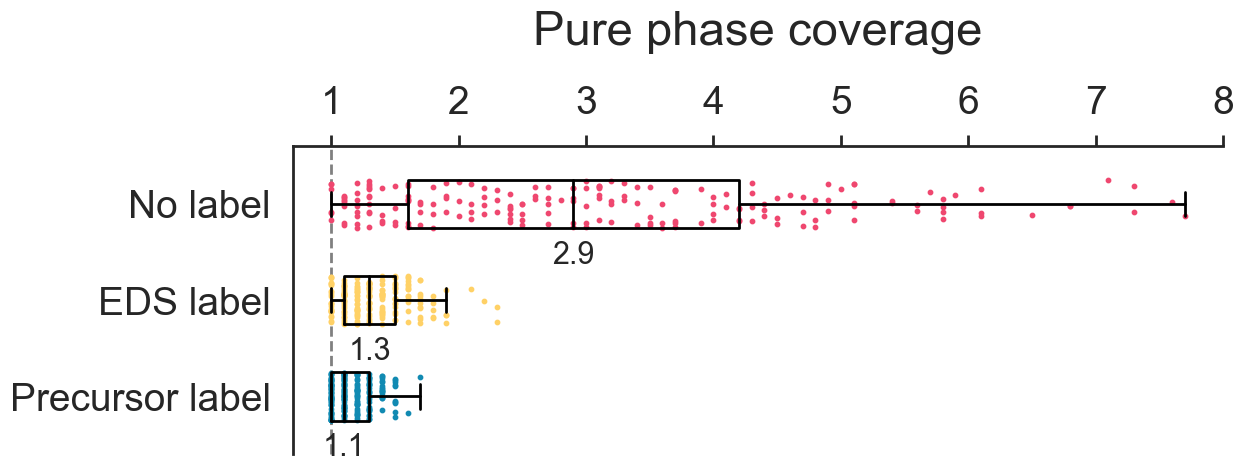

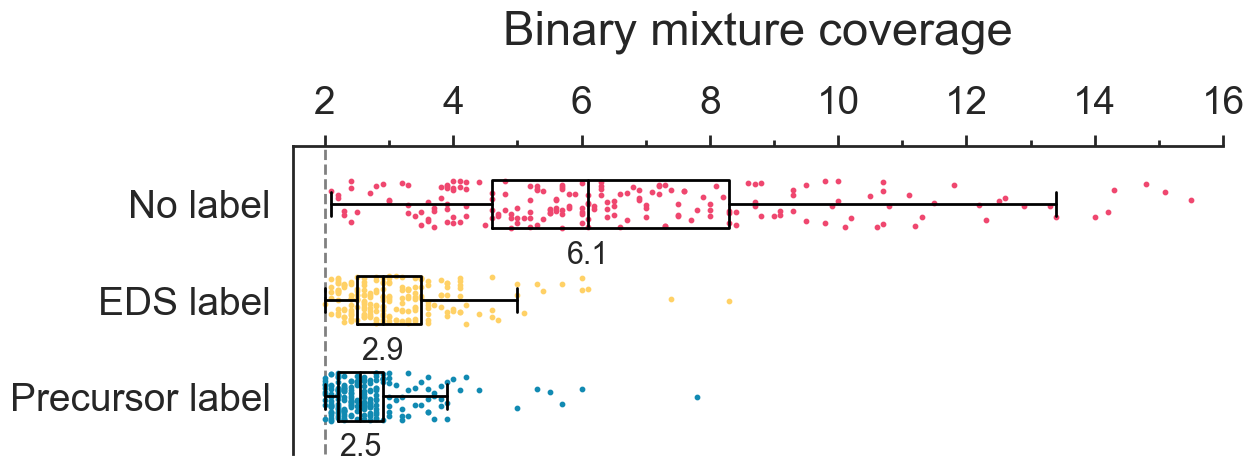

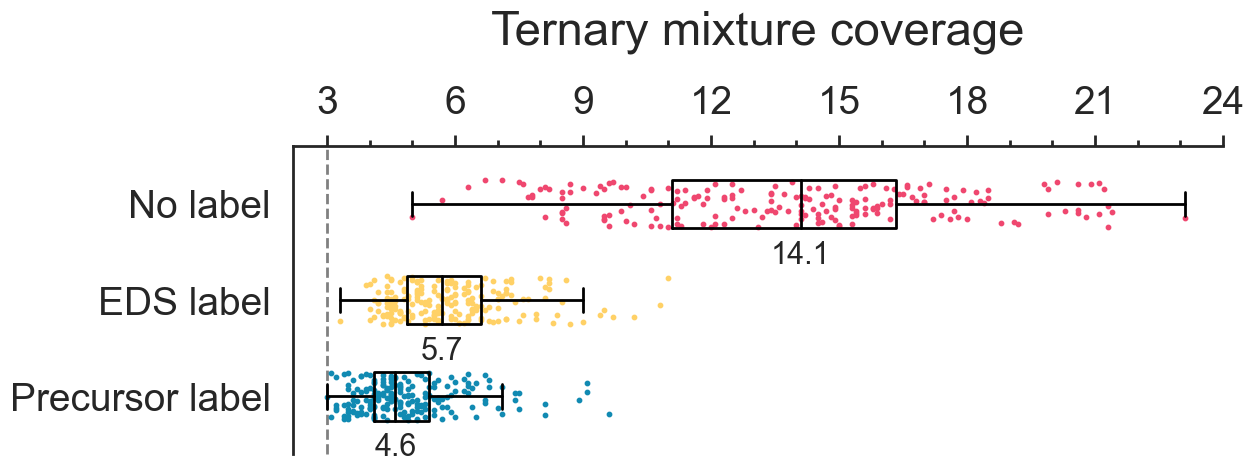

In [16]:
load_plt_setting()
stat_n = 10
prompt_type_list = ['full','eds','none',]
x_dic = {}
for n in ['1','2','3']:
    fig, ax = plt.subplots(figsize=(12, 4))
    x_dic[n] = {}
    for i, (prompt_type,c) in enumerate(zip(prompt_type_list,["#118ab2","#ffd166","#ef476f"])):
        x_dic[n][prompt_type] = {}
        x_dic[n][prompt_type]['raw'] = []
        y_pred_full = np.array(full_result[prompt_type]['{}'.format(n)]['y_pred'])
        y_true_full = np.array(full_result[prompt_type]['{}'.format(n)]['y_true'])
        for j in range(y_pred_full.shape[0]):
            x_dic[n][prompt_type]['raw'].append(coverage_error(y_true_full[j:j+1], y_pred_full[j:j+1]))
        x_dic[n][prompt_type]['stat'] = [np.mean(x_dic[n][prompt_type]['raw'][i:i+stat_n]) for i in range(0,len(x_dic[n][prompt_type]['raw']),stat_n)]
        y = np.random.uniform(i-0.25+1, i+0.25+1, size=len(x_dic[n][prompt_type]['stat']))
        ax.scatter(x_dic[n][prompt_type]['stat'], y, c=c, alpha=1, s=10)
        ax.text(np.median(x_dic[n][prompt_type]['stat']), 1+i-0.53, '{:.1f}'.format(np.median(x_dic[n][prompt_type]['stat'])), 
                ha='center', va='center', fontsize=22)
        
    boxplot = ax.boxplot([x_dic[n][prompt_type_list[0]]['stat'],x_dic[n][prompt_type_list[1]]['stat'],x_dic[n][prompt_type_list[2]]['stat']], 
                         notch=False, vert=False, widths=0.5, sym='', 
                         boxprops=dict(linewidth=2,c='black'), medianprops=dict(linewidth=2,c='black'),
                         whiskerprops=dict(linewidth=2,c='black'), capprops=dict(linewidth=2,c='black'))

    ax.set_ylim([0.4,3.6])
    ax.axes.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=8, integer=True, steps=[2, 5, 10]))
    ax.axes.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=9, integer=False, steps=[2, 3, 5, 10]))
    
    ax.tick_params(axis='x', direction='out', top=True, labeltop=True, bottom=False, 
                   labelbottom=False, length=8, width=2, pad=10, labelsize=28)
    ax.tick_params(axis='x', which='minor', top=True, labeltop=True, bottom=False, 
                   labelbottom=False, direction='out', length=4, width=2, pad=10)
    ax.tick_params(axis='y', labelsize=28)
    ax.spines['bottom'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.set_yticklabels(['','Precursor label ','EDS label ','No label '])
    plt.ylabel('', labelpad=20, fontsize=34)
    ax.xaxis.set_label_position('top')
    ax.axvline(x=int(n), clip_on=False, color='grey', linestyle='--', linewidth=2, zorder=-10)
    
    if n == '1':
        ax.set_xlim([0.7,8])
        plt.xlabel(r'Pure phase coverage', labelpad=30, fontsize=34)
    elif n == '2':
        ax.set_xlim([1.5,16])
        ax.axes.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
        plt.xlabel(r'Binary mixture coverage', labelpad=30, fontsize=34)

    elif n == '3':
        ax.set_xlim([2.2,24])
        ax.axes.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(3))
        plt.xlabel(r'Ternary mixture coverage', labelpad=30, fontsize=34)

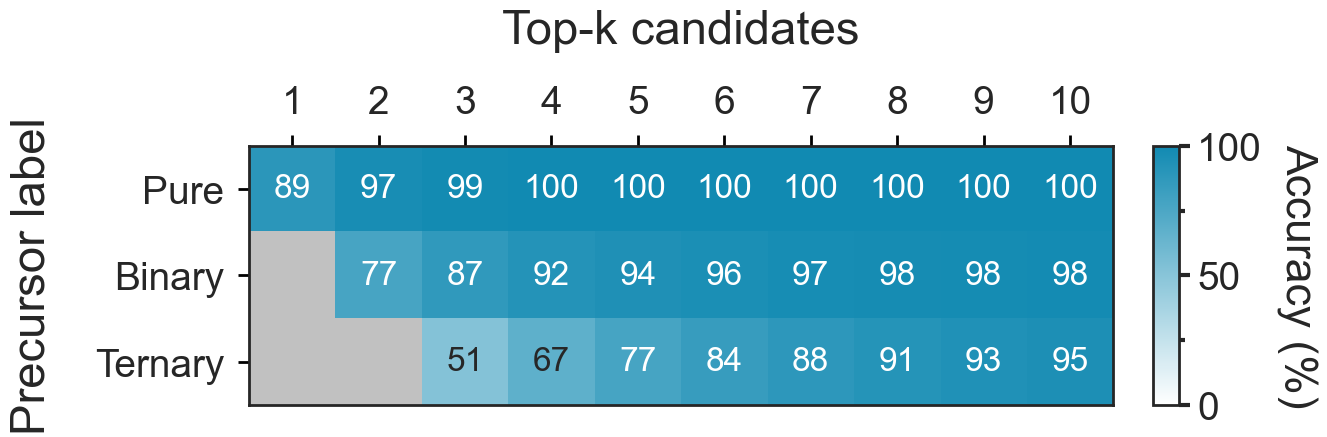

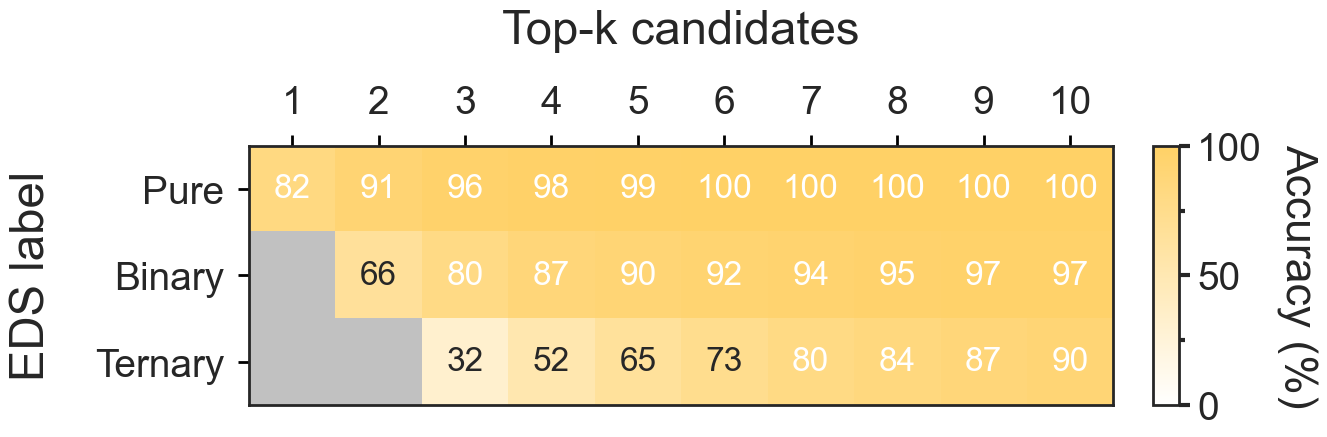

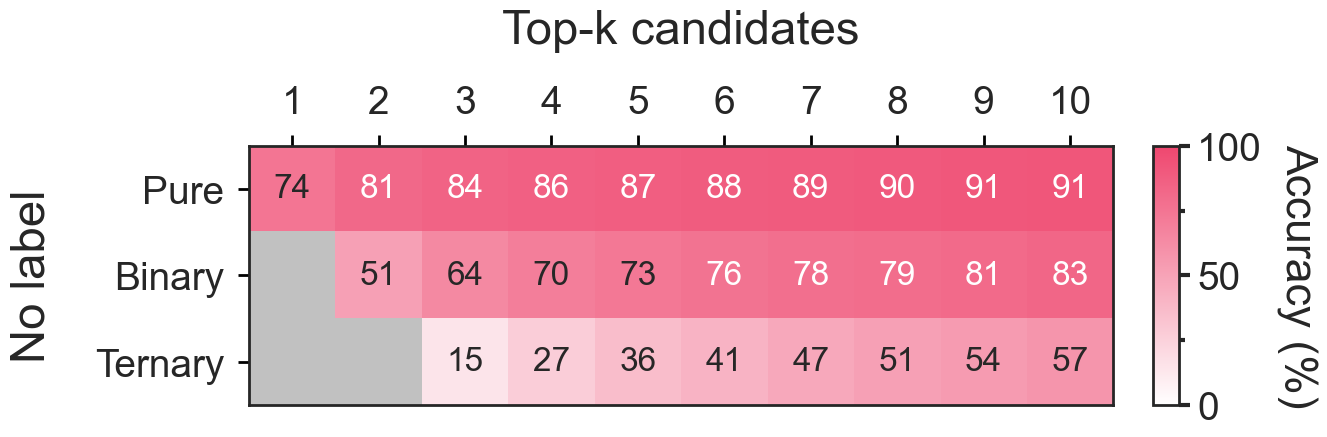

In [17]:
n_phase_list = ['Pure','Binary','Ternary']
prompt_type_list = ['full','eds','none',]
y_titles = ['Precursor label','EDS label','No label']
cmap_colors = ["#118ab2","#ffd166","#ef476f"]
n_list = ['1','2','3']

top_k_stats = np.zeros((len(n_list),len(prompt_type_list),11))
for i, n in enumerate(n_list):
    for j, prompt_type in enumerate(prompt_type_list):
        top_k_list = np.array(x_dic[n][prompt_type]['raw'])
        for k in range(1,11):
            top_k_stats[i,j,k] = len(top_k_list[top_k_list<=k])/len(top_k_list)
top_k_stats = top_k_stats[:,:,1:]-0.00001

load_plt_setting()

for k, prompt_type in enumerate(prompt_type_list):
    fig, ax = plt.subplots(figsize=(12, 10))
    mymap = colors.LinearSegmentedColormap.from_list("", ["#FFFFFF",cmap_colors[k]])
    mymap.set_under('#C1C1C1')

    mat = ax.matshow(top_k_stats[:,k,:]*100, cmap=mymap, vmax=100, vmin=0)
    ax.xaxis.set_ticks_position('bottom')
    ax.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, steps=[1, 2, 5, 10], integer=True))
    ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=11, steps=[1, 2, 5, 10], integer=True))
    ax.tick_params(axis='both',direction='out',length=8,width=2,pad=10,color='black',labelsize=28, 
                   top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.tick_params(axis='both',which='minor',direction='out',length=4,width=2,pad=10,color='black',labelsize=28, 
                   top=True, labeltop=True, bottom=False, labelbottom=False)
    ax.set_yticklabels(['','Pure','Binary','Ternary'])
    ax.set_xticklabels(['','1','2','3','4','5','6','7','8','9','10'])

    ax.set_xlabel(r'Top-k candidates', labelpad=30, fontsize=34)
    ax.set_ylabel(r'{}'.format(y_titles[k]), labelpad=30, fontsize=34)
    ax.xaxis.set_label_position('top')

    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="3%", pad=0.4)

    cbar = plt.colorbar(mat,cax=cax)
    cbar.ax.tick_params(axis='y', direction='out',length=8,width=3,pad=5,labelsize=28)
    cbar.ax.set_ylabel('Accuracy (%)',labelpad=40, rotation=-90)
    cbar.ax.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=3, integer=True, steps=[1,2,5,10]))
    cbar.ax.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
    cbar.ax.tick_params(axis='both',which='minor',direction='out',length=4,width=3,pad=5)

    for (i, j), z in np.ndenumerate(top_k_stats[:,k,:]*100):
        if z > 0:
            if z < 75:
                ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center', fontsize=24, c=colors.to_rgba("#272727"))
            else:
                ax.text(j, i, '{:0.0f}'.format(z), ha='center', va='center', fontsize=24, c=colors.to_rgba("#FFFFFF"))

# 4 Experimental XRD

In [4]:
cif_folder = os.path.join(folder, 'cif')
sample_size = 3e7
visual_embedding_dim = 50
try:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'model', 'multi_phase','{}'.format(int(sample_size)))).to('cuda')
    print('Loading trained model.')
except:
    model = VisualBertForQuestionAnswering.from_pretrained(os.path.join(folder, 'pretrained_model', 'multi_phase')).to('cuda')
    print('Loading pretrained model from repository.')

Loading pretrained model from repository.


## CsPbBr3

In [5]:
data = np.genfromtxt(os.path.join(folder, 'experimental_xrd', 'CsPbBr3.xy'))

twotheta = np.arange(5.00, 60.01, 0.01)
twotheta_corrected = np.arange(5.00, 60.01, 0.01)
X = CubicSpline(data[:,0], data[:,1]-data[:,2])(np.arange(5.00, 45.01, 0.01))

Xs = np.zeros(twotheta.shape)
Xs[:X.shape[0]] = X
Xs = (Xs-np.min(Xs))/(np.max(Xs)-np.min(Xs))

sample_height_displacement = 0.000268*1000
for i in range(len(twotheta_corrected)):
    twotheta_corrected[i] += math.degrees(math.atan(sample_height_displacement*math.sin(math.radians(2*twotheta_corrected[i]))/
                    (2*(110+sample_height_displacement*(math.radians(twotheta_corrected[i]))**2))))
Xs = interp1d(twotheta_corrected, Xs, fill_value="extrapolate")(twotheta)
Xs = (Xs-np.min(Xs))/(np.max(Xs)-np.min(Xs))

Xs = np.expand_dims(Xs,axis=(0,-1))

Xs_test = Xs[:1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

XRD_token_length = -Xs_test.shape[1]
X_prompts = ['Cs Pb Br',]

visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
prompt_token_length = len(inputs['input_ids'][0])
inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

outputs = model(**inputs.to('cuda'), output_attentions=True)

order = np.linspace(0,65,66)
y_pred_full = list(np.array(outputs.logits.detach().cpu())[0])
print('Score for pure/binary/ternary mixture: \n',y_pred_full[-3:])
y_pred_full = y_pred_full[:-3]
y_true_full = np.zeros(len(y_pred_full))
y_true_full[33] += 1

order_sort = [x for _,x in sorted(zip(y_pred_full,order))]
y_true_full_sort = [x for _,x in sorted(zip(y_pred_full,y_true_full))]
y_pred_full_sort = copy.deepcopy(y_pred_full)
y_pred_full_sort.sort()
y_pred_full_sort = [1 / (1 + math.exp(-x)) for x in y_pred_full_sort]

print('\nScore / Ground truth (1=present, 0=not present) / Material index / Chemical name')
for i in range(len(y_true_full_sort)-20,len(y_true_full_sort)):
    print(y_pred_full_sort[i], int(y_true_full_sort[i]),int(order_sort[i]), 
          dataloader.dataset[dataloader.sample_list[int(order_sort[i])]]['formula'])

Score for pure/binary/ternary mixture: 
 [-1.4766271, 4.458799, 2.751099]

Score / Ground truth (1=present, 0=not present) / Material index / Chemical name
0.18931146564142035 0 43 cubic-FAPbBr3
0.23351723737574417 0 0 Cs0.2FA0.8PbBr3
0.2781962514778183 0 20 CsPb(Cl0.2Br0.8)3
0.28221906970644434 0 17 CsBr
0.33829109162781634 0 19 CsPb2Br5
0.3605354077139197 0 49 MA0.6FA0.4PbBr3
0.45002831473915966 0 60 tetragonal-MAPbBr3
0.483061152405802 0 50 MA0.8FA0.2PbBr3
0.6718247990832772 0 9 Cs0.4MA0.6PbBr3
0.7029746292713465 0 2 Cs0.6FA0.4PbBr3
0.704790631212876 0 1 Cs0.4FA0.6PbBr3
0.7191694467220101 0 3 Cs0.8FA0.2PbBr3
0.7471182387908433 0 16 Cs4PbBr6
0.7726444542441636 0 10 Cs0.6MA0.4PbBr3
0.7858877553247157 0 11 Cs0.8MA0.2PbBr3
0.7949944047447698 0 59 cubic-MAPbBr3
0.8051367964144225 0 8 Cs0.2MA0.8PbBr3
0.8211570944231361 0 64 PbBr2
0.8402327977176542 0 32 cubic-CsPbBr3
0.9928804388659459 1 33 orthorhombic-CsPbBr3


Text(0.5, 0, 'Prediction score')

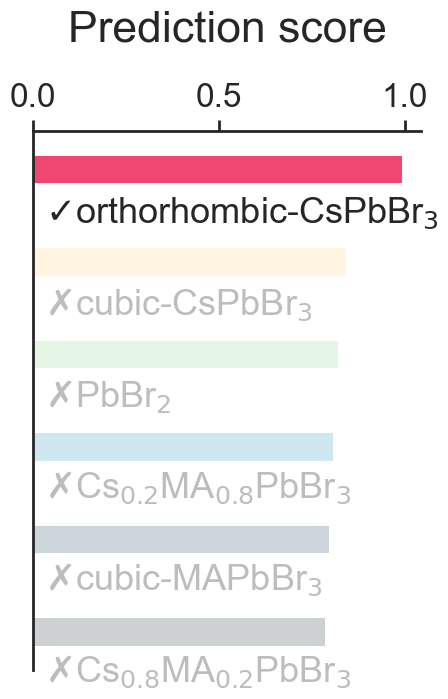

In [6]:
load_plt_setting()

fig, ax = plt.subplots(figsize=(5, 7))

cmap = ['#EF476F','#FFD166','#83D483','#118AB2','#073B4C','#0A1A1F']

for i in range(6):
    label = dataloader.dataset[dataloader.sample_list[int(order_sort[-i-1])]]['formula']
    text = re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', label)
    text_split = text.split('-')
    if text_split[0] in translate_dic:
        text = translate_dic[text_split[0]] + '-' + text_split[1]

    if y_true_full_sort[-i-1] == 0:
        alpha = 0.2
        plt.text(0.03, 0.83-i*0.17, u'$\u2717$'+'{}'.format(text),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha+0.1)
    else:
        alpha = 1
        plt.text(0.03, 0.83-i*0.17, u'$\u2713$'+'{}'.format(text),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha)
    ax.barh(-i, y_pred_full_sort[-i-1], height=0.3, color=colors.to_rgba(cmap[i]), alpha=alpha)
    

ax.tick_params(axis='x', direction='out', top=True, labeltop=True, bottom=False, 
               labelbottom=False, length=8, width=2, pad=5, labelsize=24)
ax.tick_params(axis='x', which='minor', top=True, labeltop=True, bottom=False, 
               labelbottom=False, direction='out', length=4, width=2, pad=10)
plt.yticks([])

# ax.tick_params(axis='y', labelsize=24)
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_label_position('top')
plt.xlabel(r'Prediction score', labelpad=30, fontsize=32)

Text(0, 0.5, 'Intensity                      ')

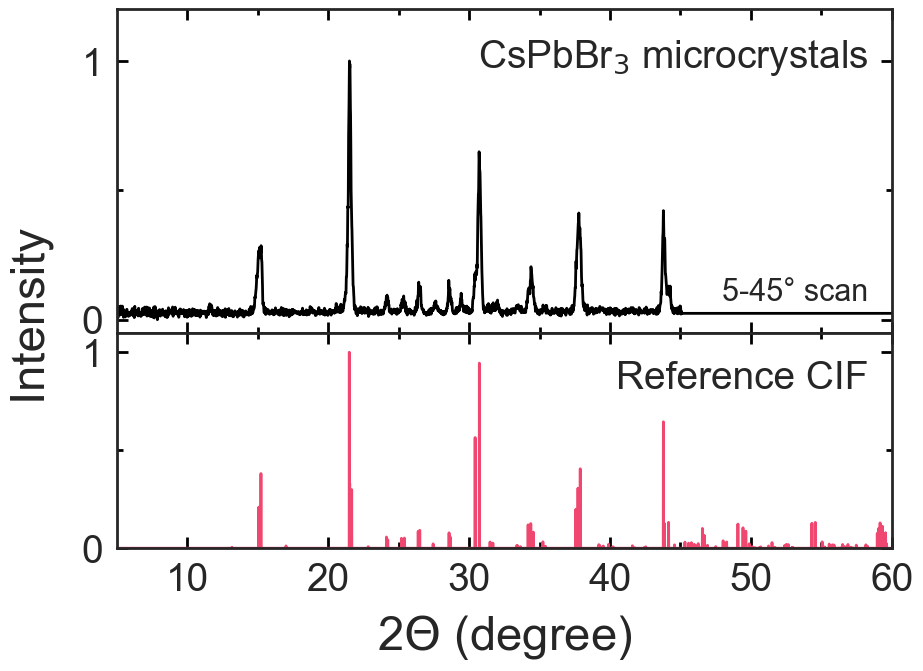

In [7]:
load_plt_setting()

fig, (ax0, ax1,) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[3, 2]),figsize=(10, 7))
mat = ax0.plot(twotheta, Xs[0,:,0], linewidth=2, color=colors.to_rgba('#000000'))
ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.axes.set_ylim([-0.05,1.2])

formula = []
for sample_no, c in zip([33],["#EF476F"]):
    ref = dataloader.load_ref(sample_no)
    mat = ax1.plot(twotheta, ref/np.max(ref), linewidth=2, color=c)
    formula.append(dataloader.dataset[dataloader.sample_list[sample_no]]['formula'])
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.axes.set_ylim([0,1.1])
ax1.axes.set_xlim([twotheta[0],twotheta[-1]])

plt.text(0.97, 0.82, 'CsPbBr$_{3}$ microcrystals', fontsize=28, transform=ax0.transAxes, horizontalalignment='right')
plt.text(0.97, 0.74, 'Reference CIF', fontsize=28, transform=ax1.transAxes, horizontalalignment='right')

plt.text(0.97, 0.1, '5-45'+u"\u00b0"+' scan', fontsize=22, transform=ax0.transAxes, horizontalalignment='right')

plt.subplots_adjust(hspace=.0)

ax1.set_xlabel(r'2$\Theta$ (degree)', labelpad=10, fontsize=34)
ax0.set_ylabel(r'Intensity                      ', labelpad=20, fontsize=34)

## Off-stoichiometry Cs-Pb-Br (Cs-rich)

In [8]:
data = np.genfromtxt(os.path.join(folder, 'experimental_xrd', 'CsPbBr3_Cs-rich.xy'))

twotheta = np.arange(5.00, 60.01, 0.01)
twotheta_corrected = np.arange(5.00, 60.01, 0.01)
Xs = np.zeros(twotheta_corrected.shape)
X = data[:,1]-data[:,2]
Xs[500:] = X
Xs = (Xs-np.min(Xs))/(np.max(Xs)-np.min(Xs))

sample_height_displacement = 0.000486*1000

for i in range(len(twotheta_corrected)):
    twotheta_corrected[i] += math.degrees(math.atan(sample_height_displacement*math.sin(math.radians(2*twotheta_corrected[i]))/
                    (2*(110+sample_height_displacement*(math.radians(twotheta_corrected[i]))**2))))

Xs = interp1d(twotheta_corrected, Xs, fill_value="extrapolate")(twotheta)
Xs = (Xs-np.min(Xs))/(np.max(Xs)-np.min(Xs))

Xs = np.expand_dims(Xs,axis=(0,-1))

Xs_test = Xs[:1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

XRD_token_length = -Xs_test.shape[1]
X_prompts = ['Cs Pb Br']

visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
prompt_token_length = len(inputs['input_ids'][0])
inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

outputs = model(**inputs.to('cuda'), output_attentions=True)

order = np.linspace(0,65,66)
y_pred_full = list(np.array(outputs.logits.detach().cpu())[0])
print('Score for pure/binary/ternary mixture: \n',y_pred_full[-3:])
y_pred_full = y_pred_full[:-3]
y_true_full = np.zeros(len(y_pred_full))
y_true_full[16] += 1
y_true_full[33] += 1

order_sort = [x for _,x in sorted(zip(y_pred_full,order))]
y_true_full_sort = [x for _,x in sorted(zip(y_pred_full,y_true_full))]
y_pred_full_sort = copy.deepcopy(y_pred_full)
y_pred_full_sort.sort()
y_pred_full_sort = [1 / (1 + math.exp(-x)) for x in y_pred_full_sort]

print('\nScore / Ground truth (1=present, 0=not present) / Material index / Chemical name')
for i in range(len(y_true_full_sort)-20,len(y_true_full_sort)):
    print(y_pred_full_sort[i], int(y_true_full_sort[i]),int(order_sort[i]), 
          dataloader.dataset[dataloader.sample_list[int(order_sort[i])]]['formula'])

Score for pure/binary/ternary mixture: 
 [-3.5853415, 3.0071092, 3.8927896]

Score / Ground truth (1=present, 0=not present) / Material index / Chemical name
0.21433034813557494 0 37 delta-CsPbI3
0.24329827632126166 0 48 MA0.4FA0.6PbBr3
0.2645443741113629 0 0 Cs0.2FA0.8PbBr3
0.2714461954484147 0 9 Cs0.4MA0.6PbBr3
0.31719881003090816 0 4 Cs0.2FA0.8PbI3
0.3590098579169878 0 59 cubic-MAPbBr3
0.37593705828926144 0 32 cubic-CsPbBr3
0.4894555145154593 0 49 MA0.6FA0.4PbBr3
0.540767573445137 0 3 Cs0.8FA0.2PbBr3
0.5533437366696775 0 60 tetragonal-MAPbBr3
0.569070313858085 0 17 CsBr
0.5724046634157961 0 11 Cs0.8MA0.2PbBr3
0.5761350062004447 0 1 Cs0.4FA0.6PbBr3
0.5841346422534184 0 10 Cs0.6MA0.4PbBr3
0.6054560525082819 0 50 MA0.8FA0.2PbBr3
0.744676875762491 0 38 gamma-CsPbI3
0.7824555953176076 0 64 PbBr2
0.826870594699956 0 19 CsPb2Br5
0.9570863501911977 1 16 Cs4PbBr6
0.9922903757388 1 33 orthorhombic-CsPbBr3


Text(0.5, 0, 'Prediction score')

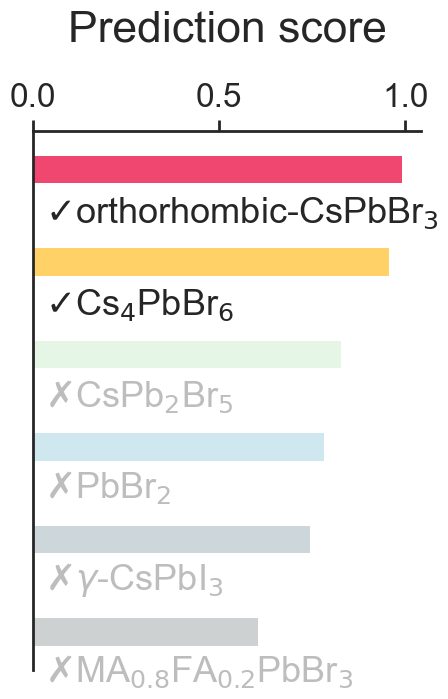

In [9]:
load_plt_setting()

fig, ax = plt.subplots(figsize=(5, 7))

cmap = ['#EF476F','#FFD166','#83D483','#118AB2','#073B4C','#0A1A1F']

for i in range(6):
    label = dataloader.dataset[dataloader.sample_list[int(order_sort[-i-1])]]['formula']
    text = re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', label)
    text_split = text.split('-')
    if text_split[0] in translate_dic:
        text = translate_dic[text_split[0]] + '-' + text_split[1]


    if y_true_full_sort[-i-1] == 0:
        alpha = 0.2
        plt.text(0.03, 0.83-i*0.17, u'$\u2717$'+'{}'.format(text),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha+0.1)
    else:
        alpha = 1
        plt.text(0.03, 0.83-i*0.17, u'$\u2713$'+'{}'.format(text),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha)
    ax.barh(-i, y_pred_full_sort[-i-1], height=0.3, color=colors.to_rgba(cmap[i]), alpha=alpha)
    

ax.tick_params(axis='x', direction='out', top=True, labeltop=True, bottom=False, 
               labelbottom=False, length=8, width=2, pad=5, labelsize=24)
ax.tick_params(axis='x', which='minor', top=True, labeltop=True, bottom=False, 
               labelbottom=False, direction='out', length=4, width=2, pad=10)
plt.yticks([])

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_label_position('top')
plt.xlabel(r'Prediction score', labelpad=30, fontsize=32)

Text(0, 0.5, 'Intensity                      ')

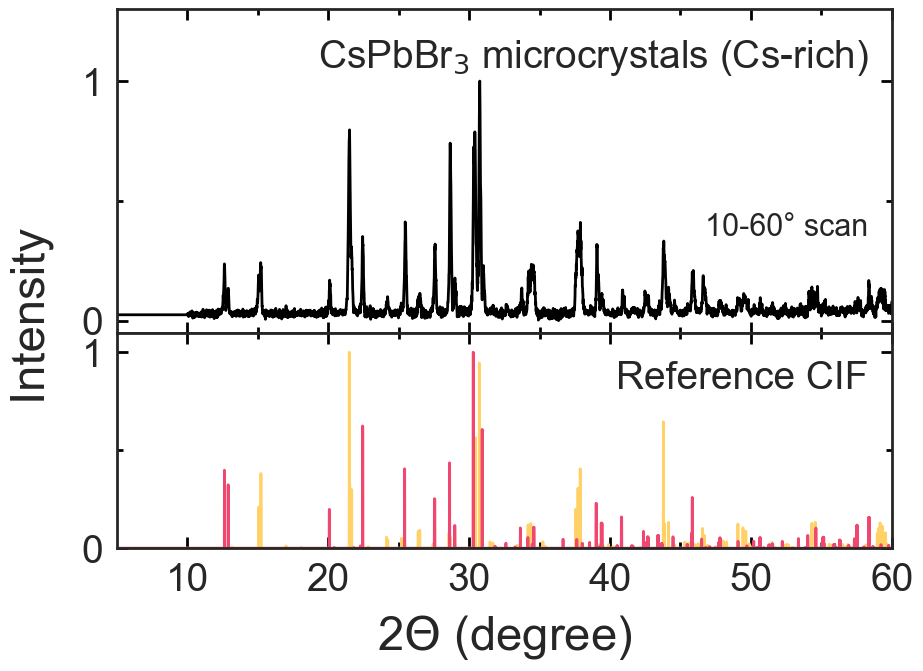

In [10]:
load_plt_setting()

fig, (ax0, ax1,) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[3, 2]),figsize=(10, 7))
mat = ax0.plot(twotheta, Xs[0,:,0], linewidth=2, color=colors.to_rgba('#000000'))
ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.axes.set_ylim([-0.05,1.3])

formula = []
for sample_no, c in zip([33,16,],['#FFD166',"#EF476F",]):
    ref = dataloader.load_ref(sample_no)
    mat = ax1.plot(twotheta, ref/np.max(ref), linewidth=2, color=c)
    formula.append(dataloader.dataset[dataloader.sample_list[sample_no]]['formula'])
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.axes.set_ylim([0,1.1])
ax1.axes.set_xlim([twotheta[0],twotheta[-1]])

plt.text(0.97, 0.82, 'CsPbBr$_{3}$ microcrystals (Cs-rich)', fontsize=28, transform=ax0.transAxes, horizontalalignment='right')
plt.text(0.97, 0.74, 'Reference CIF', fontsize=28, transform=ax1.transAxes, horizontalalignment='right')
plt.text(0.97, 0.30, '10-60'+u"\u00b0"+' scan', fontsize=22, transform=ax0.transAxes, horizontalalignment='right')

plt.subplots_adjust(hspace=.0)

ax1.set_xlabel(r'2$\Theta$ (degree)', labelpad=10, fontsize=34)
ax0.set_ylabel(r'Intensity                      ', labelpad=20, fontsize=34)

## FAPbI3

In [11]:
data = np.genfromtxt(os.path.join(folder, 'experimental_xrd', 'FAPbI3.xy'))

twotheta = np.arange(5.00, 60.01, 0.01)
twotheta_corrected = np.arange(5.00, 70.01, 0.01)
X = np.zeros(twotheta_corrected.shape)
X[:len(data[:,1])] = data[:,1]-data[:,2]

sample_height_displacement = -0.000329*1000
for i in range(len(twotheta_corrected)):
    twotheta_corrected[i] += math.degrees(math.atan(sample_height_displacement*math.sin(math.radians(2*twotheta_corrected[i]))/
                    (2*(110+sample_height_displacement*(math.radians(twotheta_corrected[i]))**2))))

X = interp1d(twotheta_corrected, X, fill_value="extrapolate")(twotheta)
Xs = np.zeros(twotheta.shape)
Xs[-X.shape[0]:] = X
Xs = (Xs-np.min(Xs))/(np.max(Xs)-np.min(Xs))
Xs = np.expand_dims(Xs,axis=(0,-1))

Xs_test = Xs[:1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

XRD_token_length = -Xs_test.shape[1]
X_prompts = ['FA Pb I',]

visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
prompt_token_length = len(inputs['input_ids'][0])
inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

outputs = model(**inputs.to('cuda'), output_attentions=True)

order = np.linspace(0,65,66)
y_pred_full = list(np.array(outputs.logits.detach().cpu())[0])
print('Score for pure/binary/ternary mixture: \n',y_pred_full[-3:])
y_pred_full = y_pred_full[:-3]
y_true_full = np.zeros(len(y_pred_full))
y_true_full[44] += 1
y_true_full[46] += 1
y_true_full[65] += 1

order_sort = [x for _,x in sorted(zip(y_pred_full,order))]
y_true_full_sort = [x for _,x in sorted(zip(y_pred_full,y_true_full))]
y_pred_full_sort = copy.deepcopy(y_pred_full)
y_pred_full_sort.sort()
y_pred_full_sort = [1 / (1 + math.exp(-x)) for x in y_pred_full_sort]

print('\nScore / Ground truth (1=present, 0=not present) / Material index / Chemical name')
for i in range(len(y_true_full_sort)-20,len(y_true_full_sort)):
    print(y_pred_full_sort[i], int(y_true_full_sort[i]),int(order_sort[i]), 
          dataloader.dataset[dataloader.sample_list[int(order_sort[i])]]['formula'])

Score for pure/binary/ternary mixture: 
 [-1.6637719, 2.4995458, 4.740936]

Score / Ground truth (1=present, 0=not present) / Material index / Chemical name
0.25182525319445126 0 18 CsI
0.275919292337248 0 42 FAPb(Br0.8I0.2)3
0.27599775100844587 0 5 Cs0.4FA0.6PbI3
0.2980738017746588 0 34 cubic-CsPbCl3
0.339463206354623 0 28 CsPb(I0.2Cl0.8)3
0.3717320227063032 0 4 Cs0.2FA0.8PbI3
0.4342871139844467 0 6 Cs0.6FA0.4PbI3
0.45341455826044325 0 7 Cs0.8FA0.2PbI3
0.48060809208621247 0 38 gamma-CsPbI3
0.6152831144654408 0 51 MA0.2FA0.8PbI3
0.6554818190598963 0 53 MA0.6FA0.4PbI3
0.6667603192751235 0 61 orthorhombic-MAPbCl3
0.7329208688305374 0 52 MA0.4FA0.6PbI3
0.7374145800009059 0 54 MA0.8FA0.2PbI3
0.885982830018442 0 62 cubic-MAPbI3
0.9241360032921514 1 65 PbI2
0.9367515121596843 0 63 tetragonal-MAPbI3
0.9693697640440189 0 45 beta-FAPbI3
0.9758558075324292 1 46 delta-FAPbI3
0.992276790066007 1 44 alpha-FAPbI3


Text(0.5, 0, 'Prediction score')

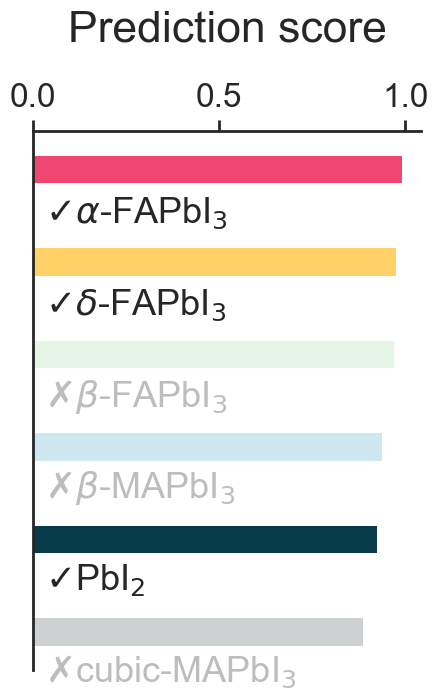

In [12]:
load_plt_setting()

fig, ax = plt.subplots(figsize=(5, 7))

cmap = ['#EF476F','#FFD166','#83D483','#118AB2','#073B4C','#0A1A1F']

for i in range(6):
    label = dataloader.dataset[dataloader.sample_list[int(order_sort[-i-1])]]['formula']
    text = re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', label)
    text_split = text.split('-')
    if text_split[0] in translate_dic:
        text = translate_dic[text_split[0]] + '-' + text_split[1]

    if y_true_full_sort[-i-1] == 0:
        alpha = 0.2
        plt.text(0.03, 0.83-i*0.17, u'$\u2717$'+'{}'.format(text),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha+0.1)
    else:
        alpha = 1
        plt.text(0.03, 0.83-i*0.17, u'$\u2713$'+'{}'.format(text),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha)
    ax.barh(-i, y_pred_full_sort[-i-1], height=0.3, color=colors.to_rgba(cmap[i]), alpha=alpha)
    

ax.tick_params(axis='x', direction='out', top=True, labeltop=True, bottom=False, 
               labelbottom=False, length=8, width=2, pad=5, labelsize=24)
ax.tick_params(axis='x', which='minor', top=True, labeltop=True, bottom=False, 
               labelbottom=False, direction='out', length=4, width=2, pad=10)
plt.yticks([])

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_label_position('top')
plt.xlabel(r'Prediction score', labelpad=30, fontsize=32)

Text(0, 0.5, 'Intensity                      ')

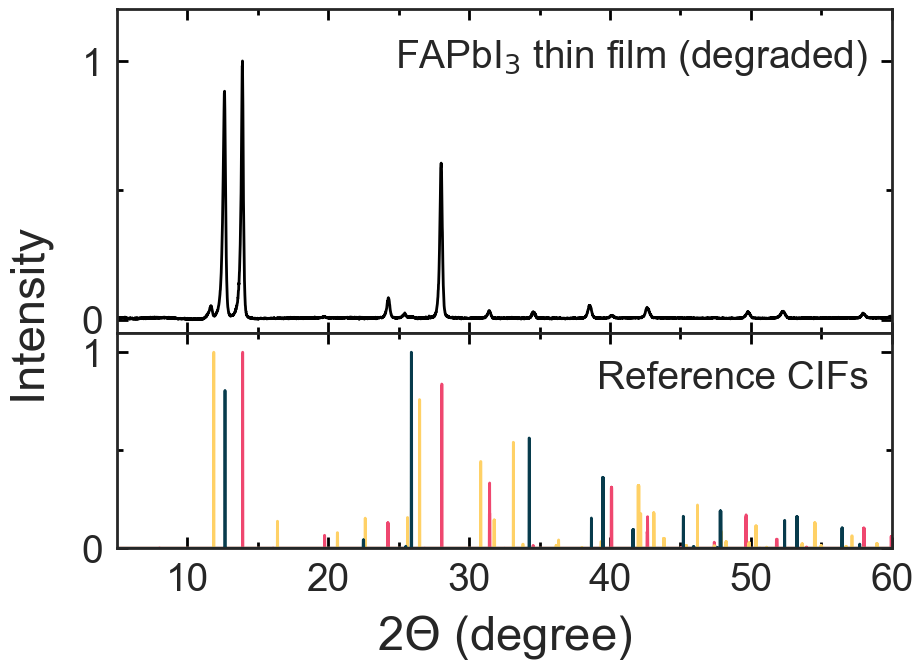

In [13]:
load_plt_setting()

fig, (ax0, ax1,) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[3, 2]),figsize=(10, 7))
mat = ax0.plot(twotheta, Xs[0,:,0], linewidth=2, color=colors.to_rgba('#000000'))
ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.axes.set_ylim([-0.05,1.2])

formula = []
for sample_no, c in zip([44,46,65],["#EF476F","#FFD166","#073B4C"]):
    ref = dataloader.load_ref(sample_no)
    mat = ax1.plot(twotheta, ref/np.max(ref), linewidth=2, color=c)
    formula.append(dataloader.dataset[dataloader.sample_list[sample_no]]['formula'])
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.axes.set_ylim([0,1.1])
ax1.axes.set_xlim([twotheta[0],twotheta[-1]])

plt.text(0.97, 0.82, 'FAPbI$_{3}$ thin film (degraded)', fontsize=28, transform=ax0.transAxes, horizontalalignment='right')
plt.text(0.97, 0.74, 'Reference CIFs', fontsize=28, transform=ax1.transAxes, horizontalalignment='right')
    
plt.subplots_adjust(hspace=.0)

sample_no = 860
ax1.set_xlabel(r'2$\Theta$ (degree)', labelpad=10, fontsize=34)
ax0.set_ylabel(r'Intensity                      ', labelpad=20, fontsize=34)

## MAPbI3

In [14]:
data = np.genfromtxt(os.path.join(folder, 'experimental_xrd', 'MAPbI3.xy'))

twotheta = np.arange(5.00, 60.01, 0.01)
twotheta_corrected = np.arange(5.00, 70.01, 0.01)
X = np.zeros(twotheta_corrected.shape)
X[:len(data[:,1])] = data[:,1]-data[:,2]
sample_height_displacement = -0.003015*1000

for i in range(len(twotheta_corrected)):
    twotheta_corrected[i] += math.degrees(math.atan(sample_height_displacement*math.sin(math.radians(2*twotheta_corrected[i]))/
                    (2*(110+sample_height_displacement*(math.radians(twotheta_corrected[i]))**2))))

X = interp1d(twotheta_corrected, X, fill_value="extrapolate")(twotheta)
Xs = np.zeros(twotheta.shape)
Xs[-X.shape[0]:] = X
Xs = (Xs-np.min(Xs))/(np.max(Xs)-np.min(Xs))
Xs = np.expand_dims(Xs,axis=(0,-1))

Xs_test = Xs[:1,:-1,:].reshape((1,int(Xs.shape[1]/visual_embedding_dim),visual_embedding_dim))

XRD_token_length = -Xs_test.shape[1]
X_prompts = ['MA Pb I',]

visual_embeds = torch.from_numpy(Xs_test).to(dtype=torch.float32)
visual_attention_mask = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)
visual_token_type_ids = torch.ones(visual_embeds.shape[:-1], dtype=torch.long)

inputs = tokenizer(X_prompts, return_tensors="pt", padding=True)
prompt_token_length = len(inputs['input_ids'][0])
inputs.update(
    {
        "visual_embeds": visual_embeds,
        "visual_token_type_ids": visual_token_type_ids,
        "visual_attention_mask": visual_attention_mask,
    }
)

outputs = model(**inputs.to('cuda'), output_attentions=True)

order = np.linspace(0,65,66)
y_pred_full = list(np.array(outputs.logits.detach().cpu())[0])
print('Score for pure/binary/ternary mixture: \n',y_pred_full[-3:])
y_pred_full = y_pred_full[:-3]
y_true_full = np.zeros(len(y_pred_full))
y_true_full[62] += 1
y_true_full[63] += 1

order_sort = [x for _,x in sorted(zip(y_pred_full,order))]
y_true_full_sort = [x for _,x in sorted(zip(y_pred_full,y_true_full))]
y_pred_full_sort = copy.deepcopy(y_pred_full)
y_pred_full_sort.sort()
y_pred_full_sort = [1 / (1 + math.exp(-x)) for x in y_pred_full_sort]

print('\nScore / Ground truth (1=present, 0=not present) / Material index / Chemical name')
for i in range(len(y_true_full_sort)-20,len(y_true_full_sort)):
    print(y_pred_full_sort[i], int(y_true_full_sort[i]),int(order_sort[i]), 
          dataloader.dataset[dataloader.sample_list[int(order_sort[i])]]['formula'])

Score for pure/binary/ternary mixture: 
 [-1.9983552, 4.2886314, 3.723585]

Score / Ground truth (1=present, 0=not present) / Material index / Chemical name
0.2612020340501398 0 52 MA0.4FA0.6PbI3
0.2735494928746211 0 36 alpha-CsPbI3
0.2838734707745811 0 30 CsPb(I0.6Cl0.4)3
0.33608859493464066 0 12 Cs0.2MA0.8PbI3
0.3430562479715261 0 31 CsPb(I0.8Cl0.2)3
0.3442668813364376 0 14 Cs0.6MA0.4PbI3
0.34783174221168184 0 15 Cs0.8MA0.2PbI3
0.39524837801667334 0 13 Cs0.4MA0.6PbI3
0.48629876221543455 0 53 MA0.6FA0.4PbI3
0.5196159816492236 0 65 PbI2
0.5755491797240722 0 18 CsI
0.6090246521736247 0 28 CsPb(I0.2Cl0.8)3
0.665114073930425 0 37 delta-CsPbI3
0.6939943962575057 0 51 MA0.2FA0.8PbI3
0.73311002612212 0 44 alpha-FAPbI3
0.7845230118537224 0 38 gamma-CsPbI3
0.7864767026938722 0 45 beta-FAPbI3
0.9207408851506481 0 61 orthorhombic-MAPbCl3
0.9875951444437828 1 62 cubic-MAPbI3
0.9937225020150348 1 63 tetragonal-MAPbI3


Text(0.5, 0, 'Prediction score')

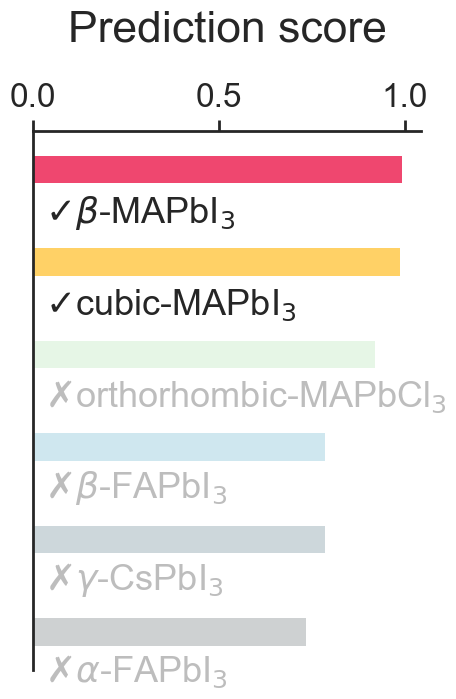

In [15]:
load_plt_setting()

fig, ax = plt.subplots(figsize=(5, 7))

cmap = ['#EF476F','#FFD166','#83D483','#118AB2','#073B4C','#0A1A1F']

for i in range(6):
    label = dataloader.dataset[dataloader.sample_list[int(order_sort[-i-1])]]['formula']
    text = re.sub(r'(\d+(\.\d+)?)', r'$_{\1}$', label)
    text_split = text.split('-')
    if text_split[0] in translate_dic:
        text = translate_dic[text_split[0]] + '-' + text_split[1]

    if y_true_full_sort[-i-1] == 0:
        alpha = 0.2
        plt.text(0.03, 0.83-i*0.17, u'$\u2717$'+'{}'.format(text),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha+0.1)
    else:
        alpha = 1
        plt.text(0.03, 0.83-i*0.17, u'$\u2713$'+'{}'.format(text),
                 fontsize=26, transform=ax.transAxes, horizontalalignment='left', alpha=alpha)
    ax.barh(-i, y_pred_full_sort[-i-1], height=0.3, color=colors.to_rgba(cmap[i]), alpha=alpha)
    

ax.tick_params(axis='x', direction='out', top=True, labeltop=True, bottom=False, 
               labelbottom=False, length=8, width=2, pad=5, labelsize=24)
ax.tick_params(axis='x', which='minor', top=True, labeltop=True, bottom=False, 
               labelbottom=False, direction='out', length=4, width=2, pad=10)
plt.yticks([])

ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.xaxis.set_label_position('top')
plt.xlabel(r'Prediction score', labelpad=30, fontsize=32)

Text(0, 0.5, 'Intensity                      ')

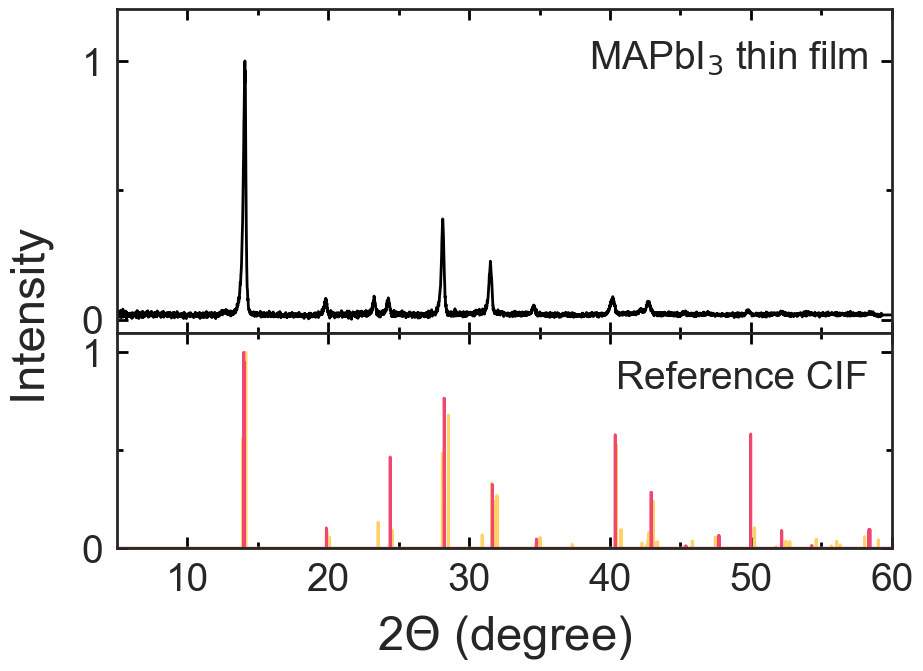

In [16]:
load_plt_setting()

fig, (ax0, ax1,) = plt.subplots(2,1, sharex=True, gridspec_kw=dict(height_ratios=[3, 2]),figsize=(10, 7))
mat = ax0.plot(twotheta, Xs[0,:,0], linewidth=2, color=colors.to_rgba('#000000'))
ax0.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax0.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax0.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax0.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax0.axes.set_ylim([-0.05,1.2])

formula = []
for sample_no, c in zip([63,62,],['#FFD166',"#EF476F",]):
    ref = dataloader.load_ref(sample_no)
    mat = ax1.plot(twotheta, ref/np.max(ref), linewidth=2, color=c)
    formula.append(dataloader.dataset[dataloader.sample_list[sample_no]]['formula'])
ax1.xaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=7, steps=[1, 2, 5, 10]))
ax1.xaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.yaxis.set_major_locator(mpl.ticker.MaxNLocator(nbins=2, steps=[1, 2, 5, 10]))
ax1.yaxis.set_minor_locator(mpl.ticker.AutoMinorLocator(2))
ax1.tick_params(axis='both',direction='in',length=8,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.tick_params(axis='both',which='minor',direction='in',length=4,width=2,pad=10,color='black',right='on',top='on',labelsize=28)
ax1.axes.set_ylim([0,1.1])
ax1.axes.set_xlim([twotheta[0],twotheta[-1]])

plt.text(0.97, 0.82, 'MAPbI$_{3}$ thin film', fontsize=28, transform=ax0.transAxes, horizontalalignment='right')
plt.text(0.97, 0.74, 'Reference CIF', fontsize=28, transform=ax1.transAxes, horizontalalignment='right')
    
plt.subplots_adjust(hspace=.0)

ax1.set_xlabel(r'2$\Theta$ (degree)', labelpad=10, fontsize=34)
ax0.set_ylabel(r'Intensity                      ', labelpad=20, fontsize=34)